# Проект Обучение модели классификации комментариев

## Обзор данных

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers

from tqdm import tqdm, notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier
from catboost import cv, Pool

import warnings 
warnings.filterwarnings('ignore') #скроем предупреждения

In [2]:
# чтение файла `toxic_comments.csv` и сохранение в переменной `df`
df = pd.read_csv('toxic_comments.csv')

In [3]:
# просмотр 10 случайных строк таблицы `df`
df.sample(10)

,text,toxic
11411,I was advised to return here to inform you of ...,0
68818,But what with banning me from Evertype talk? I...,0
157177,"""\n\nUsing """"bank robber"""" instead of """"crimin...",0
69568,"""==Riddle me this==\nAnswer me something? You ...",0
145463,"Rex, you are really a funny guy... ( )",0
81854,June 2009 \n Please stop your disruptive editi...,0
111716,Urgent complain - Wikipedia \n\nAnswer given b...,0
128647,"""\n\nI have a more serious problem with this l...",0
21070,I removed the barnstar you had given me \n\nI ...,0
135993,""":No problem at all, thanks for clarifying for...",0


In [4]:
#получение общей информации о таблице `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В таблице 2 столбца. Типы данных в столбцах: object и int64.

Согласно документации к данным:
* `text` — содержит текст комментария;
* `toxic` — отметка о токсичности комментариев пользователей: 1 - токсичный комментарий, 0 - нетоксичный.

Целевой признак - `toxic`.

Названия столбцов соответствуют хорошему стилю.

Количество значений в столбцах одинаковое, значит, пропущенных значений нет.

### Выводы

В каждой строке таблицы содержится текст комментариев пользователей с отметкой об их токсичности. 

Предварительно можно утверждать, что, данных достаточно для выбора модели. Пропусков в данных не обнаружено, название столбца соответствует хорошему стилю.

Чтобы двигаться дальше, нужно подготовить данные для построения моделей.

## Подготовка данных

Наш целевой признак `toxic` (отметка о токсичности комментариев) - является категориальным, поэтому мы будем подбирать модель для решения задачи классификации. Так как в нашем случае признака всего два (токсичный комментарий или нет), то нас интересует бинарная классификация.

Используем модели Логистическая регрессия и CatBoostClassifier. Для кодирования текстов в векторный вид используем нейронную сеть BERT.

### Проверка баланса классов

Проверим данные на сбалансированность классов.

In [5]:
df['toxic'].mean()

0.10167887648758234

0    0.898321
1    0.101679
Name: toxic, dtype: float64


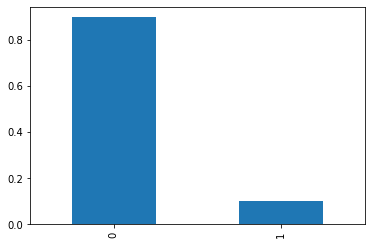

In [6]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Данные в таблице не сбалансированы, токсичиных комментариев намного меньше. Попробуем обучить модели на несбалансированных данных. Объём датасета достаточно большой - отберём из датасета 800 строк для обучающей выборки и 200 строк - для тестовой.

In [9]:
train = df.sample(800).reset_index(drop=True)
train.shape

(800, 2)

In [10]:
# баланс классов в обучающей выборке
train['toxic'].mean()

0.11

In [7]:
test = df.sample(200).reset_index(drop=True)
test.shape

(200, 2)

In [8]:
# баланс классов в тестовой выборке
test['toxic'].mean()

0.105

### Подготовка признаков обучающей выборки

In [11]:
# Инициализируем токенизатор как объект класса BertTokenizer(), передадим ему файл со словарём, на котором обучалась модель
tokenizer = transformers.BertTokenizer(
    vocab_file='/Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/vocab.txt')

In [12]:
# инициализируем модель класса BertModel, передадим ей файл с предобученной моделью и конфигурацией
config = transformers.BertConfig.from_json_file(
    '/Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/config.json')
model = transformers.BertModel.from_pretrained(
    '/Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/pytorch_model.bin', config=config)

Some weights of the model checkpoint at /Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Создадим эмбеддинги BERT для обучающей выборки, установим max_length=512 для того чтобы учесть ограничение BERT на количество слов = 512.

In [13]:
tqdm.pandas()

In [14]:
# преобразуем текст в номера токенов из словаря методом encode()
tokenized = train['text'].progress_apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512, padding="max_length"))

100%|████████████████████████████████████████| 800/800 [00:03<00:00, 262.71it/s]


In [15]:
# проверим максимальную длину вектора в полученной таблице
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

512

In [16]:
# применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [17]:
# теперь поясним модели, что нули не несут значимой информации, «создадим маску» - укажем нулевые и не нулевые значения
attention_mask = np.where(padded != 0, 1, 0)

In [18]:
# зададим размер батча
batch_size = 100

# сделаем пустой список для хранения эмбеддингов твитов
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        # преобразуем данные в формат тензоров в библиотеке torch
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        # преобразуем маску
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        # укажем, что градиенты не нужны
        with torch.no_grad():
            # чтобы получить эмбеддинги для батча, передадим модели данные и маску
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
# соберём все эмбеддинги в матрицу признаков
features_train = np.concatenate(embeddings)
features_train.shape

(800, 768)

### Подготовка признаков тестовой выборки

Создадим эмбеддинги BERT для тестовой выборки.

In [20]:
# преобразуем текст в номера токенов из словаря методом encode()
tokenized_test = test['text'].progress_apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512, padding="max_length"))

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 173.62it/s]


In [21]:
# проверим максимальную длину вектора в полученной таблице
max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

512

In [22]:
# применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными
padded_test = np.array([i + [0]*(max_len - len(i)) for i in tokenized_test.values])

In [23]:
# теперь поясним модели, что нули не несут значимой информации, «создадим маску» - укажем нулевые и не нулевые значения
attention_mask_test = np.where(padded_test != 0, 1, 0)

In [24]:
# зададим размер батча
batch_size = 50

# сделаем пустой список для хранения эмбеддингов твитов
embeddings_test = []

for i in notebook.tqdm(range(padded_test.shape[0] // batch_size)):
        # преобразуем данные в формат тензоров в библиотеке torch
        batch = torch.LongTensor(padded_test[batch_size*i:batch_size*(i+1)]) 
        # преобразуем маску
        attention_mask_batch = torch.LongTensor(attention_mask_test[batch_size*i:batch_size*(i+1)])
        
        # укажем, что градиенты не нужны
        with torch.no_grad():
            # чтобы получить эмбеддинги для батча, передадим модели данные и маску
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
        embeddings_test.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
# соберём все эмбеддинги в матрицу признаков
features_test = np.concatenate(embeddings_test)
features_test.shape

(200, 768)

**Выводы**

На данном этапе мы:
1. проверили данные на сбалансированность классов - классы не сбалансированы, для того чтобы сбалансировать классы мы ограничили размер выборки до 2тыс, выбрав случайно по 1000 строк каждого класса, а также сформировали тестовую выборку с учётом дисбаланса классов;
2. создали эмбеддинги для обучающей и тестовой выборок при помощи нейронной сети BERT.

### Подготовка выборок для обучения и тестирования моделей

Разделим наши таблицы на обучающую и тестовую выборки в соотношении 4:1 - 80% обучающая выборка и 20% тестовая выборка.

In [27]:
# сохраним таргеты в отдельные переменные
target_train = train['toxic']
target_test = test['toxic']

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(800, 768)
(200, 768)
(800,)
(200,)


### Выводы

На данном этапе мы проверили даные на баланс классов - данные в таблице не сбалансированы, приняли решение обучать и тестировать модель на несбалансированных данных; а также подготовили признаки для обучающей и тестовой выборок, применив нейронную сеть BERT для кодирования текстов в векторный вид, и таргеты соответственно.

## Обучение

### LogisticRegression

Подберём значения гиперпараметров для модели Логистическая регрессия, обучим её и оценитм качество.

In [28]:
%%time

logreg = LogisticRegression()

parametrs = {
    'class_weight': ['balanced', 'None'],
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg, parametrs, scoring='f1', cv=5, n_jobs = 1, verbose = 0, return_train_score=True)
clf.fit(features_train, target_train)

print('Best parametres:', clf.best_params_)
print('F1:', clf.best_score_)

Best parametres: {'C': 0.1, 'class_weight': 'None', 'penalty': 'l2', 'solver': 'newton-cg'}
F1: 0.9318859167416044
CPU times: user 35.1 s, sys: 3.18 s, total: 38.3 s
Wall time: 20.8 s


Значения гиперпараметров Логистической регрессии для лучшего значения F1 на обучающей выборке: C = 0.1, class_weight = None, penalty = l2, solver = newton-cg.

In [31]:
%%time

model = LogisticRegression(C=0.1, class_weight='None', penalty='l2', solver='newton-cg')
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

# получим предсказания модели на обучающей выборке и посчитаем значение метрики F1 
pred_train = model.predict(features_train)
f1_train = f1_score(target_train, pred_train)

# получим предсказания модели на тестовой выборке и посчитаем значение метрики F1 
pred_test = model.predict(features_test)
f1_test = f1_score(target_test, pred_test)

print('F1 на обучающей выборке:', f1_train)
print('F1 на тестовой выборке:', f1_test)

F1 на обучающей выборке: 0.9714285714285714
F1 на тестовой выборке: 0.9767441860465117
CPU times: user 174 ms, sys: 16.9 ms, total: 191 ms
Wall time: 131 ms


**Выводы**

F1 на обучающей выборке 0.97, на тестовой - 0.97, что удовлетворяет условию задачи (значение метрики F1 должно быть не меньше 0.75), время работы модели = 131 ms. Модель не переобучилась.

### CatBoostClassifier

Подберём значения гиперпараметров для модели CatBoostClassifier, обучим её и оценитм качество.

In [32]:
%%time

model = CatBoostClassifier()

grid = {'learning_rate': [0.01, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       cv=3,
                                       plot=True)

print('Best parametres:', clf.params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6637696	test: 0.6625514	best: 0.6625514 (0)	total: 222ms	remaining: 3m 42s
1:	learn: 0.6420689	test: 0.6396783	best: 0.6396783 (1)	total: 320ms	remaining: 2m 39s
2:	learn: 0.6206062	test: 0.6170229	best: 0.6170229 (2)	total: 420ms	remaining: 2m 19s
3:	learn: 0.6008155	test: 0.5969965	best: 0.5969965 (3)	total: 523ms	remaining: 2m 10s
4:	learn: 0.5806031	test: 0.5762480	best: 0.5762480 (4)	total: 749ms	remaining: 2m 28s
5:	learn: 0.5616047	test: 0.5567540	best: 0.5567540 (5)	total: 840ms	remaining: 2m 19s
6:	learn: 0.5382632	test: 0.5340436	best: 0.5340436 (6)	total: 963ms	remaining: 2m 16s
7:	learn: 0.5165099	test: 0.5118444	best: 0.5118444 (7)	total: 1.04s	remaining: 2m 8s
8:	learn: 0.5001294	test: 0.4950390	best: 0.4950390 (8)	total: 1.08s	remaining: 1m 59s
9:	learn: 0.4831680	test: 0.4776141	best: 0.4776141 (9)	total: 1.12s	remaining: 1m 51s
10:	learn: 0.4659666	test: 0.4598637	best: 0.4598637 (10)	total: 1.17s	remaining: 1m 44s
11:	learn: 0.4527284	test: 0.4464293	best:

96:	learn: 0.0406624	test: 0.0438373	best: 0.0438373 (96)	total: 6.59s	remaining: 1m 1s
97:	learn: 0.0399370	test: 0.0430923	best: 0.0430923 (97)	total: 6.64s	remaining: 1m 1s
98:	learn: 0.0393055	test: 0.0424893	best: 0.0424893 (98)	total: 6.69s	remaining: 1m
99:	learn: 0.0387289	test: 0.0419759	best: 0.0419759 (99)	total: 6.73s	remaining: 1m
100:	learn: 0.0378258	test: 0.0412879	best: 0.0412879 (100)	total: 6.76s	remaining: 1m
101:	learn: 0.0372771	test: 0.0408065	best: 0.0408065 (101)	total: 6.81s	remaining: 60s
102:	learn: 0.0364926	test: 0.0403516	best: 0.0403516 (102)	total: 6.85s	remaining: 59.7s
103:	learn: 0.0357750	test: 0.0397924	best: 0.0397924 (103)	total: 6.92s	remaining: 59.6s
104:	learn: 0.0351301	test: 0.0391073	best: 0.0391073 (104)	total: 6.97s	remaining: 59.4s
105:	learn: 0.0344534	test: 0.0386004	best: 0.0386004 (105)	total: 7.04s	remaining: 59.4s
106:	learn: 0.0336492	test: 0.0380531	best: 0.0380531 (106)	total: 7.08s	remaining: 59.1s
107:	learn: 0.0330425	test: 0

191:	learn: 0.0098924	test: 0.0203791	best: 0.0203791 (191)	total: 11.1s	remaining: 46.9s
192:	learn: 0.0098090	test: 0.0202702	best: 0.0202702 (192)	total: 11.2s	remaining: 46.8s
193:	learn: 0.0096801	test: 0.0201563	best: 0.0201563 (193)	total: 11.2s	remaining: 46.6s
194:	learn: 0.0095825	test: 0.0201160	best: 0.0201160 (194)	total: 11.3s	remaining: 46.5s
195:	learn: 0.0095069	test: 0.0200550	best: 0.0200550 (195)	total: 11.3s	remaining: 46.4s
196:	learn: 0.0094200	test: 0.0200116	best: 0.0200116 (196)	total: 11.4s	remaining: 46.3s
197:	learn: 0.0093332	test: 0.0198939	best: 0.0198939 (197)	total: 11.4s	remaining: 46.2s
198:	learn: 0.0092563	test: 0.0198852	best: 0.0198852 (198)	total: 11.4s	remaining: 46s
199:	learn: 0.0091752	test: 0.0198159	best: 0.0198159 (199)	total: 11.5s	remaining: 45.9s
200:	learn: 0.0090348	test: 0.0197685	best: 0.0197685 (200)	total: 11.5s	remaining: 45.8s
201:	learn: 0.0089797	test: 0.0196809	best: 0.0196809 (201)	total: 11.6s	remaining: 45.7s
202:	learn: 

283:	learn: 0.0046850	test: 0.0177159	best: 0.0177159 (283)	total: 15.8s	remaining: 39.7s
284:	learn: 0.0046571	test: 0.0177273	best: 0.0177159 (283)	total: 15.8s	remaining: 39.7s
285:	learn: 0.0046111	test: 0.0177808	best: 0.0177159 (283)	total: 15.9s	remaining: 39.6s
286:	learn: 0.0045768	test: 0.0177578	best: 0.0177159 (283)	total: 15.9s	remaining: 39.6s
287:	learn: 0.0045352	test: 0.0176545	best: 0.0176545 (287)	total: 16s	remaining: 39.5s
288:	learn: 0.0044903	test: 0.0175937	best: 0.0175937 (288)	total: 16.1s	remaining: 39.5s
289:	learn: 0.0044646	test: 0.0176002	best: 0.0175937 (288)	total: 16.1s	remaining: 39.4s
290:	learn: 0.0044335	test: 0.0176309	best: 0.0175937 (288)	total: 16.2s	remaining: 39.4s
291:	learn: 0.0044268	test: 0.0176420	best: 0.0175937 (288)	total: 16.2s	remaining: 39.4s
292:	learn: 0.0043988	test: 0.0175982	best: 0.0175937 (288)	total: 16.3s	remaining: 39.3s
293:	learn: 0.0043903	test: 0.0176104	best: 0.0175937 (288)	total: 16.4s	remaining: 39.3s
294:	learn: 

377:	learn: 0.0027215	test: 0.0167156	best: 0.0166223 (371)	total: 21.3s	remaining: 35s
378:	learn: 0.0027049	test: 0.0167275	best: 0.0166223 (371)	total: 21.3s	remaining: 34.9s
379:	learn: 0.0026901	test: 0.0167465	best: 0.0166223 (371)	total: 21.4s	remaining: 34.8s
380:	learn: 0.0026791	test: 0.0167955	best: 0.0166223 (371)	total: 21.4s	remaining: 34.8s
381:	learn: 0.0026697	test: 0.0167890	best: 0.0166223 (371)	total: 21.5s	remaining: 34.7s
382:	learn: 0.0026536	test: 0.0167309	best: 0.0166223 (371)	total: 21.5s	remaining: 34.7s
383:	learn: 0.0026433	test: 0.0167151	best: 0.0166223 (371)	total: 21.6s	remaining: 34.6s
384:	learn: 0.0026326	test: 0.0166936	best: 0.0166223 (371)	total: 21.6s	remaining: 34.6s
385:	learn: 0.0026274	test: 0.0166834	best: 0.0166223 (371)	total: 21.7s	remaining: 34.5s
386:	learn: 0.0026059	test: 0.0165543	best: 0.0165543 (386)	total: 21.8s	remaining: 34.5s
387:	learn: 0.0025983	test: 0.0165880	best: 0.0165543 (386)	total: 21.8s	remaining: 34.4s
388:	learn: 

472:	learn: 0.0018102	test: 0.0162034	best: 0.0162034 (472)	total: 26.7s	remaining: 29.7s
473:	learn: 0.0018071	test: 0.0161804	best: 0.0161804 (473)	total: 26.7s	remaining: 29.6s
474:	learn: 0.0017999	test: 0.0161801	best: 0.0161801 (474)	total: 26.8s	remaining: 29.6s
475:	learn: 0.0017943	test: 0.0161851	best: 0.0161801 (474)	total: 26.8s	remaining: 29.5s
476:	learn: 0.0017890	test: 0.0162305	best: 0.0161801 (474)	total: 26.9s	remaining: 29.5s
477:	learn: 0.0017818	test: 0.0162632	best: 0.0161801 (474)	total: 27s	remaining: 29.4s
478:	learn: 0.0017727	test: 0.0162025	best: 0.0161801 (474)	total: 27s	remaining: 29.4s
479:	learn: 0.0017682	test: 0.0162406	best: 0.0161801 (474)	total: 27s	remaining: 29.3s
480:	learn: 0.0017648	test: 0.0162054	best: 0.0161801 (474)	total: 27.1s	remaining: 29.2s
481:	learn: 0.0017597	test: 0.0161441	best: 0.0161441 (481)	total: 27.1s	remaining: 29.2s
482:	learn: 0.0017560	test: 0.0161340	best: 0.0161340 (482)	total: 27.2s	remaining: 29.1s
483:	learn: 0.00

565:	learn: 0.0013108	test: 0.0156794	best: 0.0155991 (558)	total: 31.6s	remaining: 24.3s
566:	learn: 0.0013077	test: 0.0156596	best: 0.0155991 (558)	total: 31.7s	remaining: 24.2s
567:	learn: 0.0013063	test: 0.0156664	best: 0.0155991 (558)	total: 31.7s	remaining: 24.1s
568:	learn: 0.0013019	test: 0.0156640	best: 0.0155991 (558)	total: 31.8s	remaining: 24.1s
569:	learn: 0.0012989	test: 0.0157014	best: 0.0155991 (558)	total: 31.8s	remaining: 24s
570:	learn: 0.0012966	test: 0.0156989	best: 0.0155991 (558)	total: 31.9s	remaining: 24s
571:	learn: 0.0012947	test: 0.0157094	best: 0.0155991 (558)	total: 31.9s	remaining: 23.9s
572:	learn: 0.0012922	test: 0.0157133	best: 0.0155991 (558)	total: 32s	remaining: 23.8s
573:	learn: 0.0012876	test: 0.0156889	best: 0.0155991 (558)	total: 32.1s	remaining: 23.8s
574:	learn: 0.0012814	test: 0.0156515	best: 0.0155991 (558)	total: 32.1s	remaining: 23.7s
575:	learn: 0.0012771	test: 0.0156435	best: 0.0155991 (558)	total: 32.2s	remaining: 23.7s
576:	learn: 0.00

658:	learn: 0.0010139	test: 0.0148624	best: 0.0148624 (658)	total: 37.5s	remaining: 19.4s
659:	learn: 0.0010104	test: 0.0148474	best: 0.0148474 (659)	total: 37.6s	remaining: 19.4s
660:	learn: 0.0010074	test: 0.0148659	best: 0.0148474 (659)	total: 37.6s	remaining: 19.3s
661:	learn: 0.0010047	test: 0.0148507	best: 0.0148474 (659)	total: 37.7s	remaining: 19.2s
662:	learn: 0.0010033	test: 0.0148349	best: 0.0148349 (662)	total: 37.7s	remaining: 19.2s
663:	learn: 0.0010026	test: 0.0148499	best: 0.0148349 (662)	total: 37.8s	remaining: 19.1s
664:	learn: 0.0010011	test: 0.0148467	best: 0.0148349 (662)	total: 37.8s	remaining: 19.1s
665:	learn: 0.0009962	test: 0.0148150	best: 0.0148150 (665)	total: 37.9s	remaining: 19s
666:	learn: 0.0009924	test: 0.0148173	best: 0.0148150 (665)	total: 37.9s	remaining: 18.9s
667:	learn: 0.0009899	test: 0.0148013	best: 0.0148013 (667)	total: 38s	remaining: 18.9s
668:	learn: 0.0009866	test: 0.0147979	best: 0.0147979 (668)	total: 38s	remaining: 18.8s
669:	learn: 0.00

750:	learn: 0.0007715	test: 0.0149692	best: 0.0146359 (703)	total: 42.6s	remaining: 14.1s
751:	learn: 0.0007690	test: 0.0149750	best: 0.0146359 (703)	total: 42.7s	remaining: 14.1s
752:	learn: 0.0007670	test: 0.0149912	best: 0.0146359 (703)	total: 42.7s	remaining: 14s
753:	learn: 0.0007653	test: 0.0149606	best: 0.0146359 (703)	total: 42.8s	remaining: 13.9s
754:	learn: 0.0007627	test: 0.0149672	best: 0.0146359 (703)	total: 42.8s	remaining: 13.9s
755:	learn: 0.0007585	test: 0.0149995	best: 0.0146359 (703)	total: 42.9s	remaining: 13.8s
756:	learn: 0.0007561	test: 0.0150010	best: 0.0146359 (703)	total: 42.9s	remaining: 13.8s
757:	learn: 0.0007541	test: 0.0150353	best: 0.0146359 (703)	total: 43s	remaining: 13.7s
758:	learn: 0.0007532	test: 0.0150554	best: 0.0146359 (703)	total: 43.1s	remaining: 13.7s
759:	learn: 0.0007517	test: 0.0150743	best: 0.0146359 (703)	total: 43.1s	remaining: 13.6s
760:	learn: 0.0007467	test: 0.0150045	best: 0.0146359 (703)	total: 43.2s	remaining: 13.6s
761:	learn: 0.

845:	learn: 0.0005692	test: 0.0147974	best: 0.0146359 (703)	total: 47.7s	remaining: 8.69s
846:	learn: 0.0005686	test: 0.0148040	best: 0.0146359 (703)	total: 47.8s	remaining: 8.63s
847:	learn: 0.0005664	test: 0.0148104	best: 0.0146359 (703)	total: 47.9s	remaining: 8.58s
848:	learn: 0.0005657	test: 0.0148094	best: 0.0146359 (703)	total: 47.9s	remaining: 8.52s
849:	learn: 0.0005646	test: 0.0148351	best: 0.0146359 (703)	total: 48s	remaining: 8.47s
850:	learn: 0.0005638	test: 0.0148582	best: 0.0146359 (703)	total: 48s	remaining: 8.41s
851:	learn: 0.0005635	test: 0.0148750	best: 0.0146359 (703)	total: 48.1s	remaining: 8.36s
852:	learn: 0.0005628	test: 0.0148794	best: 0.0146359 (703)	total: 48.2s	remaining: 8.3s
853:	learn: 0.0005610	test: 0.0148922	best: 0.0146359 (703)	total: 48.2s	remaining: 8.24s
854:	learn: 0.0005597	test: 0.0149033	best: 0.0146359 (703)	total: 48.3s	remaining: 8.19s
855:	learn: 0.0005594	test: 0.0149073	best: 0.0146359 (703)	total: 48.3s	remaining: 8.13s
856:	learn: 0.0

941:	learn: 0.0004507	test: 0.0145891	best: 0.0145777 (929)	total: 52.7s	remaining: 3.25s
942:	learn: 0.0004502	test: 0.0146011	best: 0.0145777 (929)	total: 52.8s	remaining: 3.19s
943:	learn: 0.0004499	test: 0.0146130	best: 0.0145777 (929)	total: 52.8s	remaining: 3.13s
944:	learn: 0.0004494	test: 0.0146121	best: 0.0145777 (929)	total: 52.8s	remaining: 3.08s
945:	learn: 0.0004494	test: 0.0146121	best: 0.0145777 (929)	total: 52.9s	remaining: 3.02s
946:	learn: 0.0004480	test: 0.0146186	best: 0.0145777 (929)	total: 52.9s	remaining: 2.96s
947:	learn: 0.0004465	test: 0.0146260	best: 0.0145777 (929)	total: 53s	remaining: 2.9s
948:	learn: 0.0004460	test: 0.0146278	best: 0.0145777 (929)	total: 53s	remaining: 2.85s
949:	learn: 0.0004458	test: 0.0146314	best: 0.0145777 (929)	total: 53.1s	remaining: 2.79s
950:	learn: 0.0004454	test: 0.0146433	best: 0.0145777 (929)	total: 53.1s	remaining: 2.73s
951:	learn: 0.0004449	test: 0.0146424	best: 0.0145777 (929)	total: 53.1s	remaining: 2.68s
952:	learn: 0.0

35:	learn: 0.0003428	test: 0.0242856	best: 0.0147500 (13)	total: 1.85s	remaining: 49.6s
36:	learn: 0.0003428	test: 0.0242852	best: 0.0147500 (13)	total: 1.89s	remaining: 49.2s
37:	learn: 0.0003426	test: 0.0242865	best: 0.0147500 (13)	total: 1.93s	remaining: 48.9s
38:	learn: 0.0003426	test: 0.0242866	best: 0.0147500 (13)	total: 1.97s	remaining: 48.6s
39:	learn: 0.0003425	test: 0.0242880	best: 0.0147500 (13)	total: 2.01s	remaining: 48.3s
40:	learn: 0.0003383	test: 0.0243296	best: 0.0147500 (13)	total: 2.06s	remaining: 48.3s
41:	learn: 0.0003195	test: 0.0231830	best: 0.0147500 (13)	total: 2.11s	remaining: 48.1s
42:	learn: 0.0003009	test: 0.0235105	best: 0.0147500 (13)	total: 2.16s	remaining: 48.2s
43:	learn: 0.0003009	test: 0.0235105	best: 0.0147500 (13)	total: 2.2s	remaining: 47.9s
44:	learn: 0.0003009	test: 0.0235105	best: 0.0147500 (13)	total: 2.25s	remaining: 47.7s
45:	learn: 0.0003009	test: 0.0235106	best: 0.0147500 (13)	total: 2.29s	remaining: 47.5s
46:	learn: 0.0003009	test: 0.0235

133:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.14s	remaining: 39.7s
134:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.18s	remaining: 39.6s
135:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.23s	remaining: 39.6s
136:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.27s	remaining: 39.5s
137:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.31s	remaining: 39.4s
138:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.35s	remaining: 39.4s
139:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.4s	remaining: 39.3s
140:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.44s	remaining: 39.2s
141:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.48s	remaining: 39.2s
142:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.52s	remaining: 39.1s
143:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 6.57s	remaining: 39s
144:	learn: 0.0003002	te

226:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 10.9s	remaining: 37.1s
227:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 10.9s	remaining: 37s
228:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11s	remaining: 36.9s
229:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11s	remaining: 36.8s
230:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11s	remaining: 36.8s
231:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11.1s	remaining: 36.7s
232:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11.1s	remaining: 36.6s
233:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11.2s	remaining: 36.6s
234:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11.2s	remaining: 36.5s
235:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11.2s	remaining: 36.4s
236:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 11.3s	remaining: 36.3s
237:	learn: 0.0003002	test: 0

323:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.1s	remaining: 31.5s
324:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.1s	remaining: 31.5s
325:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.2s	remaining: 31.4s
326:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.2s	remaining: 31.3s
327:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.3s	remaining: 31.3s
328:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.3s	remaining: 31.2s
329:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.4s	remaining: 31.2s
330:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.4s	remaining: 31.1s
331:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.4s	remaining: 31.1s
332:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.5s	remaining: 31s
333:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 15.5s	remaining: 30.9s
334:	learn: 0.0003002	t

416:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.2s	remaining: 29.7s
417:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.3s	remaining: 29.6s
418:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.3s	remaining: 29.5s
419:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.3s	remaining: 29.5s
420:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.4s	remaining: 29.4s
421:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.5s	remaining: 29.4s
422:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.5s	remaining: 29.4s
423:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.6s	remaining: 29.3s
424:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.6s	remaining: 29.3s
425:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.7s	remaining: 29.2s
426:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 21.7s	remaining: 29.2s
427:	learn: 0.0003002

513:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.5s	remaining: 25s
514:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.5s	remaining: 25s
515:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.6s	remaining: 24.9s
516:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.6s	remaining: 24.9s
517:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.6s	remaining: 24.8s
518:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.7s	remaining: 24.7s
519:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.7s	remaining: 24.7s
520:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.8s	remaining: 24.6s
521:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.8s	remaining: 24.6s
522:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.9s	remaining: 24.5s
523:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 26.9s	remaining: 24.5s
524:	learn: 0.0003002	tes

608:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 31.6s	remaining: 20.3s
609:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 31.7s	remaining: 20.3s
610:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 31.8s	remaining: 20.2s
611:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 31.8s	remaining: 20.2s
612:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 31.9s	remaining: 20.1s
613:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 31.9s	remaining: 20.1s
614:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 32s	remaining: 20s
615:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 32s	remaining: 20s
616:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 32.1s	remaining: 20s
617:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 32.2s	remaining: 19.9s
618:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 32.2s	remaining: 19.8s
619:	learn: 0.0003002	test: 0.0

701:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 37.2s	remaining: 15.8s
702:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 37.4s	remaining: 15.8s
703:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 37.5s	remaining: 15.8s
704:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 37.7s	remaining: 15.8s
705:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 37.8s	remaining: 15.7s
706:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 37.9s	remaining: 15.7s
707:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 38.1s	remaining: 15.7s
708:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 38.2s	remaining: 15.7s
709:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 38.4s	remaining: 15.7s
710:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 38.4s	remaining: 15.6s
711:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 38.5s	remaining: 15.6s
712:	learn: 0.0003002

795:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.3s	remaining: 11.1s
796:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.4s	remaining: 11s
797:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.4s	remaining: 11s
798:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.5s	remaining: 10.9s
799:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.5s	remaining: 10.9s
800:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.7s	remaining: 10.9s
801:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.8s	remaining: 10.8s
802:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.8s	remaining: 10.8s
803:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 43.9s	remaining: 10.7s
804:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 44s	remaining: 10.7s
805:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 44s	remaining: 10.6s
806:	learn: 0.0003002	test: 0

889:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 49.6s	remaining: 6.13s
890:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 49.8s	remaining: 6.09s
891:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 49.9s	remaining: 6.04s
892:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50s	remaining: 5.99s
893:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50.1s	remaining: 5.94s
894:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50.1s	remaining: 5.88s
895:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50.2s	remaining: 5.82s
896:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50.2s	remaining: 5.76s
897:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50.2s	remaining: 5.71s
898:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50.3s	remaining: 5.65s
899:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 50.3s	remaining: 5.59s
900:	learn: 0.0003002	t

985:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.4s	remaining: 787ms
986:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.4s	remaining: 730ms
987:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.5s	remaining: 674ms
988:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.5s	remaining: 617ms
989:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.6s	remaining: 561ms
990:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.6s	remaining: 505ms
991:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.6s	remaining: 449ms
992:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.7s	remaining: 393ms
993:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.7s	remaining: 336ms
994:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.8s	remaining: 280ms
995:	learn: 0.0003002	test: 0.0235204	best: 0.0147500 (13)	total: 55.8s	remaining: 224ms
996:	learn: 0.0003002

78:	learn: 0.0818319	test: 0.0765856	best: 0.0765856 (78)	total: 3.92s	remaining: 45.8s
79:	learn: 0.0802541	test: 0.0751986	best: 0.0751986 (79)	total: 3.97s	remaining: 45.7s
80:	learn: 0.0788807	test: 0.0739588	best: 0.0739588 (80)	total: 4.02s	remaining: 45.6s
81:	learn: 0.0772631	test: 0.0726450	best: 0.0726450 (81)	total: 4.08s	remaining: 45.6s
82:	learn: 0.0755736	test: 0.0712707	best: 0.0712707 (82)	total: 4.2s	remaining: 46.4s
83:	learn: 0.0741762	test: 0.0699368	best: 0.0699368 (83)	total: 4.31s	remaining: 47s
84:	learn: 0.0728585	test: 0.0688072	best: 0.0688072 (84)	total: 4.39s	remaining: 47.3s
85:	learn: 0.0712420	test: 0.0671326	best: 0.0671326 (85)	total: 4.44s	remaining: 47.2s
86:	learn: 0.0699376	test: 0.0660855	best: 0.0660855 (86)	total: 4.48s	remaining: 47s
87:	learn: 0.0684319	test: 0.0647346	best: 0.0647346 (87)	total: 4.52s	remaining: 46.9s
88:	learn: 0.0667664	test: 0.0633446	best: 0.0633446 (88)	total: 4.57s	remaining: 46.7s
89:	learn: 0.0658198	test: 0.0625357	

173:	learn: 0.0197435	test: 0.0265225	best: 0.0265225 (173)	total: 9.11s	remaining: 43.2s
174:	learn: 0.0195235	test: 0.0264269	best: 0.0264269 (174)	total: 9.16s	remaining: 43.2s
175:	learn: 0.0193147	test: 0.0263453	best: 0.0263453 (175)	total: 9.22s	remaining: 43.2s
176:	learn: 0.0191011	test: 0.0262695	best: 0.0262695 (176)	total: 9.27s	remaining: 43.1s
177:	learn: 0.0188375	test: 0.0260898	best: 0.0260898 (177)	total: 9.33s	remaining: 43.1s
178:	learn: 0.0186252	test: 0.0259336	best: 0.0259336 (178)	total: 9.38s	remaining: 43s
179:	learn: 0.0184534	test: 0.0256537	best: 0.0256537 (179)	total: 9.41s	remaining: 42.9s
180:	learn: 0.0182249	test: 0.0255993	best: 0.0255993 (180)	total: 9.46s	remaining: 42.8s
181:	learn: 0.0180447	test: 0.0254245	best: 0.0254245 (181)	total: 9.51s	remaining: 42.7s
182:	learn: 0.0178325	test: 0.0252678	best: 0.0252678 (182)	total: 9.55s	remaining: 42.6s
183:	learn: 0.0176588	test: 0.0251168	best: 0.0251168 (183)	total: 9.59s	remaining: 42.5s
184:	learn: 

266:	learn: 0.0097803	test: 0.0199316	best: 0.0199316 (266)	total: 14.3s	remaining: 39.2s
267:	learn: 0.0097363	test: 0.0198979	best: 0.0198979 (267)	total: 14.3s	remaining: 39.1s
268:	learn: 0.0096775	test: 0.0198715	best: 0.0198715 (268)	total: 14.4s	remaining: 39.1s
269:	learn: 0.0096482	test: 0.0198678	best: 0.0198678 (269)	total: 14.4s	remaining: 39s
270:	learn: 0.0096043	test: 0.0198263	best: 0.0198263 (270)	total: 14.5s	remaining: 38.9s
271:	learn: 0.0095954	test: 0.0198279	best: 0.0198263 (270)	total: 14.5s	remaining: 38.8s
272:	learn: 0.0095061	test: 0.0197399	best: 0.0197399 (272)	total: 14.6s	remaining: 38.8s
273:	learn: 0.0094478	test: 0.0197603	best: 0.0197399 (272)	total: 14.6s	remaining: 38.7s
274:	learn: 0.0094439	test: 0.0197608	best: 0.0197399 (272)	total: 14.7s	remaining: 38.7s
275:	learn: 0.0094254	test: 0.0197594	best: 0.0197399 (272)	total: 14.7s	remaining: 38.6s
276:	learn: 0.0093856	test: 0.0197115	best: 0.0197115 (276)	total: 14.8s	remaining: 38.5s
277:	learn: 

362:	learn: 0.0061839	test: 0.0180030	best: 0.0180030 (362)	total: 18.7s	remaining: 32.8s
363:	learn: 0.0061575	test: 0.0180075	best: 0.0180030 (362)	total: 18.8s	remaining: 32.8s
364:	learn: 0.0061365	test: 0.0180211	best: 0.0180030 (362)	total: 18.8s	remaining: 32.7s
365:	learn: 0.0061229	test: 0.0180067	best: 0.0180030 (362)	total: 18.9s	remaining: 32.7s
366:	learn: 0.0060925	test: 0.0179988	best: 0.0179988 (366)	total: 18.9s	remaining: 32.6s
367:	learn: 0.0060459	test: 0.0179473	best: 0.0179473 (367)	total: 18.9s	remaining: 32.5s
368:	learn: 0.0060146	test: 0.0179708	best: 0.0179473 (367)	total: 19s	remaining: 32.5s
369:	learn: 0.0059904	test: 0.0179080	best: 0.0179080 (369)	total: 19s	remaining: 32.4s
370:	learn: 0.0059557	test: 0.0179082	best: 0.0179080 (369)	total: 19.1s	remaining: 32.3s
371:	learn: 0.0059383	test: 0.0178921	best: 0.0178921 (371)	total: 19.1s	remaining: 32.3s
372:	learn: 0.0059137	test: 0.0178619	best: 0.0178619 (372)	total: 19.1s	remaining: 32.2s
373:	learn: 0.

454:	learn: 0.0044847	test: 0.0177188	best: 0.0176692 (443)	total: 23.1s	remaining: 27.7s
455:	learn: 0.0044556	test: 0.0177299	best: 0.0176692 (443)	total: 23.2s	remaining: 27.6s
456:	learn: 0.0044411	test: 0.0177136	best: 0.0176692 (443)	total: 23.2s	remaining: 27.6s
457:	learn: 0.0044110	test: 0.0176751	best: 0.0176692 (443)	total: 23.3s	remaining: 27.5s
458:	learn: 0.0044090	test: 0.0176800	best: 0.0176692 (443)	total: 23.3s	remaining: 27.5s
459:	learn: 0.0043922	test: 0.0176898	best: 0.0176692 (443)	total: 23.4s	remaining: 27.4s
460:	learn: 0.0043753	test: 0.0176720	best: 0.0176692 (443)	total: 23.5s	remaining: 27.4s
461:	learn: 0.0043613	test: 0.0176667	best: 0.0176667 (461)	total: 23.6s	remaining: 27.4s
462:	learn: 0.0043489	test: 0.0176265	best: 0.0176265 (462)	total: 23.7s	remaining: 27.4s
463:	learn: 0.0043462	test: 0.0176124	best: 0.0176124 (463)	total: 23.8s	remaining: 27.5s
464:	learn: 0.0043398	test: 0.0176162	best: 0.0176124 (463)	total: 23.9s	remaining: 27.5s
465:	learn

548:	learn: 0.0033287	test: 0.0169800	best: 0.0169800 (548)	total: 31s	remaining: 25.5s
549:	learn: 0.0033143	test: 0.0169576	best: 0.0169576 (549)	total: 31.1s	remaining: 25.4s
550:	learn: 0.0033099	test: 0.0169448	best: 0.0169448 (550)	total: 31.1s	remaining: 25.4s
551:	learn: 0.0032961	test: 0.0169500	best: 0.0169448 (550)	total: 31.2s	remaining: 25.3s
552:	learn: 0.0032876	test: 0.0169277	best: 0.0169277 (552)	total: 31.2s	remaining: 25.2s
553:	learn: 0.0032734	test: 0.0169633	best: 0.0169277 (552)	total: 31.3s	remaining: 25.2s
554:	learn: 0.0032675	test: 0.0169553	best: 0.0169277 (552)	total: 31.3s	remaining: 25.1s
555:	learn: 0.0032590	test: 0.0169646	best: 0.0169277 (552)	total: 31.4s	remaining: 25.1s
556:	learn: 0.0032572	test: 0.0169697	best: 0.0169277 (552)	total: 31.5s	remaining: 25.1s
557:	learn: 0.0032502	test: 0.0169450	best: 0.0169277 (552)	total: 31.6s	remaining: 25s
558:	learn: 0.0032482	test: 0.0169465	best: 0.0169277 (552)	total: 31.7s	remaining: 25s
559:	learn: 0.00

641:	learn: 0.0027234	test: 0.0166218	best: 0.0165985 (638)	total: 37.5s	remaining: 20.9s
642:	learn: 0.0027172	test: 0.0165994	best: 0.0165985 (638)	total: 37.6s	remaining: 20.9s
643:	learn: 0.0027094	test: 0.0165972	best: 0.0165972 (643)	total: 37.6s	remaining: 20.8s
644:	learn: 0.0027075	test: 0.0166054	best: 0.0165972 (643)	total: 37.6s	remaining: 20.7s
645:	learn: 0.0027047	test: 0.0166190	best: 0.0165972 (643)	total: 37.7s	remaining: 20.7s
646:	learn: 0.0026934	test: 0.0166380	best: 0.0165972 (643)	total: 37.8s	remaining: 20.6s
647:	learn: 0.0026844	test: 0.0166416	best: 0.0165972 (643)	total: 37.8s	remaining: 20.5s
648:	learn: 0.0026821	test: 0.0166239	best: 0.0165972 (643)	total: 37.8s	remaining: 20.5s
649:	learn: 0.0026811	test: 0.0166186	best: 0.0165972 (643)	total: 37.9s	remaining: 20.4s
650:	learn: 0.0026685	test: 0.0166058	best: 0.0165972 (643)	total: 37.9s	remaining: 20.3s
651:	learn: 0.0026585	test: 0.0166405	best: 0.0165972 (643)	total: 38s	remaining: 20.3s
652:	learn: 

733:	learn: 0.0022061	test: 0.0167354	best: 0.0165950 (676)	total: 43.5s	remaining: 15.8s
734:	learn: 0.0022005	test: 0.0167306	best: 0.0165950 (676)	total: 43.6s	remaining: 15.7s
735:	learn: 0.0021960	test: 0.0167458	best: 0.0165950 (676)	total: 43.6s	remaining: 15.7s
736:	learn: 0.0021891	test: 0.0167191	best: 0.0165950 (676)	total: 43.7s	remaining: 15.6s
737:	learn: 0.0021834	test: 0.0167109	best: 0.0165950 (676)	total: 43.8s	remaining: 15.6s
738:	learn: 0.0021803	test: 0.0167013	best: 0.0165950 (676)	total: 43.9s	remaining: 15.5s
739:	learn: 0.0021739	test: 0.0167218	best: 0.0165950 (676)	total: 44s	remaining: 15.4s
740:	learn: 0.0021685	test: 0.0167322	best: 0.0165950 (676)	total: 44.1s	remaining: 15.4s
741:	learn: 0.0021660	test: 0.0167418	best: 0.0165950 (676)	total: 44.1s	remaining: 15.3s
742:	learn: 0.0021607	test: 0.0167437	best: 0.0165950 (676)	total: 44.2s	remaining: 15.3s
743:	learn: 0.0021547	test: 0.0167567	best: 0.0165950 (676)	total: 44.2s	remaining: 15.2s
744:	learn: 

825:	learn: 0.0017756	test: 0.0164155	best: 0.0163978 (821)	total: 48.7s	remaining: 10.3s
826:	learn: 0.0017711	test: 0.0164220	best: 0.0163978 (821)	total: 48.7s	remaining: 10.2s
827:	learn: 0.0017694	test: 0.0164298	best: 0.0163978 (821)	total: 48.8s	remaining: 10.1s
828:	learn: 0.0017663	test: 0.0164393	best: 0.0163978 (821)	total: 48.9s	remaining: 10.1s
829:	learn: 0.0017607	test: 0.0164344	best: 0.0163978 (821)	total: 48.9s	remaining: 10s
830:	learn: 0.0017576	test: 0.0164586	best: 0.0163978 (821)	total: 49s	remaining: 9.96s
831:	learn: 0.0017480	test: 0.0163886	best: 0.0163886 (831)	total: 49s	remaining: 9.89s
832:	learn: 0.0017437	test: 0.0163952	best: 0.0163886 (831)	total: 49s	remaining: 9.83s
833:	learn: 0.0017394	test: 0.0164019	best: 0.0163886 (831)	total: 49.1s	remaining: 9.77s
834:	learn: 0.0017352	test: 0.0164086	best: 0.0163886 (831)	total: 49.1s	remaining: 9.71s
835:	learn: 0.0017311	test: 0.0164154	best: 0.0163886 (831)	total: 49.2s	remaining: 9.65s
836:	learn: 0.0017

919:	learn: 0.0014569	test: 0.0160246	best: 0.0159970 (916)	total: 52.8s	remaining: 4.59s
920:	learn: 0.0014517	test: 0.0159913	best: 0.0159913 (920)	total: 52.9s	remaining: 4.54s
921:	learn: 0.0014511	test: 0.0160034	best: 0.0159913 (920)	total: 53s	remaining: 4.48s
922:	learn: 0.0014460	test: 0.0159704	best: 0.0159704 (922)	total: 53s	remaining: 4.42s
923:	learn: 0.0014408	test: 0.0159377	best: 0.0159377 (923)	total: 53.1s	remaining: 4.37s
924:	learn: 0.0014401	test: 0.0159375	best: 0.0159375 (924)	total: 53.1s	remaining: 4.31s
925:	learn: 0.0014389	test: 0.0159448	best: 0.0159375 (924)	total: 53.2s	remaining: 4.25s
926:	learn: 0.0014354	test: 0.0159207	best: 0.0159207 (926)	total: 53.2s	remaining: 4.19s
927:	learn: 0.0014346	test: 0.0159214	best: 0.0159207 (926)	total: 53.3s	remaining: 4.13s
928:	learn: 0.0014279	test: 0.0158646	best: 0.0158646 (928)	total: 53.4s	remaining: 4.08s
929:	learn: 0.0014273	test: 0.0158766	best: 0.0158646 (928)	total: 53.5s	remaining: 4.02s
930:	learn: 0.

12:	learn: 0.0036381	test: 0.0170356	best: 0.0170356 (12)	total: 923ms	remaining: 1m 10s
13:	learn: 0.0032534	test: 0.0161042	best: 0.0161042 (13)	total: 1.1s	remaining: 1m 17s
14:	learn: 0.0029489	test: 0.0162068	best: 0.0161042 (13)	total: 1.18s	remaining: 1m 17s
15:	learn: 0.0028419	test: 0.0158136	best: 0.0158136 (15)	total: 1.31s	remaining: 1m 20s
16:	learn: 0.0023731	test: 0.0154845	best: 0.0154845 (16)	total: 1.42s	remaining: 1m 22s
17:	learn: 0.0020481	test: 0.0149523	best: 0.0149523 (17)	total: 1.49s	remaining: 1m 21s
18:	learn: 0.0019951	test: 0.0146606	best: 0.0146606 (18)	total: 1.55s	remaining: 1m 19s
19:	learn: 0.0018913	test: 0.0150549	best: 0.0146606 (18)	total: 1.6s	remaining: 1m 18s
20:	learn: 0.0018120	test: 0.0149935	best: 0.0146606 (18)	total: 1.67s	remaining: 1m 17s
21:	learn: 0.0016652	test: 0.0161264	best: 0.0146606 (18)	total: 1.73s	remaining: 1m 16s
22:	learn: 0.0014756	test: 0.0163156	best: 0.0146606 (18)	total: 1.79s	remaining: 1m 15s
23:	learn: 0.0013323	te

108:	learn: 0.0002458	test: 0.0161575	best: 0.0146606 (18)	total: 7.38s	remaining: 1m
109:	learn: 0.0002458	test: 0.0161632	best: 0.0146606 (18)	total: 7.43s	remaining: 1m
110:	learn: 0.0002445	test: 0.0162113	best: 0.0146606 (18)	total: 7.49s	remaining: 1m
111:	learn: 0.0002443	test: 0.0162048	best: 0.0146606 (18)	total: 7.55s	remaining: 59.9s
112:	learn: 0.0002387	test: 0.0160051	best: 0.0146606 (18)	total: 7.6s	remaining: 59.6s
113:	learn: 0.0002380	test: 0.0159780	best: 0.0146606 (18)	total: 7.64s	remaining: 59.4s
114:	learn: 0.0002379	test: 0.0159730	best: 0.0146606 (18)	total: 7.69s	remaining: 59.2s
115:	learn: 0.0002362	test: 0.0160482	best: 0.0146606 (18)	total: 7.74s	remaining: 59s
116:	learn: 0.0002346	test: 0.0160486	best: 0.0146606 (18)	total: 7.79s	remaining: 58.8s
117:	learn: 0.0002345	test: 0.0160435	best: 0.0146606 (18)	total: 7.85s	remaining: 58.7s
118:	learn: 0.0002345	test: 0.0160418	best: 0.0146606 (18)	total: 7.92s	remaining: 58.6s
119:	learn: 0.0002344	test: 0.016

202:	learn: 0.0002013	test: 0.0156569	best: 0.0146606 (18)	total: 12.1s	remaining: 47.5s
203:	learn: 0.0002013	test: 0.0156543	best: 0.0146606 (18)	total: 12.1s	remaining: 47.4s
204:	learn: 0.0002012	test: 0.0156530	best: 0.0146606 (18)	total: 12.2s	remaining: 47.3s
205:	learn: 0.0002012	test: 0.0156518	best: 0.0146606 (18)	total: 12.2s	remaining: 47.2s
206:	learn: 0.0002012	test: 0.0156514	best: 0.0146606 (18)	total: 12.3s	remaining: 47.1s
207:	learn: 0.0002012	test: 0.0156514	best: 0.0146606 (18)	total: 12.3s	remaining: 47s
208:	learn: 0.0002012	test: 0.0156511	best: 0.0146606 (18)	total: 12.4s	remaining: 46.9s
209:	learn: 0.0002012	test: 0.0156504	best: 0.0146606 (18)	total: 12.4s	remaining: 46.8s
210:	learn: 0.0002012	test: 0.0156504	best: 0.0146606 (18)	total: 12.5s	remaining: 46.6s
211:	learn: 0.0002012	test: 0.0156504	best: 0.0146606 (18)	total: 12.5s	remaining: 46.6s
212:	learn: 0.0002012	test: 0.0156501	best: 0.0146606 (18)	total: 12.6s	remaining: 46.5s
213:	learn: 0.0002012	t

299:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.3s	remaining: 42.6s
300:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.3s	remaining: 42.5s
301:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.3s	remaining: 42.4s
302:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.4s	remaining: 42.3s
303:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.4s	remaining: 42.2s
304:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.5s	remaining: 42.1s
305:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.5s	remaining: 42s
306:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.5s	remaining: 41.9s
307:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.6s	remaining: 41.8s
308:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.6s	remaining: 41.7s
309:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 18.7s	remaining: 41.6s
310:	learn: 0.0001869	t

392:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 22.7s	remaining: 35.1s
393:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 22.8s	remaining: 35s
394:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 22.8s	remaining: 34.9s
395:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 22.8s	remaining: 34.8s
396:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 22.9s	remaining: 34.8s
397:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 22.9s	remaining: 34.7s
398:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 23s	remaining: 34.6s
399:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 23s	remaining: 34.5s
400:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 23.1s	remaining: 34.5s
401:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 23.1s	remaining: 34.4s
402:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 23.2s	remaining: 34.3s
403:	learn: 0.0001869	test:

489:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.1s	remaining: 28.2s
490:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.2s	remaining: 28.2s
491:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.2s	remaining: 28.1s
492:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.2s	remaining: 28s
493:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.3s	remaining: 27.9s
494:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.3s	remaining: 27.9s
495:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.4s	remaining: 27.8s
496:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.4s	remaining: 27.7s
497:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.5s	remaining: 27.7s
498:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.5s	remaining: 27.6s
499:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 27.5s	remaining: 27.5s
500:	learn: 0.0001869	t

582:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33s	remaining: 23.6s
583:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.1s	remaining: 23.5s
584:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.1s	remaining: 23.5s
585:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.2s	remaining: 23.5s
586:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.3s	remaining: 23.4s
587:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.4s	remaining: 23.4s
588:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.4s	remaining: 23.3s
589:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.5s	remaining: 23.3s
590:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.6s	remaining: 23.2s
591:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.6s	remaining: 23.2s
592:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 33.7s	remaining: 23.1s
593:	learn: 0.0001869	t

678:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.4s	remaining: 18.2s
679:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.4s	remaining: 18.1s
680:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.5s	remaining: 18s
681:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.5s	remaining: 18s
682:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.6s	remaining: 17.9s
683:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.6s	remaining: 17.8s
684:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.7s	remaining: 17.8s
685:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.7s	remaining: 17.7s
686:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.7s	remaining: 17.6s
687:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.8s	remaining: 17.6s
688:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 38.8s	remaining: 17.5s
689:	learn: 0.0001869	tes

775:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 43.7s	remaining: 12.6s
776:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 43.8s	remaining: 12.6s
777:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 43.8s	remaining: 12.5s
778:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 43.9s	remaining: 12.4s
779:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 43.9s	remaining: 12.4s
780:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 43.9s	remaining: 12.3s
781:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 44s	remaining: 12.3s
782:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 44s	remaining: 12.2s
783:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 44.1s	remaining: 12.1s
784:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 44.1s	remaining: 12.1s
785:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 44.2s	remaining: 12s
786:	learn: 0.0001869	test:

869:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.3s	remaining: 7.36s
870:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.3s	remaining: 7.3s
871:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.4s	remaining: 7.25s
872:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.4s	remaining: 7.19s
873:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.4s	remaining: 7.13s
874:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.5s	remaining: 7.07s
875:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.5s	remaining: 7.01s
876:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.6s	remaining: 6.96s
877:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.6s	remaining: 6.9s
878:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.7s	remaining: 6.84s
879:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 49.7s	remaining: 6.78s
880:	learn: 0.0001869	t

963:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 53.9s	remaining: 2.01s
964:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 53.9s	remaining: 1.96s
965:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54s	remaining: 1.9s
966:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54s	remaining: 1.84s
967:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54.1s	remaining: 1.79s
968:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54.1s	remaining: 1.73s
969:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54.1s	remaining: 1.67s
970:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54.2s	remaining: 1.62s
971:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54.2s	remaining: 1.56s
972:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54.3s	remaining: 1.5s
973:	learn: 0.0001869	test: 0.0154546	best: 0.0146606 (18)	total: 54.3s	remaining: 1.45s
974:	learn: 0.0001869	test:

57:	learn: 0.1431414	test: 0.1340585	best: 0.1340585 (57)	total: 2.87s	remaining: 46.6s
58:	learn: 0.1391667	test: 0.1301305	best: 0.1301305 (58)	total: 2.91s	remaining: 46.4s
59:	learn: 0.1356107	test: 0.1265808	best: 0.1265808 (59)	total: 2.95s	remaining: 46.2s
60:	learn: 0.1325057	test: 0.1234755	best: 0.1234755 (60)	total: 2.99s	remaining: 46.1s
61:	learn: 0.1299909	test: 0.1209998	best: 0.1209998 (61)	total: 3.03s	remaining: 45.9s
62:	learn: 0.1275841	test: 0.1188129	best: 0.1188129 (62)	total: 3.08s	remaining: 45.8s
63:	learn: 0.1248767	test: 0.1161327	best: 0.1161327 (63)	total: 3.12s	remaining: 45.6s
64:	learn: 0.1224706	test: 0.1138269	best: 0.1138269 (64)	total: 3.16s	remaining: 45.5s
65:	learn: 0.1202596	test: 0.1116310	best: 0.1116310 (65)	total: 3.21s	remaining: 45.4s
66:	learn: 0.1182369	test: 0.1095742	best: 0.1095742 (66)	total: 3.25s	remaining: 45.3s
67:	learn: 0.1153913	test: 0.1069142	best: 0.1069142 (67)	total: 3.3s	remaining: 45.2s
68:	learn: 0.1129396	test: 0.1045

154:	learn: 0.0302529	test: 0.0329351	best: 0.0329351 (154)	total: 8.26s	remaining: 45s
155:	learn: 0.0298522	test: 0.0326235	best: 0.0326235 (155)	total: 8.3s	remaining: 44.9s
156:	learn: 0.0295938	test: 0.0323837	best: 0.0323837 (156)	total: 8.34s	remaining: 44.8s
157:	learn: 0.0294025	test: 0.0322619	best: 0.0322619 (157)	total: 8.39s	remaining: 44.7s
158:	learn: 0.0291453	test: 0.0320350	best: 0.0320350 (158)	total: 8.43s	remaining: 44.6s
159:	learn: 0.0287487	test: 0.0317409	best: 0.0317409 (159)	total: 8.48s	remaining: 44.5s
160:	learn: 0.0285022	test: 0.0314895	best: 0.0314895 (160)	total: 8.8s	remaining: 45.8s
161:	learn: 0.0281936	test: 0.0312916	best: 0.0312916 (161)	total: 8.88s	remaining: 45.9s
162:	learn: 0.0278746	test: 0.0310812	best: 0.0310812 (162)	total: 8.95s	remaining: 46s
163:	learn: 0.0276311	test: 0.0308823	best: 0.0308823 (163)	total: 9s	remaining: 45.9s
164:	learn: 0.0272410	test: 0.0307962	best: 0.0307962 (164)	total: 9.07s	remaining: 45.9s
165:	learn: 0.02697

246:	learn: 0.0150032	test: 0.0225411	best: 0.0225411 (246)	total: 14.3s	remaining: 43.6s
247:	learn: 0.0148931	test: 0.0224243	best: 0.0224243 (247)	total: 14.3s	remaining: 43.5s
248:	learn: 0.0147498	test: 0.0222615	best: 0.0222615 (248)	total: 14.4s	remaining: 43.4s
249:	learn: 0.0146554	test: 0.0222089	best: 0.0222089 (249)	total: 14.4s	remaining: 43.3s
250:	learn: 0.0145644	test: 0.0221223	best: 0.0221223 (250)	total: 14.5s	remaining: 43.2s
251:	learn: 0.0145499	test: 0.0221392	best: 0.0221223 (250)	total: 14.5s	remaining: 43.1s
252:	learn: 0.0144469	test: 0.0220828	best: 0.0220828 (252)	total: 14.6s	remaining: 43s
253:	learn: 0.0144116	test: 0.0220358	best: 0.0220358 (253)	total: 14.6s	remaining: 42.9s
254:	learn: 0.0142975	test: 0.0219606	best: 0.0219606 (254)	total: 14.6s	remaining: 42.8s
255:	learn: 0.0142131	test: 0.0218438	best: 0.0218438 (255)	total: 14.7s	remaining: 42.7s
256:	learn: 0.0142063	test: 0.0218440	best: 0.0218438 (255)	total: 14.7s	remaining: 42.6s
257:	learn: 

339:	learn: 0.0096977	test: 0.0194131	best: 0.0194131 (339)	total: 18.5s	remaining: 36s
340:	learn: 0.0096479	test: 0.0194074	best: 0.0194074 (340)	total: 18.6s	remaining: 35.9s
341:	learn: 0.0096377	test: 0.0193820	best: 0.0193820 (341)	total: 18.6s	remaining: 35.8s
342:	learn: 0.0096098	test: 0.0193526	best: 0.0193526 (342)	total: 18.7s	remaining: 35.7s
343:	learn: 0.0095747	test: 0.0193829	best: 0.0193526 (342)	total: 18.7s	remaining: 35.7s
344:	learn: 0.0095019	test: 0.0193470	best: 0.0193470 (344)	total: 18.7s	remaining: 35.6s
345:	learn: 0.0094622	test: 0.0192946	best: 0.0192946 (345)	total: 18.8s	remaining: 35.5s
346:	learn: 0.0094393	test: 0.0192604	best: 0.0192604 (346)	total: 18.8s	remaining: 35.4s
347:	learn: 0.0094093	test: 0.0192029	best: 0.0192029 (347)	total: 18.9s	remaining: 35.4s
348:	learn: 0.0093520	test: 0.0192144	best: 0.0192029 (347)	total: 18.9s	remaining: 35.3s
349:	learn: 0.0092927	test: 0.0191493	best: 0.0191493 (349)	total: 19s	remaining: 35.2s
350:	learn: 0.

432:	learn: 0.0070350	test: 0.0185929	best: 0.0185846 (431)	total: 23.4s	remaining: 30.7s
433:	learn: 0.0069953	test: 0.0185521	best: 0.0185521 (433)	total: 23.5s	remaining: 30.7s
434:	learn: 0.0069661	test: 0.0185006	best: 0.0185006 (434)	total: 23.6s	remaining: 30.6s
435:	learn: 0.0069621	test: 0.0185063	best: 0.0185006 (434)	total: 23.6s	remaining: 30.5s
436:	learn: 0.0069558	test: 0.0185079	best: 0.0185006 (434)	total: 23.7s	remaining: 30.5s
437:	learn: 0.0069211	test: 0.0184858	best: 0.0184858 (437)	total: 23.7s	remaining: 30.4s
438:	learn: 0.0068786	test: 0.0184622	best: 0.0184622 (438)	total: 23.8s	remaining: 30.4s
439:	learn: 0.0068451	test: 0.0183834	best: 0.0183834 (439)	total: 23.8s	remaining: 30.3s
440:	learn: 0.0068114	test: 0.0183804	best: 0.0183804 (440)	total: 23.9s	remaining: 30.3s
441:	learn: 0.0067787	test: 0.0183365	best: 0.0183365 (441)	total: 23.9s	remaining: 30.2s
442:	learn: 0.0067699	test: 0.0183546	best: 0.0183365 (441)	total: 24s	remaining: 30.2s
443:	learn: 

528:	learn: 0.0053490	test: 0.0175781	best: 0.0175691 (527)	total: 28s	remaining: 24.9s
529:	learn: 0.0053289	test: 0.0175761	best: 0.0175691 (527)	total: 28s	remaining: 24.9s
530:	learn: 0.0053097	test: 0.0175647	best: 0.0175647 (530)	total: 28.1s	remaining: 24.8s
531:	learn: 0.0052982	test: 0.0175782	best: 0.0175647 (530)	total: 28.1s	remaining: 24.7s
532:	learn: 0.0052753	test: 0.0175468	best: 0.0175468 (532)	total: 28.2s	remaining: 24.7s
533:	learn: 0.0052519	test: 0.0174961	best: 0.0174961 (533)	total: 28.2s	remaining: 24.6s
534:	learn: 0.0052497	test: 0.0174900	best: 0.0174900 (534)	total: 28.2s	remaining: 24.5s
535:	learn: 0.0052310	test: 0.0174872	best: 0.0174872 (535)	total: 28.3s	remaining: 24.5s
536:	learn: 0.0052078	test: 0.0175043	best: 0.0174872 (535)	total: 28.3s	remaining: 24.4s
537:	learn: 0.0051884	test: 0.0174811	best: 0.0174811 (537)	total: 28.4s	remaining: 24.4s
538:	learn: 0.0051666	test: 0.0174961	best: 0.0174811 (537)	total: 28.4s	remaining: 24.3s
539:	learn: 0.

623:	learn: 0.0043025	test: 0.0170314	best: 0.0170289 (622)	total: 32.4s	remaining: 19.5s
624:	learn: 0.0042993	test: 0.0170351	best: 0.0170289 (622)	total: 32.4s	remaining: 19.5s
625:	learn: 0.0042965	test: 0.0170414	best: 0.0170289 (622)	total: 32.5s	remaining: 19.4s
626:	learn: 0.0042936	test: 0.0170297	best: 0.0170289 (622)	total: 32.5s	remaining: 19.3s
627:	learn: 0.0042775	test: 0.0170165	best: 0.0170165 (627)	total: 32.6s	remaining: 19.3s
628:	learn: 0.0042723	test: 0.0170250	best: 0.0170165 (627)	total: 32.6s	remaining: 19.2s
629:	learn: 0.0042535	test: 0.0169825	best: 0.0169825 (629)	total: 32.7s	remaining: 19.2s
630:	learn: 0.0042507	test: 0.0169921	best: 0.0169825 (629)	total: 32.7s	remaining: 19.1s
631:	learn: 0.0042465	test: 0.0169775	best: 0.0169775 (631)	total: 32.8s	remaining: 19.1s
632:	learn: 0.0042419	test: 0.0169617	best: 0.0169617 (632)	total: 32.8s	remaining: 19s
633:	learn: 0.0042347	test: 0.0169738	best: 0.0169617 (632)	total: 32.9s	remaining: 19s
634:	learn: 0.

717:	learn: 0.0035841	test: 0.0168379	best: 0.0168219 (710)	total: 39.2s	remaining: 15.4s
718:	learn: 0.0035759	test: 0.0168426	best: 0.0168219 (710)	total: 39.3s	remaining: 15.4s
719:	learn: 0.0035640	test: 0.0168310	best: 0.0168219 (710)	total: 39.4s	remaining: 15.3s
720:	learn: 0.0035604	test: 0.0168241	best: 0.0168219 (710)	total: 39.4s	remaining: 15.3s
721:	learn: 0.0035528	test: 0.0167925	best: 0.0167925 (721)	total: 39.5s	remaining: 15.2s
722:	learn: 0.0035502	test: 0.0167925	best: 0.0167925 (721)	total: 39.5s	remaining: 15.1s
723:	learn: 0.0035380	test: 0.0167860	best: 0.0167860 (723)	total: 39.6s	remaining: 15.1s
724:	learn: 0.0035346	test: 0.0167932	best: 0.0167860 (723)	total: 39.6s	remaining: 15s
725:	learn: 0.0035326	test: 0.0167943	best: 0.0167860 (723)	total: 39.7s	remaining: 15s
726:	learn: 0.0035259	test: 0.0168035	best: 0.0167860 (723)	total: 39.7s	remaining: 14.9s
727:	learn: 0.0035153	test: 0.0168164	best: 0.0167860 (723)	total: 39.7s	remaining: 14.8s
728:	learn: 0.

812:	learn: 0.0030063	test: 0.0167945	best: 0.0166591 (775)	total: 43.8s	remaining: 10.1s
813:	learn: 0.0029975	test: 0.0167840	best: 0.0166591 (775)	total: 43.9s	remaining: 10s
814:	learn: 0.0029960	test: 0.0167976	best: 0.0166591 (775)	total: 43.9s	remaining: 9.97s
815:	learn: 0.0029877	test: 0.0167913	best: 0.0166591 (775)	total: 44s	remaining: 9.91s
816:	learn: 0.0029803	test: 0.0167941	best: 0.0166591 (775)	total: 44s	remaining: 9.86s
817:	learn: 0.0029775	test: 0.0168015	best: 0.0166591 (775)	total: 44.1s	remaining: 9.81s
818:	learn: 0.0029683	test: 0.0167652	best: 0.0166591 (775)	total: 44.2s	remaining: 9.76s
819:	learn: 0.0029623	test: 0.0167616	best: 0.0166591 (775)	total: 44.2s	remaining: 9.7s
820:	learn: 0.0029585	test: 0.0167724	best: 0.0166591 (775)	total: 44.3s	remaining: 9.65s
821:	learn: 0.0029521	test: 0.0167644	best: 0.0166591 (775)	total: 44.3s	remaining: 9.59s
822:	learn: 0.0029503	test: 0.0167740	best: 0.0166591 (775)	total: 44.4s	remaining: 9.54s
823:	learn: 0.002

906:	learn: 0.0025510	test: 0.0165588	best: 0.0165588 (904)	total: 48.2s	remaining: 4.94s
907:	learn: 0.0025442	test: 0.0165286	best: 0.0165286 (907)	total: 48.3s	remaining: 4.89s
908:	learn: 0.0025385	test: 0.0165371	best: 0.0165286 (907)	total: 48.3s	remaining: 4.84s
909:	learn: 0.0025340	test: 0.0165456	best: 0.0165286 (907)	total: 48.4s	remaining: 4.79s
910:	learn: 0.0025282	test: 0.0165503	best: 0.0165286 (907)	total: 48.9s	remaining: 4.78s
911:	learn: 0.0025216	test: 0.0165204	best: 0.0165204 (911)	total: 49s	remaining: 4.73s
912:	learn: 0.0025196	test: 0.0165251	best: 0.0165204 (911)	total: 49s	remaining: 4.67s
913:	learn: 0.0025142	test: 0.0165248	best: 0.0165204 (911)	total: 49.1s	remaining: 4.62s
914:	learn: 0.0025088	test: 0.0165320	best: 0.0165204 (911)	total: 49.2s	remaining: 4.57s
915:	learn: 0.0025034	test: 0.0165391	best: 0.0165204 (911)	total: 49.2s	remaining: 4.51s
916:	learn: 0.0024942	test: 0.0165697	best: 0.0165204 (911)	total: 49.3s	remaining: 4.46s
917:	learn: 0.

1:	learn: 0.0496992	test: 0.0491727	best: 0.0491727 (1)	total: 164ms	remaining: 1m 21s
2:	learn: 0.0319268	test: 0.0372543	best: 0.0372543 (2)	total: 210ms	remaining: 1m 9s
3:	learn: 0.0302893	test: 0.0368014	best: 0.0368014 (3)	total: 261ms	remaining: 1m 5s
4:	learn: 0.0207043	test: 0.0313165	best: 0.0313165 (4)	total: 315ms	remaining: 1m 2s
5:	learn: 0.0159828	test: 0.0301569	best: 0.0301569 (5)	total: 361ms	remaining: 59.8s
6:	learn: 0.0148940	test: 0.0314502	best: 0.0301569 (5)	total: 409ms	remaining: 58.1s
7:	learn: 0.0106866	test: 0.0278356	best: 0.0278356 (7)	total: 454ms	remaining: 56.3s
8:	learn: 0.0100390	test: 0.0283247	best: 0.0278356 (7)	total: 495ms	remaining: 54.5s
9:	learn: 0.0081922	test: 0.0223936	best: 0.0223936 (9)	total: 537ms	remaining: 53.1s
10:	learn: 0.0070764	test: 0.0248899	best: 0.0223936 (9)	total: 584ms	remaining: 52.5s
11:	learn: 0.0063875	test: 0.0224373	best: 0.0223936 (9)	total: 629ms	remaining: 51.7s
12:	learn: 0.0062088	test: 0.0231115	best: 0.022393

96:	learn: 0.0003635	test: 0.0175209	best: 0.0157204 (47)	total: 5.15s	remaining: 48s
97:	learn: 0.0003635	test: 0.0175204	best: 0.0157204 (47)	total: 5.2s	remaining: 47.8s
98:	learn: 0.0003635	test: 0.0175199	best: 0.0157204 (47)	total: 5.26s	remaining: 47.8s
99:	learn: 0.0003635	test: 0.0175190	best: 0.0157204 (47)	total: 5.3s	remaining: 47.7s
100:	learn: 0.0003634	test: 0.0175154	best: 0.0157204 (47)	total: 5.34s	remaining: 47.5s
101:	learn: 0.0003633	test: 0.0175128	best: 0.0157204 (47)	total: 5.38s	remaining: 47.4s
102:	learn: 0.0003633	test: 0.0175090	best: 0.0157204 (47)	total: 5.43s	remaining: 47.3s
103:	learn: 0.0003633	test: 0.0175087	best: 0.0157204 (47)	total: 5.47s	remaining: 47.1s
104:	learn: 0.0003632	test: 0.0175065	best: 0.0157204 (47)	total: 5.51s	remaining: 47s
105:	learn: 0.0003632	test: 0.0175044	best: 0.0157204 (47)	total: 5.55s	remaining: 46.8s
106:	learn: 0.0003632	test: 0.0175042	best: 0.0157204 (47)	total: 5.59s	remaining: 46.7s
107:	learn: 0.0003632	test: 0.0

190:	learn: 0.0003611	test: 0.0173812	best: 0.0157204 (47)	total: 9.67s	remaining: 41s
191:	learn: 0.0003611	test: 0.0173791	best: 0.0157204 (47)	total: 9.71s	remaining: 40.9s
192:	learn: 0.0003611	test: 0.0173775	best: 0.0157204 (47)	total: 9.76s	remaining: 40.8s
193:	learn: 0.0003610	test: 0.0173768	best: 0.0157204 (47)	total: 9.81s	remaining: 40.7s
194:	learn: 0.0003610	test: 0.0173761	best: 0.0157204 (47)	total: 9.89s	remaining: 40.8s
195:	learn: 0.0003610	test: 0.0173758	best: 0.0157204 (47)	total: 9.93s	remaining: 40.7s
196:	learn: 0.0003610	test: 0.0173751	best: 0.0157204 (47)	total: 9.97s	remaining: 40.7s
197:	learn: 0.0003610	test: 0.0173718	best: 0.0157204 (47)	total: 10s	remaining: 40.6s
198:	learn: 0.0003610	test: 0.0173714	best: 0.0157204 (47)	total: 10.1s	remaining: 40.5s
199:	learn: 0.0003609	test: 0.0173698	best: 0.0157204 (47)	total: 10.1s	remaining: 40.5s
200:	learn: 0.0003609	test: 0.0173697	best: 0.0157204 (47)	total: 10.2s	remaining: 40.5s
201:	learn: 0.0003609	tes

283:	learn: 0.0003590	test: 0.0172672	best: 0.0157204 (47)	total: 15.2s	remaining: 38.2s
284:	learn: 0.0003590	test: 0.0172658	best: 0.0157204 (47)	total: 15.2s	remaining: 38.1s
285:	learn: 0.0003590	test: 0.0172647	best: 0.0157204 (47)	total: 15.2s	remaining: 38.1s
286:	learn: 0.0003589	test: 0.0172632	best: 0.0157204 (47)	total: 15.3s	remaining: 38s
287:	learn: 0.0003590	test: 0.0172629	best: 0.0157204 (47)	total: 15.3s	remaining: 37.9s
288:	learn: 0.0003589	test: 0.0172627	best: 0.0157204 (47)	total: 15.4s	remaining: 37.8s
289:	learn: 0.0003589	test: 0.0172624	best: 0.0157204 (47)	total: 15.4s	remaining: 37.7s
290:	learn: 0.0003589	test: 0.0172613	best: 0.0157204 (47)	total: 15.4s	remaining: 37.6s
291:	learn: 0.0003589	test: 0.0172610	best: 0.0157204 (47)	total: 15.5s	remaining: 37.6s
292:	learn: 0.0003589	test: 0.0172607	best: 0.0157204 (47)	total: 15.5s	remaining: 37.5s
293:	learn: 0.0003589	test: 0.0172606	best: 0.0157204 (47)	total: 15.6s	remaining: 37.4s
294:	learn: 0.0003589	t

379:	learn: 0.0003561	test: 0.0171614	best: 0.0157204 (47)	total: 19.6s	remaining: 32s
380:	learn: 0.0003561	test: 0.0171580	best: 0.0157204 (47)	total: 19.6s	remaining: 31.9s
381:	learn: 0.0003560	test: 0.0171523	best: 0.0157204 (47)	total: 19.7s	remaining: 31.8s
382:	learn: 0.0003559	test: 0.0171510	best: 0.0157204 (47)	total: 19.7s	remaining: 31.8s
383:	learn: 0.0003559	test: 0.0171509	best: 0.0157204 (47)	total: 19.8s	remaining: 31.7s
384:	learn: 0.0003558	test: 0.0171458	best: 0.0157204 (47)	total: 19.8s	remaining: 31.7s
385:	learn: 0.0003557	test: 0.0171413	best: 0.0157204 (47)	total: 19.9s	remaining: 31.6s
386:	learn: 0.0003556	test: 0.0171377	best: 0.0157204 (47)	total: 19.9s	remaining: 31.5s
387:	learn: 0.0003556	test: 0.0171374	best: 0.0157204 (47)	total: 20s	remaining: 31.5s
388:	learn: 0.0003556	test: 0.0171366	best: 0.0157204 (47)	total: 20s	remaining: 31.4s
389:	learn: 0.0003556	test: 0.0171362	best: 0.0157204 (47)	total: 20s	remaining: 31.3s
390:	learn: 0.0003555	test: 0

473:	learn: 0.0003514	test: 0.0170021	best: 0.0157204 (47)	total: 23.9s	remaining: 26.5s
474:	learn: 0.0003513	test: 0.0170012	best: 0.0157204 (47)	total: 23.9s	remaining: 26.5s
475:	learn: 0.0003513	test: 0.0170009	best: 0.0157204 (47)	total: 24s	remaining: 26.4s
476:	learn: 0.0003509	test: 0.0169938	best: 0.0157204 (47)	total: 24s	remaining: 26.3s
477:	learn: 0.0003509	test: 0.0169937	best: 0.0157204 (47)	total: 24.1s	remaining: 26.3s
478:	learn: 0.0003509	test: 0.0169937	best: 0.0157204 (47)	total: 24.1s	remaining: 26.2s
479:	learn: 0.0003509	test: 0.0169934	best: 0.0157204 (47)	total: 24.2s	remaining: 26.2s
480:	learn: 0.0003509	test: 0.0169933	best: 0.0157204 (47)	total: 24.2s	remaining: 26.1s
481:	learn: 0.0003509	test: 0.0169932	best: 0.0157204 (47)	total: 24.2s	remaining: 26.1s
482:	learn: 0.0003507	test: 0.0169909	best: 0.0157204 (47)	total: 24.3s	remaining: 26s
483:	learn: 0.0003506	test: 0.0169892	best: 0.0157204 (47)	total: 24.3s	remaining: 25.9s
484:	learn: 0.0003503	test:

567:	learn: 0.0002992	test: 0.0171940	best: 0.0157204 (47)	total: 28.7s	remaining: 21.9s
568:	learn: 0.0002991	test: 0.0171940	best: 0.0157204 (47)	total: 28.8s	remaining: 21.8s
569:	learn: 0.0002991	test: 0.0171926	best: 0.0157204 (47)	total: 28.8s	remaining: 21.7s
570:	learn: 0.0002943	test: 0.0173335	best: 0.0157204 (47)	total: 28.9s	remaining: 21.7s
571:	learn: 0.0002937	test: 0.0173227	best: 0.0157204 (47)	total: 28.9s	remaining: 21.6s
572:	learn: 0.0002899	test: 0.0172196	best: 0.0157204 (47)	total: 29s	remaining: 21.6s
573:	learn: 0.0002869	test: 0.0172959	best: 0.0157204 (47)	total: 29s	remaining: 21.5s
574:	learn: 0.0002868	test: 0.0173092	best: 0.0157204 (47)	total: 29s	remaining: 21.5s
575:	learn: 0.0002825	test: 0.0174311	best: 0.0157204 (47)	total: 29.1s	remaining: 21.4s
576:	learn: 0.0002777	test: 0.0172371	best: 0.0157204 (47)	total: 29.1s	remaining: 21.3s
577:	learn: 0.0002777	test: 0.0172374	best: 0.0157204 (47)	total: 29.2s	remaining: 21.3s
578:	learn: 0.0002730	test:

660:	learn: 0.0002372	test: 0.0178281	best: 0.0157204 (47)	total: 32.9s	remaining: 16.9s
661:	learn: 0.0002370	test: 0.0178343	best: 0.0157204 (47)	total: 33s	remaining: 16.8s
662:	learn: 0.0002370	test: 0.0178344	best: 0.0157204 (47)	total: 33s	remaining: 16.8s
663:	learn: 0.0002370	test: 0.0178354	best: 0.0157204 (47)	total: 33s	remaining: 16.7s
664:	learn: 0.0002369	test: 0.0178349	best: 0.0157204 (47)	total: 33.1s	remaining: 16.7s
665:	learn: 0.0002360	test: 0.0178600	best: 0.0157204 (47)	total: 33.1s	remaining: 16.6s
666:	learn: 0.0002325	test: 0.0177806	best: 0.0157204 (47)	total: 33.2s	remaining: 16.6s
667:	learn: 0.0002325	test: 0.0177813	best: 0.0157204 (47)	total: 33.2s	remaining: 16.5s
668:	learn: 0.0002324	test: 0.0177807	best: 0.0157204 (47)	total: 33.2s	remaining: 16.4s
669:	learn: 0.0002322	test: 0.0177888	best: 0.0157204 (47)	total: 33.3s	remaining: 16.4s
670:	learn: 0.0002320	test: 0.0177927	best: 0.0157204 (47)	total: 33.3s	remaining: 16.3s
671:	learn: 0.0002319	test:

753:	learn: 0.0002156	test: 0.0182540	best: 0.0157204 (47)	total: 37s	remaining: 12.1s
754:	learn: 0.0002155	test: 0.0182560	best: 0.0157204 (47)	total: 37s	remaining: 12s
755:	learn: 0.0002155	test: 0.0182567	best: 0.0157204 (47)	total: 37s	remaining: 12s
756:	learn: 0.0002155	test: 0.0182601	best: 0.0157204 (47)	total: 37.1s	remaining: 11.9s
757:	learn: 0.0002151	test: 0.0182715	best: 0.0157204 (47)	total: 37.1s	remaining: 11.9s
758:	learn: 0.0002151	test: 0.0182726	best: 0.0157204 (47)	total: 37.2s	remaining: 11.8s
759:	learn: 0.0002151	test: 0.0182742	best: 0.0157204 (47)	total: 37.2s	remaining: 11.8s
760:	learn: 0.0002151	test: 0.0182747	best: 0.0157204 (47)	total: 37.3s	remaining: 11.7s
761:	learn: 0.0002150	test: 0.0182759	best: 0.0157204 (47)	total: 37.3s	remaining: 11.7s
762:	learn: 0.0002150	test: 0.0182771	best: 0.0157204 (47)	total: 37.4s	remaining: 11.6s
763:	learn: 0.0002150	test: 0.0182785	best: 0.0157204 (47)	total: 37.4s	remaining: 11.6s
764:	learn: 0.0002149	test: 0.0

848:	learn: 0.0002012	test: 0.0185058	best: 0.0157204 (47)	total: 43.5s	remaining: 7.74s
849:	learn: 0.0002012	test: 0.0185069	best: 0.0157204 (47)	total: 43.6s	remaining: 7.69s
850:	learn: 0.0002011	test: 0.0185085	best: 0.0157204 (47)	total: 43.6s	remaining: 7.64s
851:	learn: 0.0002011	test: 0.0185085	best: 0.0157204 (47)	total: 43.7s	remaining: 7.59s
852:	learn: 0.0002011	test: 0.0185085	best: 0.0157204 (47)	total: 43.7s	remaining: 7.53s
853:	learn: 0.0002011	test: 0.0185085	best: 0.0157204 (47)	total: 43.8s	remaining: 7.48s
854:	learn: 0.0002011	test: 0.0185090	best: 0.0157204 (47)	total: 43.8s	remaining: 7.43s
855:	learn: 0.0002011	test: 0.0185095	best: 0.0157204 (47)	total: 43.8s	remaining: 7.38s
856:	learn: 0.0002011	test: 0.0185095	best: 0.0157204 (47)	total: 43.9s	remaining: 7.32s
857:	learn: 0.0002011	test: 0.0185095	best: 0.0157204 (47)	total: 43.9s	remaining: 7.27s
858:	learn: 0.0002011	test: 0.0185099	best: 0.0157204 (47)	total: 44s	remaining: 7.22s
859:	learn: 0.0002010	t

942:	learn: 0.0001912	test: 0.0183034	best: 0.0157204 (47)	total: 48.5s	remaining: 2.93s
943:	learn: 0.0001912	test: 0.0183031	best: 0.0157204 (47)	total: 48.5s	remaining: 2.88s
944:	learn: 0.0001912	test: 0.0183036	best: 0.0157204 (47)	total: 48.6s	remaining: 2.83s
945:	learn: 0.0001912	test: 0.0183042	best: 0.0157204 (47)	total: 48.6s	remaining: 2.77s
946:	learn: 0.0001911	test: 0.0183055	best: 0.0157204 (47)	total: 48.6s	remaining: 2.72s
947:	learn: 0.0001911	test: 0.0183056	best: 0.0157204 (47)	total: 48.7s	remaining: 2.67s
948:	learn: 0.0001911	test: 0.0183070	best: 0.0157204 (47)	total: 48.8s	remaining: 2.62s
949:	learn: 0.0001911	test: 0.0183081	best: 0.0157204 (47)	total: 48.8s	remaining: 2.57s
950:	learn: 0.0001911	test: 0.0183086	best: 0.0157204 (47)	total: 48.9s	remaining: 2.52s
951:	learn: 0.0001911	test: 0.0183089	best: 0.0157204 (47)	total: 48.9s	remaining: 2.47s
952:	learn: 0.0001911	test: 0.0183095	best: 0.0157204 (47)	total: 49s	remaining: 2.42s
953:	learn: 0.0001910	t

37:	learn: 0.2377682	test: 0.2276525	best: 0.2276525 (37)	total: 2.28s	remaining: 57.8s
38:	learn: 0.2323505	test: 0.2220402	best: 0.2220402 (38)	total: 2.33s	remaining: 57.6s
39:	learn: 0.2277080	test: 0.2173768	best: 0.2173768 (39)	total: 2.42s	remaining: 58s
40:	learn: 0.2229931	test: 0.2126993	best: 0.2126993 (40)	total: 2.48s	remaining: 57.9s
41:	learn: 0.2182827	test: 0.2079178	best: 0.2079178 (41)	total: 2.55s	remaining: 58.1s
42:	learn: 0.2137858	test: 0.2034608	best: 0.2034608 (42)	total: 2.6s	remaining: 57.8s
43:	learn: 0.2085527	test: 0.1979707	best: 0.1979707 (43)	total: 2.64s	remaining: 57.5s
44:	learn: 0.2036726	test: 0.1932429	best: 0.1932429 (44)	total: 2.7s	remaining: 57.3s
45:	learn: 0.1988830	test: 0.1883236	best: 0.1883236 (45)	total: 2.76s	remaining: 57.3s
46:	learn: 0.1948369	test: 0.1843579	best: 0.1843579 (46)	total: 2.86s	remaining: 57.9s
47:	learn: 0.1899768	test: 0.1796428	best: 0.1796428 (47)	total: 2.9s	remaining: 57.4s
48:	learn: 0.1860414	test: 0.1757814	

131:	learn: 0.0450365	test: 0.0433427	best: 0.0433427 (131)	total: 8.74s	remaining: 57.5s
132:	learn: 0.0443385	test: 0.0426826	best: 0.0426826 (132)	total: 8.78s	remaining: 57.3s
133:	learn: 0.0437774	test: 0.0421966	best: 0.0421966 (133)	total: 8.83s	remaining: 57s
134:	learn: 0.0434485	test: 0.0419877	best: 0.0419877 (134)	total: 8.86s	remaining: 56.8s
135:	learn: 0.0427746	test: 0.0413710	best: 0.0413710 (135)	total: 8.91s	remaining: 56.6s
136:	learn: 0.0423264	test: 0.0409968	best: 0.0409968 (136)	total: 8.95s	remaining: 56.4s
137:	learn: 0.0419272	test: 0.0406472	best: 0.0406472 (137)	total: 8.99s	remaining: 56.2s
138:	learn: 0.0413585	test: 0.0401181	best: 0.0401181 (138)	total: 9.03s	remaining: 56s
139:	learn: 0.0409084	test: 0.0397833	best: 0.0397833 (139)	total: 9.07s	remaining: 55.7s
140:	learn: 0.0403786	test: 0.0395238	best: 0.0395238 (140)	total: 9.12s	remaining: 55.5s
141:	learn: 0.0398529	test: 0.0390742	best: 0.0390742 (141)	total: 9.16s	remaining: 55.3s
142:	learn: 0.

224:	learn: 0.0195640	test: 0.0249421	best: 0.0249421 (224)	total: 13.1s	remaining: 45.3s
225:	learn: 0.0194450	test: 0.0248515	best: 0.0248515 (225)	total: 13.2s	remaining: 45.2s
226:	learn: 0.0193662	test: 0.0248041	best: 0.0248041 (226)	total: 13.2s	remaining: 45s
227:	learn: 0.0192600	test: 0.0247102	best: 0.0247102 (227)	total: 13.3s	remaining: 44.9s
228:	learn: 0.0190949	test: 0.0245704	best: 0.0245704 (228)	total: 13.3s	remaining: 44.8s
229:	learn: 0.0190771	test: 0.0245732	best: 0.0245704 (228)	total: 13.4s	remaining: 44.7s
230:	learn: 0.0189572	test: 0.0244921	best: 0.0244921 (230)	total: 13.4s	remaining: 44.6s
231:	learn: 0.0188073	test: 0.0244140	best: 0.0244140 (231)	total: 13.4s	remaining: 44.5s
232:	learn: 0.0187960	test: 0.0244193	best: 0.0244140 (231)	total: 13.5s	remaining: 44.4s
233:	learn: 0.0186701	test: 0.0243447	best: 0.0243447 (233)	total: 13.5s	remaining: 44.3s
234:	learn: 0.0186421	test: 0.0243432	best: 0.0243432 (234)	total: 13.6s	remaining: 44.3s
235:	learn: 

320:	learn: 0.0126122	test: 0.0212204	best: 0.0212204 (320)	total: 17.8s	remaining: 37.8s
321:	learn: 0.0125721	test: 0.0212151	best: 0.0212151 (321)	total: 17.9s	remaining: 37.7s
322:	learn: 0.0125129	test: 0.0211601	best: 0.0211601 (322)	total: 17.9s	remaining: 37.6s
323:	learn: 0.0124508	test: 0.0211002	best: 0.0211002 (323)	total: 18s	remaining: 37.5s
324:	learn: 0.0124041	test: 0.0211226	best: 0.0211002 (323)	total: 18s	remaining: 37.4s
325:	learn: 0.0123423	test: 0.0211522	best: 0.0211002 (323)	total: 18.1s	remaining: 37.3s
326:	learn: 0.0123340	test: 0.0211495	best: 0.0211002 (323)	total: 18.1s	remaining: 37.3s
327:	learn: 0.0122656	test: 0.0210903	best: 0.0210903 (327)	total: 18.1s	remaining: 37.2s
328:	learn: 0.0122024	test: 0.0209926	best: 0.0209926 (328)	total: 18.2s	remaining: 37.1s
329:	learn: 0.0121817	test: 0.0209744	best: 0.0209744 (329)	total: 18.2s	remaining: 37s
330:	learn: 0.0121359	test: 0.0209231	best: 0.0209231 (330)	total: 18.3s	remaining: 36.9s
331:	learn: 0.01

414:	learn: 0.0091751	test: 0.0198502	best: 0.0198423 (413)	total: 23s	remaining: 32.4s
415:	learn: 0.0091386	test: 0.0198577	best: 0.0198423 (413)	total: 23s	remaining: 32.3s
416:	learn: 0.0091093	test: 0.0198967	best: 0.0198423 (413)	total: 23s	remaining: 32.2s
417:	learn: 0.0090618	test: 0.0199038	best: 0.0198423 (413)	total: 23.1s	remaining: 32.1s
418:	learn: 0.0090482	test: 0.0199232	best: 0.0198423 (413)	total: 23.1s	remaining: 32.1s
419:	learn: 0.0090069	test: 0.0199041	best: 0.0198423 (413)	total: 23.2s	remaining: 32s
420:	learn: 0.0089643	test: 0.0199332	best: 0.0198423 (413)	total: 23.2s	remaining: 31.9s
421:	learn: 0.0089357	test: 0.0199422	best: 0.0198423 (413)	total: 23.3s	remaining: 31.8s
422:	learn: 0.0089287	test: 0.0199382	best: 0.0198423 (413)	total: 23.3s	remaining: 31.8s
423:	learn: 0.0088929	test: 0.0199452	best: 0.0198423 (413)	total: 23.3s	remaining: 31.7s
424:	learn: 0.0088903	test: 0.0199498	best: 0.0198423 (413)	total: 23.4s	remaining: 31.6s
425:	learn: 0.0088

507:	learn: 0.0071364	test: 0.0191014	best: 0.0190683 (500)	total: 33s	remaining: 32s
508:	learn: 0.0071063	test: 0.0190813	best: 0.0190683 (500)	total: 33.2s	remaining: 32s
509:	learn: 0.0070883	test: 0.0190745	best: 0.0190683 (500)	total: 33.3s	remaining: 32s
510:	learn: 0.0070696	test: 0.0190823	best: 0.0190683 (500)	total: 33.4s	remaining: 32s
511:	learn: 0.0070482	test: 0.0190589	best: 0.0190589 (511)	total: 33.5s	remaining: 32s
512:	learn: 0.0070282	test: 0.0190170	best: 0.0190170 (512)	total: 33.7s	remaining: 32s
513:	learn: 0.0070145	test: 0.0189989	best: 0.0189989 (513)	total: 33.8s	remaining: 32s
514:	learn: 0.0070013	test: 0.0189824	best: 0.0189824 (514)	total: 34s	remaining: 32s
515:	learn: 0.0069770	test: 0.0189683	best: 0.0189683 (515)	total: 34.1s	remaining: 32s
516:	learn: 0.0069671	test: 0.0189574	best: 0.0189574 (516)	total: 34.2s	remaining: 32s
517:	learn: 0.0069320	test: 0.0189096	best: 0.0189096 (517)	total: 34.4s	remaining: 32s
518:	learn: 0.0069015	test: 0.018914

603:	learn: 0.0056551	test: 0.0182658	best: 0.0182633 (602)	total: 39.8s	remaining: 26.1s
604:	learn: 0.0056351	test: 0.0182535	best: 0.0182535 (604)	total: 39.8s	remaining: 26s
605:	learn: 0.0056214	test: 0.0182486	best: 0.0182486 (605)	total: 39.9s	remaining: 25.9s
606:	learn: 0.0056095	test: 0.0182521	best: 0.0182486 (605)	total: 39.9s	remaining: 25.8s
607:	learn: 0.0055963	test: 0.0182146	best: 0.0182146 (607)	total: 39.9s	remaining: 25.8s
608:	learn: 0.0055833	test: 0.0182245	best: 0.0182146 (607)	total: 40s	remaining: 25.7s
609:	learn: 0.0055801	test: 0.0182315	best: 0.0182146 (607)	total: 40s	remaining: 25.6s
610:	learn: 0.0055567	test: 0.0182049	best: 0.0182049 (610)	total: 40.1s	remaining: 25.5s
611:	learn: 0.0055509	test: 0.0182111	best: 0.0182049 (610)	total: 40.1s	remaining: 25.4s
612:	learn: 0.0055459	test: 0.0181951	best: 0.0181951 (612)	total: 40.2s	remaining: 25.4s
613:	learn: 0.0055445	test: 0.0181978	best: 0.0181951 (612)	total: 40.2s	remaining: 25.3s
614:	learn: 0.00

698:	learn: 0.0046486	test: 0.0180169	best: 0.0179931 (696)	total: 44.1s	remaining: 19s
699:	learn: 0.0046392	test: 0.0180076	best: 0.0179931 (696)	total: 44.1s	remaining: 18.9s
700:	learn: 0.0046234	test: 0.0179877	best: 0.0179877 (700)	total: 44.2s	remaining: 18.8s
701:	learn: 0.0046209	test: 0.0179904	best: 0.0179877 (700)	total: 44.2s	remaining: 18.8s
702:	learn: 0.0046111	test: 0.0179901	best: 0.0179877 (700)	total: 44.3s	remaining: 18.7s
703:	learn: 0.0046061	test: 0.0179956	best: 0.0179877 (700)	total: 44.3s	remaining: 18.6s
704:	learn: 0.0045897	test: 0.0180076	best: 0.0179877 (700)	total: 44.4s	remaining: 18.6s
705:	learn: 0.0045790	test: 0.0179988	best: 0.0179877 (700)	total: 44.4s	remaining: 18.5s
706:	learn: 0.0045641	test: 0.0179897	best: 0.0179877 (700)	total: 44.4s	remaining: 18.4s
707:	learn: 0.0045516	test: 0.0179741	best: 0.0179741 (707)	total: 44.5s	remaining: 18.3s
708:	learn: 0.0045449	test: 0.0179620	best: 0.0179620 (708)	total: 44.5s	remaining: 18.3s
709:	learn: 

791:	learn: 0.0039003	test: 0.0178830	best: 0.0178830 (791)	total: 50.5s	remaining: 13.3s
792:	learn: 0.0038987	test: 0.0178858	best: 0.0178830 (791)	total: 50.6s	remaining: 13.2s
793:	learn: 0.0038903	test: 0.0179077	best: 0.0178830 (791)	total: 50.7s	remaining: 13.2s
794:	learn: 0.0038815	test: 0.0179165	best: 0.0178830 (791)	total: 50.8s	remaining: 13.1s
795:	learn: 0.0038756	test: 0.0179100	best: 0.0178830 (791)	total: 50.9s	remaining: 13s
796:	learn: 0.0038670	test: 0.0179059	best: 0.0178830 (791)	total: 51s	remaining: 13s
797:	learn: 0.0038636	test: 0.0179138	best: 0.0178830 (791)	total: 51.1s	remaining: 12.9s
798:	learn: 0.0038516	test: 0.0178844	best: 0.0178830 (791)	total: 51.2s	remaining: 12.9s
799:	learn: 0.0038398	test: 0.0178552	best: 0.0178552 (799)	total: 51.3s	remaining: 12.8s
800:	learn: 0.0038346	test: 0.0178584	best: 0.0178552 (799)	total: 51.4s	remaining: 12.8s
801:	learn: 0.0038262	test: 0.0178735	best: 0.0178552 (799)	total: 51.6s	remaining: 12.7s
802:	learn: 0.00

887:	learn: 0.0032889	test: 0.0176557	best: 0.0176476 (860)	total: 56.1s	remaining: 7.07s
888:	learn: 0.0032802	test: 0.0176328	best: 0.0176328 (888)	total: 56.1s	remaining: 7.01s
889:	learn: 0.0032787	test: 0.0176415	best: 0.0176328 (888)	total: 56.2s	remaining: 6.95s
890:	learn: 0.0032726	test: 0.0176600	best: 0.0176328 (888)	total: 56.3s	remaining: 6.88s
891:	learn: 0.0032641	test: 0.0176373	best: 0.0176328 (888)	total: 56.3s	remaining: 6.82s
892:	learn: 0.0032612	test: 0.0176324	best: 0.0176324 (892)	total: 56.4s	remaining: 6.76s
893:	learn: 0.0032525	test: 0.0176098	best: 0.0176098 (893)	total: 56.5s	remaining: 6.69s
894:	learn: 0.0032506	test: 0.0176160	best: 0.0176098 (893)	total: 56.5s	remaining: 6.63s
895:	learn: 0.0032423	test: 0.0175936	best: 0.0175936 (895)	total: 56.6s	remaining: 6.57s
896:	learn: 0.0032397	test: 0.0175976	best: 0.0175936 (895)	total: 56.7s	remaining: 6.5s
897:	learn: 0.0032318	test: 0.0175892	best: 0.0175892 (897)	total: 56.7s	remaining: 6.44s
898:	learn:

981:	learn: 0.0028472	test: 0.0174871	best: 0.0174159 (945)	total: 1m 1s	remaining: 1.12s
982:	learn: 0.0028457	test: 0.0174904	best: 0.0174159 (945)	total: 1m 1s	remaining: 1.06s
983:	learn: 0.0028397	test: 0.0175053	best: 0.0174159 (945)	total: 1m 1s	remaining: 995ms
984:	learn: 0.0028343	test: 0.0175086	best: 0.0174159 (945)	total: 1m 1s	remaining: 934ms
985:	learn: 0.0028291	test: 0.0175119	best: 0.0174159 (945)	total: 1m 1s	remaining: 872ms
986:	learn: 0.0028234	test: 0.0175143	best: 0.0174159 (945)	total: 1m 1s	remaining: 810ms
987:	learn: 0.0028177	test: 0.0175223	best: 0.0174159 (945)	total: 1m 1s	remaining: 748ms
988:	learn: 0.0028125	test: 0.0175256	best: 0.0174159 (945)	total: 1m 1s	remaining: 685ms
989:	learn: 0.0028067	test: 0.0175337	best: 0.0174159 (945)	total: 1m 1s	remaining: 623ms
990:	learn: 0.0028010	test: 0.0175424	best: 0.0174159 (945)	total: 1m 1s	remaining: 561ms
991:	learn: 0.0027947	test: 0.0175243	best: 0.0174159 (945)	total: 1m 1s	remaining: 499ms
992:	learn

73:	learn: 0.0006693	test: 0.0148855	best: 0.0140322 (44)	total: 5s	remaining: 1m 2s
74:	learn: 0.0006647	test: 0.0149699	best: 0.0140322 (44)	total: 5.09s	remaining: 1m 2s
75:	learn: 0.0006535	test: 0.0149588	best: 0.0140322 (44)	total: 5.17s	remaining: 1m 2s
76:	learn: 0.0006382	test: 0.0149165	best: 0.0140322 (44)	total: 5.25s	remaining: 1m 2s
77:	learn: 0.0006322	test: 0.0149924	best: 0.0140322 (44)	total: 5.31s	remaining: 1m 2s
78:	learn: 0.0006152	test: 0.0148544	best: 0.0140322 (44)	total: 5.36s	remaining: 1m 2s
79:	learn: 0.0006050	test: 0.0149182	best: 0.0140322 (44)	total: 5.4s	remaining: 1m 2s
80:	learn: 0.0005915	test: 0.0150305	best: 0.0140322 (44)	total: 5.44s	remaining: 1m 1s
81:	learn: 0.0005778	test: 0.0151462	best: 0.0140322 (44)	total: 5.5s	remaining: 1m 1s
82:	learn: 0.0005680	test: 0.0150806	best: 0.0140322 (44)	total: 5.57s	remaining: 1m 1s
83:	learn: 0.0005543	test: 0.0149665	best: 0.0140322 (44)	total: 5.63s	remaining: 1m 1s
84:	learn: 0.0005493	test: 0.0149614	

168:	learn: 0.0002875	test: 0.0152472	best: 0.0140322 (44)	total: 10.7s	remaining: 52.7s
169:	learn: 0.0002875	test: 0.0152463	best: 0.0140322 (44)	total: 10.8s	remaining: 52.6s
170:	learn: 0.0002875	test: 0.0152461	best: 0.0140322 (44)	total: 10.8s	remaining: 52.5s
171:	learn: 0.0002871	test: 0.0152411	best: 0.0140322 (44)	total: 10.9s	remaining: 52.3s
172:	learn: 0.0002871	test: 0.0152448	best: 0.0140322 (44)	total: 10.9s	remaining: 52.1s
173:	learn: 0.0002867	test: 0.0152384	best: 0.0140322 (44)	total: 11s	remaining: 52.1s
174:	learn: 0.0002866	test: 0.0152386	best: 0.0140322 (44)	total: 11s	remaining: 51.9s
175:	learn: 0.0002833	test: 0.0152347	best: 0.0140322 (44)	total: 11.1s	remaining: 51.8s
176:	learn: 0.0002833	test: 0.0152348	best: 0.0140322 (44)	total: 11.1s	remaining: 51.7s
177:	learn: 0.0002803	test: 0.0152635	best: 0.0140322 (44)	total: 11.2s	remaining: 51.6s
178:	learn: 0.0002802	test: 0.0152641	best: 0.0140322 (44)	total: 11.2s	remaining: 51.5s
179:	learn: 0.0002770	tes

261:	learn: 0.0002295	test: 0.0154455	best: 0.0140322 (44)	total: 15.8s	remaining: 44.6s
262:	learn: 0.0002294	test: 0.0154544	best: 0.0140322 (44)	total: 15.9s	remaining: 44.5s
263:	learn: 0.0002294	test: 0.0154542	best: 0.0140322 (44)	total: 15.9s	remaining: 44.4s
264:	learn: 0.0002293	test: 0.0154518	best: 0.0140322 (44)	total: 16s	remaining: 44.3s
265:	learn: 0.0002293	test: 0.0154511	best: 0.0140322 (44)	total: 16s	remaining: 44.3s
266:	learn: 0.0002293	test: 0.0154508	best: 0.0140322 (44)	total: 16.1s	remaining: 44.3s
267:	learn: 0.0002293	test: 0.0154500	best: 0.0140322 (44)	total: 16.2s	remaining: 44.2s
268:	learn: 0.0002293	test: 0.0154496	best: 0.0140322 (44)	total: 16.3s	remaining: 44.2s
269:	learn: 0.0002292	test: 0.0154475	best: 0.0140322 (44)	total: 16.3s	remaining: 44.2s
270:	learn: 0.0002292	test: 0.0154458	best: 0.0140322 (44)	total: 16.5s	remaining: 44.5s
271:	learn: 0.0002291	test: 0.0154427	best: 0.0140322 (44)	total: 16.6s	remaining: 44.4s
272:	learn: 0.0002291	tes

356:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.4s	remaining: 38.6s
357:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.5s	remaining: 38.5s
358:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.6s	remaining: 38.5s
359:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.6s	remaining: 38.4s
360:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.7s	remaining: 38.4s
361:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.8s	remaining: 38.3s
362:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.8s	remaining: 38.3s
363:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.9s	remaining: 38.2s
364:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 21.9s	remaining: 38.2s
365:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 22s	remaining: 38.1s
366:	learn: 0.0002213	test: 0.0154167	best: 0.0140322 (44)	total: 22.1s	remaining: 38.1s
367:	learn: 0.0002213	t

453:	learn: 0.0002193	test: 0.0153332	best: 0.0140322 (44)	total: 26.3s	remaining: 31.6s
454:	learn: 0.0002191	test: 0.0153278	best: 0.0140322 (44)	total: 26.3s	remaining: 31.5s
455:	learn: 0.0002191	test: 0.0153269	best: 0.0140322 (44)	total: 26.3s	remaining: 31.4s
456:	learn: 0.0002191	test: 0.0153266	best: 0.0140322 (44)	total: 26.4s	remaining: 31.3s
457:	learn: 0.0002190	test: 0.0153242	best: 0.0140322 (44)	total: 26.4s	remaining: 31.3s
458:	learn: 0.0002190	test: 0.0153243	best: 0.0140322 (44)	total: 26.5s	remaining: 31.2s
459:	learn: 0.0002190	test: 0.0153225	best: 0.0140322 (44)	total: 26.5s	remaining: 31.1s
460:	learn: 0.0002188	test: 0.0153168	best: 0.0140322 (44)	total: 26.6s	remaining: 31s
461:	learn: 0.0002184	test: 0.0153213	best: 0.0140322 (44)	total: 26.6s	remaining: 31s
462:	learn: 0.0002183	test: 0.0153216	best: 0.0140322 (44)	total: 26.6s	remaining: 30.9s
463:	learn: 0.0002183	test: 0.0153213	best: 0.0140322 (44)	total: 26.7s	remaining: 30.8s
464:	learn: 0.0002183	tes

548:	learn: 0.0002085	test: 0.0152144	best: 0.0140322 (44)	total: 30.5s	remaining: 25s
549:	learn: 0.0002084	test: 0.0152139	best: 0.0140322 (44)	total: 30.5s	remaining: 25s
550:	learn: 0.0002084	test: 0.0152129	best: 0.0140322 (44)	total: 30.6s	remaining: 24.9s
551:	learn: 0.0002084	test: 0.0152126	best: 0.0140322 (44)	total: 30.6s	remaining: 24.8s
552:	learn: 0.0002084	test: 0.0152125	best: 0.0140322 (44)	total: 30.6s	remaining: 24.8s
553:	learn: 0.0002084	test: 0.0152123	best: 0.0140322 (44)	total: 30.7s	remaining: 24.7s
554:	learn: 0.0002083	test: 0.0152104	best: 0.0140322 (44)	total: 30.7s	remaining: 24.6s
555:	learn: 0.0002083	test: 0.0152102	best: 0.0140322 (44)	total: 30.8s	remaining: 24.6s
556:	learn: 0.0002083	test: 0.0152083	best: 0.0140322 (44)	total: 30.8s	remaining: 24.5s
557:	learn: 0.0002082	test: 0.0152148	best: 0.0140322 (44)	total: 30.8s	remaining: 24.4s
558:	learn: 0.0002082	test: 0.0152197	best: 0.0140322 (44)	total: 30.9s	remaining: 24.4s
559:	learn: 0.0002081	tes

641:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 35.2s	remaining: 19.7s
642:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 35.3s	remaining: 19.6s
643:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 35.4s	remaining: 19.6s
644:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 35.5s	remaining: 19.6s
645:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 35.6s	remaining: 19.5s
646:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 35.8s	remaining: 19.5s
647:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 35.9s	remaining: 19.5s
648:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 36s	remaining: 19.5s
649:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 36.1s	remaining: 19.4s
650:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 36.1s	remaining: 19.4s
651:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 36.2s	remaining: 19.3s
652:	learn: 0.0002062	t

735:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43s	remaining: 15.4s
736:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.1s	remaining: 15.4s
737:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.1s	remaining: 15.3s
738:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.2s	remaining: 15.2s
739:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.2s	remaining: 15.2s
740:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.3s	remaining: 15.1s
741:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.3s	remaining: 15.1s
742:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.4s	remaining: 15s
743:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.4s	remaining: 14.9s
744:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.5s	remaining: 14.9s
745:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 43.5s	remaining: 14.8s
746:	learn: 0.0002062	tes

832:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.4s	remaining: 9.7s
833:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.5s	remaining: 9.65s
834:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.5s	remaining: 9.59s
835:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.6s	remaining: 9.53s
836:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.7s	remaining: 9.48s
837:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.7s	remaining: 9.42s
838:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.8s	remaining: 9.36s
839:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.8s	remaining: 9.29s
840:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.8s	remaining: 9.23s
841:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.9s	remaining: 9.17s
842:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 48.9s	remaining: 9.12s
843:	learn: 0.0002062	

927:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.2s	remaining: 4.28s
928:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.2s	remaining: 4.22s
929:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.3s	remaining: 4.16s
930:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.3s	remaining: 4.1s
931:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.3s	remaining: 4.04s
932:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.4s	remaining: 3.98s
933:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.5s	remaining: 3.92s
934:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.5s	remaining: 3.86s
935:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.6s	remaining: 3.8s
936:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.7s	remaining: 3.74s
937:	learn: 0.0002062	test: 0.0151639	best: 0.0140322 (44)	total: 55.7s	remaining: 3.68s
938:	learn: 0.0002062	t

19:	learn: 0.3925265	test: 0.3846269	best: 0.3846269 (19)	total: 1.29s	remaining: 1m 3s
20:	learn: 0.3840348	test: 0.3760277	best: 0.3760277 (20)	total: 1.36s	remaining: 1m 3s
21:	learn: 0.3739697	test: 0.3659667	best: 0.3659667 (21)	total: 1.41s	remaining: 1m 2s
22:	learn: 0.3638273	test: 0.3555081	best: 0.3555081 (22)	total: 1.46s	remaining: 1m 2s
23:	learn: 0.3561310	test: 0.3477010	best: 0.3477010 (23)	total: 1.53s	remaining: 1m 2s
24:	learn: 0.3464117	test: 0.3377376	best: 0.3377376 (24)	total: 1.57s	remaining: 1m 1s
25:	learn: 0.3361015	test: 0.3274850	best: 0.3274850 (25)	total: 1.61s	remaining: 1m
26:	learn: 0.3278103	test: 0.3192227	best: 0.3192227 (26)	total: 1.68s	remaining: 1m
27:	learn: 0.3196419	test: 0.3107342	best: 0.3107342 (27)	total: 1.74s	remaining: 1m
28:	learn: 0.3101677	test: 0.3012422	best: 0.3012422 (28)	total: 1.8s	remaining: 1m
29:	learn: 0.3012354	test: 0.2921937	best: 0.2921937 (29)	total: 1.84s	remaining: 59.5s
30:	learn: 0.2938959	test: 0.2849868	best: 0.

113:	learn: 0.0628788	test: 0.0580672	best: 0.0580672 (113)	total: 6.64s	remaining: 51.6s
114:	learn: 0.0619502	test: 0.0573368	best: 0.0573368 (114)	total: 6.71s	remaining: 51.7s
115:	learn: 0.0612024	test: 0.0567487	best: 0.0567487 (115)	total: 6.78s	remaining: 51.6s
116:	learn: 0.0605070	test: 0.0560551	best: 0.0560551 (116)	total: 6.83s	remaining: 51.6s
117:	learn: 0.0598047	test: 0.0554051	best: 0.0554051 (117)	total: 6.91s	remaining: 51.7s
118:	learn: 0.0589821	test: 0.0546585	best: 0.0546585 (118)	total: 6.97s	remaining: 51.6s
119:	learn: 0.0581447	test: 0.0540574	best: 0.0540574 (119)	total: 7.03s	remaining: 51.6s
120:	learn: 0.0573503	test: 0.0534381	best: 0.0534381 (120)	total: 7.1s	remaining: 51.6s
121:	learn: 0.0566484	test: 0.0528522	best: 0.0528522 (121)	total: 7.17s	remaining: 51.6s
122:	learn: 0.0558838	test: 0.0520143	best: 0.0520143 (122)	total: 7.23s	remaining: 51.6s
123:	learn: 0.0552044	test: 0.0514720	best: 0.0514720 (123)	total: 7.31s	remaining: 51.6s
124:	learn:

208:	learn: 0.0246138	test: 0.0273082	best: 0.0273082 (208)	total: 13.5s	remaining: 51.2s
209:	learn: 0.0244004	test: 0.0270745	best: 0.0270745 (209)	total: 13.6s	remaining: 51.1s
210:	learn: 0.0242288	test: 0.0269369	best: 0.0269369 (210)	total: 13.6s	remaining: 51s
211:	learn: 0.0240740	test: 0.0268793	best: 0.0268793 (211)	total: 13.7s	remaining: 50.8s
212:	learn: 0.0239801	test: 0.0268050	best: 0.0268050 (212)	total: 13.7s	remaining: 50.7s
213:	learn: 0.0238713	test: 0.0267458	best: 0.0267458 (213)	total: 13.8s	remaining: 50.6s
214:	learn: 0.0237199	test: 0.0266879	best: 0.0266879 (214)	total: 13.8s	remaining: 50.5s
215:	learn: 0.0235072	test: 0.0265221	best: 0.0265221 (215)	total: 13.9s	remaining: 50.4s
216:	learn: 0.0233655	test: 0.0263883	best: 0.0263883 (216)	total: 14s	remaining: 50.4s
217:	learn: 0.0232354	test: 0.0263005	best: 0.0263005 (217)	total: 14s	remaining: 50.3s
218:	learn: 0.0231116	test: 0.0262212	best: 0.0262212 (218)	total: 14.1s	remaining: 50.3s
219:	learn: 0.02

302:	learn: 0.0159125	test: 0.0223492	best: 0.0223492 (302)	total: 19.7s	remaining: 45.4s
303:	learn: 0.0158236	test: 0.0222614	best: 0.0222614 (303)	total: 19.8s	remaining: 45.2s
304:	learn: 0.0157256	test: 0.0222564	best: 0.0222564 (304)	total: 19.8s	remaining: 45.1s
305:	learn: 0.0157043	test: 0.0222441	best: 0.0222441 (305)	total: 19.8s	remaining: 45s
306:	learn: 0.0156954	test: 0.0222529	best: 0.0222441 (305)	total: 19.9s	remaining: 44.9s
307:	learn: 0.0155913	test: 0.0222052	best: 0.0222052 (307)	total: 19.9s	remaining: 44.8s
308:	learn: 0.0155855	test: 0.0222085	best: 0.0222052 (307)	total: 20s	remaining: 44.8s
309:	learn: 0.0154818	test: 0.0221761	best: 0.0221761 (309)	total: 20.1s	remaining: 44.7s
310:	learn: 0.0154137	test: 0.0220893	best: 0.0220893 (310)	total: 20.1s	remaining: 44.6s
311:	learn: 0.0153416	test: 0.0220117	best: 0.0220117 (311)	total: 20.2s	remaining: 44.5s
312:	learn: 0.0152759	test: 0.0219794	best: 0.0219794 (312)	total: 20.3s	remaining: 44.4s
313:	learn: 0.

394:	learn: 0.0117204	test: 0.0204281	best: 0.0204014 (391)	total: 25.3s	remaining: 38.8s
395:	learn: 0.0116613	test: 0.0204197	best: 0.0204014 (391)	total: 25.4s	remaining: 38.7s
396:	learn: 0.0116284	test: 0.0204543	best: 0.0204014 (391)	total: 25.4s	remaining: 38.6s
397:	learn: 0.0115948	test: 0.0204396	best: 0.0204014 (391)	total: 25.4s	remaining: 38.5s
398:	learn: 0.0115369	test: 0.0204067	best: 0.0204014 (391)	total: 25.5s	remaining: 38.4s
399:	learn: 0.0115222	test: 0.0204270	best: 0.0204014 (391)	total: 25.5s	remaining: 38.3s
400:	learn: 0.0115075	test: 0.0204324	best: 0.0204014 (391)	total: 25.6s	remaining: 38.2s
401:	learn: 0.0114308	test: 0.0204294	best: 0.0204014 (391)	total: 25.6s	remaining: 38.1s
402:	learn: 0.0114206	test: 0.0204234	best: 0.0204014 (391)	total: 25.7s	remaining: 38s
403:	learn: 0.0114070	test: 0.0204342	best: 0.0204014 (391)	total: 25.7s	remaining: 37.9s
404:	learn: 0.0113662	test: 0.0204385	best: 0.0204014 (391)	total: 25.7s	remaining: 37.8s
405:	learn: 

488:	learn: 0.0092327	test: 0.0196957	best: 0.0196957 (488)	total: 31s	remaining: 32.4s
489:	learn: 0.0092125	test: 0.0196837	best: 0.0196837 (489)	total: 31s	remaining: 32.3s
490:	learn: 0.0091822	test: 0.0196271	best: 0.0196271 (490)	total: 31.1s	remaining: 32.2s
491:	learn: 0.0091773	test: 0.0196343	best: 0.0196271 (490)	total: 31.1s	remaining: 32.1s
492:	learn: 0.0091708	test: 0.0196400	best: 0.0196271 (490)	total: 31.2s	remaining: 32.1s
493:	learn: 0.0091454	test: 0.0195936	best: 0.0195936 (493)	total: 31.2s	remaining: 32s
494:	learn: 0.0091368	test: 0.0196160	best: 0.0195936 (493)	total: 31.3s	remaining: 31.9s
495:	learn: 0.0091101	test: 0.0195999	best: 0.0195936 (493)	total: 31.3s	remaining: 31.8s
496:	learn: 0.0090798	test: 0.0196241	best: 0.0195936 (493)	total: 31.4s	remaining: 31.7s
497:	learn: 0.0090422	test: 0.0196347	best: 0.0195936 (493)	total: 31.4s	remaining: 31.7s
498:	learn: 0.0090075	test: 0.0196046	best: 0.0195936 (493)	total: 31.5s	remaining: 31.6s
499:	learn: 0.00

580:	learn: 0.0073800	test: 0.0187914	best: 0.0187899 (579)	total: 36s	remaining: 25.9s
581:	learn: 0.0073577	test: 0.0187641	best: 0.0187641 (581)	total: 36s	remaining: 25.9s
582:	learn: 0.0073301	test: 0.0187617	best: 0.0187617 (582)	total: 36.1s	remaining: 25.8s
583:	learn: 0.0072991	test: 0.0187406	best: 0.0187406 (583)	total: 36.1s	remaining: 25.7s
584:	learn: 0.0072754	test: 0.0187422	best: 0.0187406 (583)	total: 36.2s	remaining: 25.6s
585:	learn: 0.0072714	test: 0.0187505	best: 0.0187406 (583)	total: 36.2s	remaining: 25.6s
586:	learn: 0.0072502	test: 0.0187026	best: 0.0187026 (586)	total: 36.3s	remaining: 25.5s
587:	learn: 0.0072421	test: 0.0186870	best: 0.0186870 (587)	total: 36.3s	remaining: 25.4s
588:	learn: 0.0072123	test: 0.0186783	best: 0.0186783 (588)	total: 36.4s	remaining: 25.4s
589:	learn: 0.0072018	test: 0.0186832	best: 0.0186783 (588)	total: 36.4s	remaining: 25.3s
590:	learn: 0.0071945	test: 0.0186808	best: 0.0186783 (588)	total: 36.5s	remaining: 25.3s
591:	learn: 0.

674:	learn: 0.0059567	test: 0.0180650	best: 0.0180650 (674)	total: 41.6s	remaining: 20s
675:	learn: 0.0059510	test: 0.0180688	best: 0.0180650 (674)	total: 41.6s	remaining: 20s
676:	learn: 0.0059310	test: 0.0180387	best: 0.0180387 (676)	total: 41.7s	remaining: 19.9s
677:	learn: 0.0059123	test: 0.0180102	best: 0.0180102 (677)	total: 41.8s	remaining: 19.8s
678:	learn: 0.0058962	test: 0.0180040	best: 0.0180040 (678)	total: 41.8s	remaining: 19.8s
679:	learn: 0.0058810	test: 0.0179737	best: 0.0179737 (679)	total: 41.9s	remaining: 19.7s
680:	learn: 0.0058641	test: 0.0179744	best: 0.0179737 (679)	total: 42s	remaining: 19.7s
681:	learn: 0.0058605	test: 0.0179849	best: 0.0179737 (679)	total: 42s	remaining: 19.6s
682:	learn: 0.0058404	test: 0.0179793	best: 0.0179737 (679)	total: 42.1s	remaining: 19.5s
683:	learn: 0.0058263	test: 0.0179811	best: 0.0179737 (679)	total: 42.2s	remaining: 19.5s
684:	learn: 0.0058062	test: 0.0179843	best: 0.0179737 (679)	total: 42.3s	remaining: 19.4s
685:	learn: 0.0057

768:	learn: 0.0049876	test: 0.0176121	best: 0.0176026 (766)	total: 48s	remaining: 14.4s
769:	learn: 0.0049852	test: 0.0176206	best: 0.0176026 (766)	total: 48.1s	remaining: 14.4s
770:	learn: 0.0049795	test: 0.0176296	best: 0.0176026 (766)	total: 48.2s	remaining: 14.3s
771:	learn: 0.0049637	test: 0.0175953	best: 0.0175953 (771)	total: 48.2s	remaining: 14.2s
772:	learn: 0.0049513	test: 0.0175690	best: 0.0175690 (772)	total: 48.3s	remaining: 14.2s
773:	learn: 0.0049419	test: 0.0175972	best: 0.0175690 (772)	total: 48.4s	remaining: 14.1s
774:	learn: 0.0049357	test: 0.0176026	best: 0.0175690 (772)	total: 48.4s	remaining: 14.1s
775:	learn: 0.0049316	test: 0.0175972	best: 0.0175690 (772)	total: 48.4s	remaining: 14s
776:	learn: 0.0049213	test: 0.0175766	best: 0.0175690 (772)	total: 48.5s	remaining: 13.9s
777:	learn: 0.0049192	test: 0.0175769	best: 0.0175690 (772)	total: 48.5s	remaining: 13.9s
778:	learn: 0.0049079	test: 0.0175977	best: 0.0175690 (772)	total: 48.6s	remaining: 13.8s
779:	learn: 0.

862:	learn: 0.0041742	test: 0.0172944	best: 0.0172575 (860)	total: 52.5s	remaining: 8.33s
863:	learn: 0.0041696	test: 0.0172952	best: 0.0172575 (860)	total: 52.7s	remaining: 8.3s
864:	learn: 0.0041585	test: 0.0172685	best: 0.0172575 (860)	total: 52.8s	remaining: 8.23s
865:	learn: 0.0041479	test: 0.0172695	best: 0.0172575 (860)	total: 52.8s	remaining: 8.17s
866:	learn: 0.0041396	test: 0.0172723	best: 0.0172575 (860)	total: 52.8s	remaining: 8.11s
867:	learn: 0.0041323	test: 0.0172449	best: 0.0172449 (867)	total: 52.9s	remaining: 8.04s
868:	learn: 0.0041239	test: 0.0172493	best: 0.0172449 (867)	total: 52.9s	remaining: 7.98s
869:	learn: 0.0041134	test: 0.0172528	best: 0.0172449 (867)	total: 53s	remaining: 7.91s
870:	learn: 0.0041041	test: 0.0172552	best: 0.0172449 (867)	total: 53s	remaining: 7.85s
871:	learn: 0.0040933	test: 0.0172291	best: 0.0172291 (871)	total: 53.1s	remaining: 7.79s
872:	learn: 0.0040898	test: 0.0172321	best: 0.0172291 (871)	total: 53.1s	remaining: 7.73s
873:	learn: 0.0

957:	learn: 0.0035310	test: 0.0169753	best: 0.0169694 (956)	total: 57.8s	remaining: 2.53s
958:	learn: 0.0035231	test: 0.0169547	best: 0.0169547 (958)	total: 57.9s	remaining: 2.47s
959:	learn: 0.0035157	test: 0.0169882	best: 0.0169547 (958)	total: 57.9s	remaining: 2.41s
960:	learn: 0.0035094	test: 0.0169872	best: 0.0169547 (958)	total: 58s	remaining: 2.35s
961:	learn: 0.0035020	test: 0.0169882	best: 0.0169547 (958)	total: 58.1s	remaining: 2.29s
962:	learn: 0.0034941	test: 0.0169678	best: 0.0169547 (958)	total: 58.1s	remaining: 2.23s
963:	learn: 0.0034873	test: 0.0169540	best: 0.0169540 (963)	total: 58.2s	remaining: 2.17s
964:	learn: 0.0034799	test: 0.0169873	best: 0.0169540 (963)	total: 58.2s	remaining: 2.11s
965:	learn: 0.0034781	test: 0.0169899	best: 0.0169540 (963)	total: 58.3s	remaining: 2.05s
966:	learn: 0.0034756	test: 0.0169923	best: 0.0169540 (963)	total: 58.3s	remaining: 1.99s
967:	learn: 0.0034710	test: 0.0169942	best: 0.0169540 (963)	total: 58.4s	remaining: 1.93s
968:	learn: 

50:	learn: 0.0009687	test: 0.0198236	best: 0.0198236 (50)	total: 2.52s	remaining: 46.9s
51:	learn: 0.0009356	test: 0.0196763	best: 0.0196763 (51)	total: 2.65s	remaining: 48.4s
52:	learn: 0.0009105	test: 0.0197056	best: 0.0196763 (51)	total: 2.8s	remaining: 50s
53:	learn: 0.0009050	test: 0.0197636	best: 0.0196763 (51)	total: 2.87s	remaining: 50.4s
54:	learn: 0.0008820	test: 0.0199212	best: 0.0196763 (51)	total: 2.98s	remaining: 51.2s
55:	learn: 0.0008640	test: 0.0199056	best: 0.0196763 (51)	total: 3.03s	remaining: 51s
56:	learn: 0.0008476	test: 0.0200642	best: 0.0196763 (51)	total: 3.07s	remaining: 50.8s
57:	learn: 0.0008344	test: 0.0200776	best: 0.0196763 (51)	total: 3.12s	remaining: 50.6s
58:	learn: 0.0008202	test: 0.0198796	best: 0.0196763 (51)	total: 3.16s	remaining: 50.4s
59:	learn: 0.0007978	test: 0.0198902	best: 0.0196763 (51)	total: 3.2s	remaining: 50.1s
60:	learn: 0.0007841	test: 0.0198686	best: 0.0196763 (51)	total: 3.24s	remaining: 49.9s
61:	learn: 0.0007665	test: 0.0197610	b

145:	learn: 0.0003185	test: 0.0196404	best: 0.0195218 (107)	total: 10.6s	remaining: 1m 2s
146:	learn: 0.0003180	test: 0.0196428	best: 0.0195218 (107)	total: 10.7s	remaining: 1m 1s
147:	learn: 0.0003149	test: 0.0195320	best: 0.0195218 (107)	total: 10.7s	remaining: 1m 1s
148:	learn: 0.0003126	test: 0.0195778	best: 0.0195218 (107)	total: 10.8s	remaining: 1m 1s
149:	learn: 0.0003100	test: 0.0195644	best: 0.0195218 (107)	total: 10.9s	remaining: 1m 1s
150:	learn: 0.0003084	test: 0.0195523	best: 0.0195218 (107)	total: 11s	remaining: 1m 1s
151:	learn: 0.0003047	test: 0.0194806	best: 0.0194806 (151)	total: 11s	remaining: 1m 1s
152:	learn: 0.0003038	test: 0.0194816	best: 0.0194806 (151)	total: 11.1s	remaining: 1m 1s
153:	learn: 0.0003031	test: 0.0194880	best: 0.0194806 (151)	total: 11.4s	remaining: 1m 2s
154:	learn: 0.0003031	test: 0.0194913	best: 0.0194806 (151)	total: 11.4s	remaining: 1m 2s
155:	learn: 0.0003005	test: 0.0194604	best: 0.0194604 (155)	total: 11.6s	remaining: 1m 2s
156:	learn: 0.

239:	learn: 0.0002423	test: 0.0197274	best: 0.0194446 (158)	total: 18.2s	remaining: 57.6s
240:	learn: 0.0002423	test: 0.0197281	best: 0.0194446 (158)	total: 18.2s	remaining: 57.5s
241:	learn: 0.0002421	test: 0.0197271	best: 0.0194446 (158)	total: 18.4s	remaining: 57.5s
242:	learn: 0.0002417	test: 0.0197285	best: 0.0194446 (158)	total: 18.4s	remaining: 57.4s
243:	learn: 0.0002416	test: 0.0197317	best: 0.0194446 (158)	total: 18.5s	remaining: 57.3s
244:	learn: 0.0002416	test: 0.0197329	best: 0.0194446 (158)	total: 18.7s	remaining: 57.7s
245:	learn: 0.0002415	test: 0.0197388	best: 0.0194446 (158)	total: 18.8s	remaining: 57.8s
246:	learn: 0.0002403	test: 0.0197221	best: 0.0194446 (158)	total: 18.9s	remaining: 57.7s
247:	learn: 0.0002400	test: 0.0197155	best: 0.0194446 (158)	total: 19s	remaining: 57.7s
248:	learn: 0.0002400	test: 0.0197157	best: 0.0194446 (158)	total: 19.1s	remaining: 57.6s
249:	learn: 0.0002398	test: 0.0197238	best: 0.0194446 (158)	total: 19.2s	remaining: 57.5s
250:	learn: 

331:	learn: 0.0002183	test: 0.0199796	best: 0.0194446 (158)	total: 32.4s	remaining: 1m 5s
332:	learn: 0.0002182	test: 0.0199799	best: 0.0194446 (158)	total: 32.4s	remaining: 1m 4s
333:	learn: 0.0002182	test: 0.0199802	best: 0.0194446 (158)	total: 32.5s	remaining: 1m 4s
334:	learn: 0.0002182	test: 0.0199809	best: 0.0194446 (158)	total: 32.5s	remaining: 1m 4s
335:	learn: 0.0002182	test: 0.0199812	best: 0.0194446 (158)	total: 32.6s	remaining: 1m 4s
336:	learn: 0.0002181	test: 0.0199818	best: 0.0194446 (158)	total: 32.7s	remaining: 1m 4s
337:	learn: 0.0002176	test: 0.0199941	best: 0.0194446 (158)	total: 32.9s	remaining: 1m 4s
338:	learn: 0.0002175	test: 0.0199961	best: 0.0194446 (158)	total: 33s	remaining: 1m 4s
339:	learn: 0.0002162	test: 0.0200186	best: 0.0194446 (158)	total: 33.2s	remaining: 1m 4s
340:	learn: 0.0002146	test: 0.0200735	best: 0.0194446 (158)	total: 33.9s	remaining: 1m 5s
341:	learn: 0.0002145	test: 0.0200750	best: 0.0194446 (158)	total: 34s	remaining: 1m 5s
342:	learn: 0.

425:	learn: 0.0002035	test: 0.0202150	best: 0.0194446 (158)	total: 39.4s	remaining: 53.1s
426:	learn: 0.0002034	test: 0.0202163	best: 0.0194446 (158)	total: 39.5s	remaining: 53s
427:	learn: 0.0002029	test: 0.0202284	best: 0.0194446 (158)	total: 39.6s	remaining: 52.9s
428:	learn: 0.0002029	test: 0.0202281	best: 0.0194446 (158)	total: 39.6s	remaining: 52.7s
429:	learn: 0.0002029	test: 0.0202285	best: 0.0194446 (158)	total: 39.7s	remaining: 52.6s
430:	learn: 0.0002029	test: 0.0202294	best: 0.0194446 (158)	total: 39.7s	remaining: 52.4s
431:	learn: 0.0002029	test: 0.0202300	best: 0.0194446 (158)	total: 39.8s	remaining: 52.3s
432:	learn: 0.0002028	test: 0.0202330	best: 0.0194446 (158)	total: 39.8s	remaining: 52.1s
433:	learn: 0.0002028	test: 0.0202330	best: 0.0194446 (158)	total: 39.9s	remaining: 52s
434:	learn: 0.0002027	test: 0.0202391	best: 0.0194446 (158)	total: 40s	remaining: 51.9s
435:	learn: 0.0002027	test: 0.0202384	best: 0.0194446 (158)	total: 40s	remaining: 51.8s
436:	learn: 0.0002

520:	learn: 0.0001993	test: 0.0203350	best: 0.0194446 (158)	total: 46.3s	remaining: 42.5s
521:	learn: 0.0001993	test: 0.0203350	best: 0.0194446 (158)	total: 46.3s	remaining: 42.4s
522:	learn: 0.0001993	test: 0.0203350	best: 0.0194446 (158)	total: 46.3s	remaining: 42.3s
523:	learn: 0.0001993	test: 0.0203369	best: 0.0194446 (158)	total: 46.4s	remaining: 42.1s
524:	learn: 0.0001993	test: 0.0203373	best: 0.0194446 (158)	total: 46.4s	remaining: 42s
525:	learn: 0.0001993	test: 0.0203373	best: 0.0194446 (158)	total: 46.7s	remaining: 42.1s
526:	learn: 0.0001993	test: 0.0203373	best: 0.0194446 (158)	total: 46.7s	remaining: 42s
527:	learn: 0.0001993	test: 0.0203374	best: 0.0194446 (158)	total: 46.9s	remaining: 41.9s
528:	learn: 0.0001993	test: 0.0203374	best: 0.0194446 (158)	total: 46.9s	remaining: 41.8s
529:	learn: 0.0001993	test: 0.0203374	best: 0.0194446 (158)	total: 47s	remaining: 41.7s
530:	learn: 0.0001993	test: 0.0203374	best: 0.0194446 (158)	total: 47.1s	remaining: 41.6s
531:	learn: 0.00

616:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.3s	remaining: 32.5s
617:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.4s	remaining: 32.4s
618:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.4s	remaining: 32.3s
619:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.5s	remaining: 32.2s
620:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.5s	remaining: 32s
621:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.5s	remaining: 31.9s
622:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.6s	remaining: 31.8s
623:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.6s	remaining: 31.7s
624:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.7s	remaining: 31.6s
625:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.7s	remaining: 31.5s
626:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 52.8s	remaining: 31.4s
627:	learn: 

708:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.5s	remaining: 23.2s
709:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.6s	remaining: 23.1s
710:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.6s	remaining: 23s
711:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.7s	remaining: 22.9s
712:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.8s	remaining: 22.8s
713:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.8s	remaining: 22.8s
714:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.9s	remaining: 22.7s
715:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 56.9s	remaining: 22.6s
716:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 57s	remaining: 22.5s
717:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 57.1s	remaining: 22.4s
718:	learn: 0.0001987	test: 0.0203186	best: 0.0194446 (158)	total: 57.2s	remaining: 22.3s
719:	learn: 0.

801:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 15.3s
802:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 15.3s
803:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 15.2s
804:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 15.1s
805:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 15s
806:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 14.9s
807:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 14.8s
808:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 14.8s
809:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 14.7s
810:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 14.6s
811:	learn: 0.0001987	test: 0.0203190	best: 0.0194446 (158)	total: 1m 2s	remaining: 14.5s
812:	learn: 

896:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.73s
897:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.65s
898:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.57s
899:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.49s
900:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.41s
901:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.33s
902:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.25s
903:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.18s
904:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.1s
905:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 7.02s
906:	learn: 0.0001974	test: 0.0203331	best: 0.0194446 (158)	total: 1m 7s	remaining: 6.94s
907:	learn:

990:	learn: 0.0001907	test: 0.0204083	best: 0.0194446 (158)	total: 1m 12s	remaining: 656ms
991:	learn: 0.0001907	test: 0.0204088	best: 0.0194446 (158)	total: 1m 12s	remaining: 583ms
992:	learn: 0.0001907	test: 0.0204092	best: 0.0194446 (158)	total: 1m 12s	remaining: 510ms
993:	learn: 0.0001906	test: 0.0204093	best: 0.0194446 (158)	total: 1m 12s	remaining: 437ms
994:	learn: 0.0001906	test: 0.0204096	best: 0.0194446 (158)	total: 1m 12s	remaining: 365ms
995:	learn: 0.0001906	test: 0.0204097	best: 0.0194446 (158)	total: 1m 12s	remaining: 292ms
996:	learn: 0.0001906	test: 0.0204099	best: 0.0194446 (158)	total: 1m 12s	remaining: 219ms
997:	learn: 0.0001906	test: 0.0204100	best: 0.0194446 (158)	total: 1m 12s	remaining: 146ms
998:	learn: 0.0001906	test: 0.0204101	best: 0.0194446 (158)	total: 1m 12s	remaining: 72.9ms
999:	learn: 0.0001906	test: 0.0204102	best: 0.0194446 (158)	total: 1m 12s	remaining: 0us

bestTest = 0.01944455065
bestIteration = 158

9:	loss: 0.0194446	best: 0.0140322 (7)	total

82:	learn: 0.0483359	test: 0.0530753	best: 0.0530753 (82)	total: 14.2s	remaining: 2m 37s
83:	learn: 0.0474995	test: 0.0524905	best: 0.0524905 (83)	total: 14.5s	remaining: 2m 38s
84:	learn: 0.0461429	test: 0.0514753	best: 0.0514753 (84)	total: 14.7s	remaining: 2m 38s
85:	learn: 0.0450036	test: 0.0504111	best: 0.0504111 (85)	total: 15s	remaining: 2m 39s
86:	learn: 0.0439573	test: 0.0496458	best: 0.0496458 (86)	total: 15.1s	remaining: 2m 38s
87:	learn: 0.0429794	test: 0.0486900	best: 0.0486900 (87)	total: 15.3s	remaining: 2m 38s
88:	learn: 0.0422283	test: 0.0482164	best: 0.0482164 (88)	total: 15.5s	remaining: 2m 38s
89:	learn: 0.0413627	test: 0.0477569	best: 0.0477569 (89)	total: 15.6s	remaining: 2m 38s
90:	learn: 0.0403013	test: 0.0468855	best: 0.0468855 (90)	total: 15.8s	remaining: 2m 37s
91:	learn: 0.0393541	test: 0.0462368	best: 0.0462368 (91)	total: 16s	remaining: 2m 37s
92:	learn: 0.0382107	test: 0.0452650	best: 0.0452650 (92)	total: 16.1s	remaining: 2m 37s
93:	learn: 0.0374935	test

173:	learn: 0.0096209	test: 0.0239837	best: 0.0239837 (173)	total: 32s	remaining: 2m 31s
174:	learn: 0.0095065	test: 0.0238556	best: 0.0238556 (174)	total: 32.2s	remaining: 2m 31s
175:	learn: 0.0094190	test: 0.0237206	best: 0.0237206 (175)	total: 32.4s	remaining: 2m 31s
176:	learn: 0.0092943	test: 0.0236301	best: 0.0236301 (176)	total: 32.5s	remaining: 2m 31s
177:	learn: 0.0091631	test: 0.0236391	best: 0.0236301 (176)	total: 32.6s	remaining: 2m 30s
178:	learn: 0.0090640	test: 0.0236113	best: 0.0236113 (178)	total: 32.8s	remaining: 2m 30s
179:	learn: 0.0089954	test: 0.0236194	best: 0.0236113 (178)	total: 32.9s	remaining: 2m 29s
180:	learn: 0.0088897	test: 0.0235802	best: 0.0235802 (180)	total: 33.1s	remaining: 2m 29s
181:	learn: 0.0087737	test: 0.0235770	best: 0.0235770 (181)	total: 33.2s	remaining: 2m 29s
182:	learn: 0.0086765	test: 0.0234917	best: 0.0234917 (182)	total: 33.3s	remaining: 2m 28s
183:	learn: 0.0085895	test: 0.0233842	best: 0.0233842 (183)	total: 33.6s	remaining: 2m 29s
1

265:	learn: 0.0040343	test: 0.0201759	best: 0.0201759 (265)	total: 45.7s	remaining: 2m 6s
266:	learn: 0.0039963	test: 0.0201894	best: 0.0201759 (265)	total: 45.9s	remaining: 2m 6s
267:	learn: 0.0039703	test: 0.0201815	best: 0.0201759 (265)	total: 46.2s	remaining: 2m 6s
268:	learn: 0.0039357	test: 0.0201264	best: 0.0201264 (268)	total: 46.4s	remaining: 2m 5s
269:	learn: 0.0039117	test: 0.0201284	best: 0.0201264 (268)	total: 46.6s	remaining: 2m 5s
270:	learn: 0.0038899	test: 0.0201274	best: 0.0201264 (268)	total: 46.7s	remaining: 2m 5s
271:	learn: 0.0038613	test: 0.0201197	best: 0.0201197 (271)	total: 47s	remaining: 2m 5s
272:	learn: 0.0038379	test: 0.0200804	best: 0.0200804 (272)	total: 47.2s	remaining: 2m 5s
273:	learn: 0.0038094	test: 0.0200052	best: 0.0200052 (273)	total: 47.4s	remaining: 2m 5s
274:	learn: 0.0037758	test: 0.0199388	best: 0.0199388 (274)	total: 47.5s	remaining: 2m 5s
275:	learn: 0.0037457	test: 0.0198995	best: 0.0198995 (275)	total: 47.8s	remaining: 2m 5s
276:	learn: 

357:	learn: 0.0023202	test: 0.0188103	best: 0.0188044 (356)	total: 59.8s	remaining: 1m 47s
358:	learn: 0.0023061	test: 0.0188180	best: 0.0188044 (356)	total: 1m	remaining: 1m 47s
359:	learn: 0.0022952	test: 0.0187829	best: 0.0187829 (359)	total: 1m	remaining: 1m 46s
360:	learn: 0.0022811	test: 0.0188124	best: 0.0187829 (359)	total: 1m	remaining: 1m 46s
361:	learn: 0.0022702	test: 0.0188602	best: 0.0187829 (359)	total: 1m	remaining: 1m 46s
362:	learn: 0.0022593	test: 0.0188781	best: 0.0187829 (359)	total: 1m	remaining: 1m 46s
363:	learn: 0.0022487	test: 0.0188745	best: 0.0187829 (359)	total: 1m	remaining: 1m 46s
364:	learn: 0.0022340	test: 0.0188568	best: 0.0187829 (359)	total: 1m 1s	remaining: 1m 46s
365:	learn: 0.0022238	test: 0.0188053	best: 0.0187829 (359)	total: 1m 1s	remaining: 1m 46s
366:	learn: 0.0022132	test: 0.0187968	best: 0.0187829 (359)	total: 1m 1s	remaining: 1m 45s
367:	learn: 0.0022018	test: 0.0188346	best: 0.0187829 (359)	total: 1m 1s	remaining: 1m 45s
368:	learn: 0.002

448:	learn: 0.0015510	test: 0.0183593	best: 0.0183340 (447)	total: 1m 13s	remaining: 1m 30s
449:	learn: 0.0015445	test: 0.0183343	best: 0.0183340 (447)	total: 1m 13s	remaining: 1m 29s
450:	learn: 0.0015403	test: 0.0183505	best: 0.0183340 (447)	total: 1m 13s	remaining: 1m 29s
451:	learn: 0.0015340	test: 0.0183410	best: 0.0183340 (447)	total: 1m 13s	remaining: 1m 29s
452:	learn: 0.0015276	test: 0.0183407	best: 0.0183340 (447)	total: 1m 13s	remaining: 1m 29s
453:	learn: 0.0015208	test: 0.0183429	best: 0.0183340 (447)	total: 1m 14s	remaining: 1m 29s
454:	learn: 0.0015133	test: 0.0183368	best: 0.0183340 (447)	total: 1m 14s	remaining: 1m 28s
455:	learn: 0.0015081	test: 0.0183158	best: 0.0183158 (455)	total: 1m 14s	remaining: 1m 28s
456:	learn: 0.0015029	test: 0.0183070	best: 0.0183070 (456)	total: 1m 14s	remaining: 1m 28s
457:	learn: 0.0014985	test: 0.0182632	best: 0.0182632 (457)	total: 1m 14s	remaining: 1m 28s
458:	learn: 0.0014931	test: 0.0182688	best: 0.0182632 (457)	total: 1m 14s	remain

538:	learn: 0.0011289	test: 0.0179759	best: 0.0179318 (535)	total: 1m 26s	remaining: 1m 14s
539:	learn: 0.0011252	test: 0.0179755	best: 0.0179318 (535)	total: 1m 27s	remaining: 1m 14s
540:	learn: 0.0011225	test: 0.0179678	best: 0.0179318 (535)	total: 1m 27s	remaining: 1m 13s
541:	learn: 0.0011182	test: 0.0179793	best: 0.0179318 (535)	total: 1m 27s	remaining: 1m 13s
542:	learn: 0.0011143	test: 0.0179756	best: 0.0179318 (535)	total: 1m 27s	remaining: 1m 13s
543:	learn: 0.0011117	test: 0.0179788	best: 0.0179318 (535)	total: 1m 27s	remaining: 1m 13s
544:	learn: 0.0011082	test: 0.0179971	best: 0.0179318 (535)	total: 1m 27s	remaining: 1m 13s
545:	learn: 0.0011062	test: 0.0180032	best: 0.0179318 (535)	total: 1m 28s	remaining: 1m 13s
546:	learn: 0.0011039	test: 0.0179852	best: 0.0179318 (535)	total: 1m 28s	remaining: 1m 13s
547:	learn: 0.0010998	test: 0.0179948	best: 0.0179318 (535)	total: 1m 28s	remaining: 1m 12s
548:	learn: 0.0010974	test: 0.0179902	best: 0.0179318 (535)	total: 1m 28s	remain

629:	learn: 0.0008735	test: 0.0176393	best: 0.0176393 (629)	total: 1m 43s	remaining: 1m
630:	learn: 0.0008713	test: 0.0176480	best: 0.0176393 (629)	total: 1m 43s	remaining: 1m
631:	learn: 0.0008691	test: 0.0176412	best: 0.0176393 (629)	total: 1m 43s	remaining: 1m
632:	learn: 0.0008667	test: 0.0176460	best: 0.0176393 (629)	total: 1m 43s	remaining: 1m
633:	learn: 0.0008647	test: 0.0176489	best: 0.0176393 (629)	total: 1m 43s	remaining: 59.9s
634:	learn: 0.0008630	test: 0.0176673	best: 0.0176393 (629)	total: 1m 43s	remaining: 59.8s
635:	learn: 0.0008604	test: 0.0176442	best: 0.0176393 (629)	total: 1m 44s	remaining: 59.6s
636:	learn: 0.0008571	test: 0.0176629	best: 0.0176393 (629)	total: 1m 44s	remaining: 59.4s
637:	learn: 0.0008547	test: 0.0176387	best: 0.0176387 (637)	total: 1m 44s	remaining: 59.2s
638:	learn: 0.0008516	test: 0.0176751	best: 0.0176387 (637)	total: 1m 44s	remaining: 59s
639:	learn: 0.0008490	test: 0.0176664	best: 0.0176387 (637)	total: 1m 44s	remaining: 58.9s
640:	learn: 0

721:	learn: 0.0006886	test: 0.0177405	best: 0.0175661 (673)	total: 1m 56s	remaining: 44.8s
722:	learn: 0.0006864	test: 0.0177473	best: 0.0175661 (673)	total: 1m 56s	remaining: 44.6s
723:	learn: 0.0006855	test: 0.0177594	best: 0.0175661 (673)	total: 1m 56s	remaining: 44.5s
724:	learn: 0.0006843	test: 0.0177598	best: 0.0175661 (673)	total: 1m 56s	remaining: 44.3s
725:	learn: 0.0006830	test: 0.0177624	best: 0.0175661 (673)	total: 1m 56s	remaining: 44.2s
726:	learn: 0.0006813	test: 0.0177533	best: 0.0175661 (673)	total: 1m 57s	remaining: 44s
727:	learn: 0.0006807	test: 0.0177566	best: 0.0175661 (673)	total: 1m 57s	remaining: 43.8s
728:	learn: 0.0006795	test: 0.0177862	best: 0.0175661 (673)	total: 1m 57s	remaining: 43.7s
729:	learn: 0.0006780	test: 0.0178013	best: 0.0175661 (673)	total: 1m 57s	remaining: 43.5s
730:	learn: 0.0006763	test: 0.0178037	best: 0.0175661 (673)	total: 1m 57s	remaining: 43.3s
731:	learn: 0.0006750	test: 0.0178075	best: 0.0175661 (673)	total: 1m 57s	remaining: 43.1s
7

814:	learn: 0.0005565	test: 0.0180920	best: 0.0175661 (673)	total: 2m 11s	remaining: 29.8s
815:	learn: 0.0005556	test: 0.0180975	best: 0.0175661 (673)	total: 2m 11s	remaining: 29.6s
816:	learn: 0.0005544	test: 0.0181116	best: 0.0175661 (673)	total: 2m 11s	remaining: 29.5s
817:	learn: 0.0005535	test: 0.0181096	best: 0.0175661 (673)	total: 2m 11s	remaining: 29.3s
818:	learn: 0.0005522	test: 0.0181198	best: 0.0175661 (673)	total: 2m 11s	remaining: 29.1s
819:	learn: 0.0005509	test: 0.0181215	best: 0.0175661 (673)	total: 2m 12s	remaining: 29s
820:	learn: 0.0005494	test: 0.0181226	best: 0.0175661 (673)	total: 2m 12s	remaining: 28.8s
821:	learn: 0.0005482	test: 0.0181245	best: 0.0175661 (673)	total: 2m 12s	remaining: 28.6s
822:	learn: 0.0005472	test: 0.0181314	best: 0.0175661 (673)	total: 2m 12s	remaining: 28.5s
823:	learn: 0.0005461	test: 0.0181333	best: 0.0175661 (673)	total: 2m 12s	remaining: 28.3s
824:	learn: 0.0005452	test: 0.0181410	best: 0.0175661 (673)	total: 2m 13s	remaining: 28.3s
8

905:	learn: 0.0004648	test: 0.0184331	best: 0.0175661 (673)	total: 2m 29s	remaining: 15.6s
906:	learn: 0.0004643	test: 0.0184393	best: 0.0175661 (673)	total: 2m 30s	remaining: 15.4s
907:	learn: 0.0004639	test: 0.0184490	best: 0.0175661 (673)	total: 2m 30s	remaining: 15.2s
908:	learn: 0.0004633	test: 0.0184570	best: 0.0175661 (673)	total: 2m 30s	remaining: 15s
909:	learn: 0.0004621	test: 0.0184823	best: 0.0175661 (673)	total: 2m 30s	remaining: 14.9s
910:	learn: 0.0004617	test: 0.0184914	best: 0.0175661 (673)	total: 2m 31s	remaining: 14.8s
911:	learn: 0.0004613	test: 0.0185040	best: 0.0175661 (673)	total: 2m 31s	remaining: 14.6s
912:	learn: 0.0004605	test: 0.0184981	best: 0.0175661 (673)	total: 2m 31s	remaining: 14.5s
913:	learn: 0.0004597	test: 0.0185046	best: 0.0175661 (673)	total: 2m 32s	remaining: 14.3s
914:	learn: 0.0004590	test: 0.0185154	best: 0.0175661 (673)	total: 2m 32s	remaining: 14.1s
915:	learn: 0.0004579	test: 0.0185383	best: 0.0175661 (673)	total: 2m 32s	remaining: 14s
916

997:	learn: 0.0003993	test: 0.0192803	best: 0.0175661 (673)	total: 2m 49s	remaining: 340ms
998:	learn: 0.0003983	test: 0.0193061	best: 0.0175661 (673)	total: 2m 50s	remaining: 170ms
999:	learn: 0.0003974	test: 0.0193267	best: 0.0175661 (673)	total: 2m 50s	remaining: 0us

bestTest = 0.01756613395
bestIteration = 673

10:	loss: 0.0175661	best: 0.0140322 (7)	total: 12m 39s	remaining: 21m 52s
0:	learn: 0.1098252	test: 0.1102009	best: 0.1102009 (0)	total: 258ms	remaining: 4m 17s
1:	learn: 0.0306038	test: 0.0515382	best: 0.0515382 (1)	total: 698ms	remaining: 5m 48s
2:	learn: 0.0164508	test: 0.0334097	best: 0.0334097 (2)	total: 971ms	remaining: 5m 22s
3:	learn: 0.0103989	test: 0.0340179	best: 0.0334097 (2)	total: 1.17s	remaining: 4m 52s
4:	learn: 0.0065205	test: 0.0229232	best: 0.0229232 (4)	total: 1.36s	remaining: 4m 31s
5:	learn: 0.0045195	test: 0.0211802	best: 0.0211802 (5)	total: 1.53s	remaining: 4m 13s
6:	learn: 0.0032668	test: 0.0238359	best: 0.0211802 (5)	total: 1.68s	remaining: 3m 58s

90:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 18.8s	remaining: 3m 7s
91:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 18.9s	remaining: 3m 6s
92:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 19.1s	remaining: 3m 6s
93:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 19.3s	remaining: 3m 5s
94:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 19.4s	remaining: 3m 4s
95:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 19.6s	remaining: 3m 4s
96:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 19.8s	remaining: 3m 4s
97:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 20s	remaining: 3m 3s
98:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 20.2s	remaining: 3m 3s
99:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 20.3s	remaining: 3m 2s
100:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 20.4s	remaining: 3m 1s
101:	learn: 0.0002482	test: 0.019

182:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 34.4s	remaining: 2m 33s
183:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 34.5s	remaining: 2m 33s
184:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 34.6s	remaining: 2m 32s
185:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 34.7s	remaining: 2m 32s
186:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 34.9s	remaining: 2m 31s
187:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 35s	remaining: 2m 31s
188:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 35.1s	remaining: 2m 30s
189:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 35.2s	remaining: 2m 30s
190:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 35.4s	remaining: 2m 29s
191:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 35.5s	remaining: 2m 29s
192:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 35.6s	remaining: 2m 29s
193:	learn: 

275:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 47.5s	remaining: 2m 4s
276:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 47.7s	remaining: 2m 4s
277:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 47.8s	remaining: 2m 4s
278:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 47.9s	remaining: 2m 3s
279:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 48s	remaining: 2m 3s
280:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 48.2s	remaining: 2m 3s
281:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 48.3s	remaining: 2m 2s
282:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 48.4s	remaining: 2m 2s
283:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 48.6s	remaining: 2m 2s
284:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 49s	remaining: 2m 2s
285:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 49.1s	remaining: 2m 2s
286:	learn: 0.0002482	tes

368:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 1s	remaining: 1m 45s
369:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 45s
370:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 45s
371:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 45s
372:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 44s
373:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 44s
374:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 44s
375:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 44s
376:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 2s	remaining: 1m 44s
377:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 3s	remaining: 1m 43s
378:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 3s	remaining: 1m 43s
379:	learn

459:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 14s	remaining: 1m 27s
460:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 14s	remaining: 1m 27s
461:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 14s	remaining: 1m 27s
462:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 14s	remaining: 1m 26s
463:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 15s	remaining: 1m 26s
464:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 15s	remaining: 1m 26s
465:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 15s	remaining: 1m 26s
466:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 15s	remaining: 1m 26s
467:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 15s	remaining: 1m 26s
468:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 15s	remaining: 1m 25s
469:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 16s	remaining: 1m 25s

550:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 28s	remaining: 1m 12s
551:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 28s	remaining: 1m 11s
552:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 28s	remaining: 1m 11s
553:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 28s	remaining: 1m 11s
554:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 29s	remaining: 1m 11s
555:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 29s	remaining: 1m 11s
556:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 29s	remaining: 1m 11s
557:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 29s	remaining: 1m 11s
558:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 29s	remaining: 1m 10s
559:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 30s	remaining: 1m 11s
560:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 30s	remaining: 1m 11s

642:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 44s	remaining: 58s
643:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 44s	remaining: 57.8s
644:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 44s	remaining: 57.6s
645:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 44s	remaining: 57.4s
646:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 45s	remaining: 57.3s
647:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 45s	remaining: 57.2s
648:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 45s	remaining: 57s
649:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 45s	remaining: 56.9s
650:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 46s	remaining: 56.8s
651:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 46s	remaining: 56.7s
652:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 46s	remaining: 56.5s
653:	learn: 0.

735:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 57s	remaining: 42.1s
736:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 57s	remaining: 42s
737:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 57s	remaining: 41.8s
738:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 57s	remaining: 41.7s
739:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 58s	remaining: 41.5s
740:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 58s	remaining: 41.3s
741:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 58s	remaining: 41.1s
742:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 58s	remaining: 41s
743:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 58s	remaining: 40.8s
744:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 58s	remaining: 40.6s
745:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 1m 58s	remaining: 40.4s
746:	learn: 0.

828:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 9s	remaining: 26.8s
829:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 9s	remaining: 26.6s
830:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 26.4s
831:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 26.3s
832:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 26.1s
833:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 26s
834:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 25.8s
835:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 25.6s
836:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 25.5s
837:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 25.3s
838:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 10s	remaining: 25.1s
839:	learn: 0.

921:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 22s	remaining: 12.1s
922:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 22s	remaining: 11.9s
923:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 23s	remaining: 11.8s
924:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 23s	remaining: 11.6s
925:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 23s	remaining: 11.4s
926:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 23s	remaining: 11.3s
927:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 23s	remaining: 11.1s
928:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 23s	remaining: 11s
929:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 23s	remaining: 10.8s
930:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 24s	remaining: 10.7s
931:	learn: 0.0002482	test: 0.0197964	best: 0.0194972 (31)	total: 2m 24s	remaining: 10.5s
932:	learn: 

12:	learn: 0.4540946	test: 0.4471492	best: 0.4471492 (12)	total: 1.74s	remaining: 2m 12s
13:	learn: 0.4415238	test: 0.4343327	best: 0.4343327 (13)	total: 1.85s	remaining: 2m 10s
14:	learn: 0.4294760	test: 0.4220168	best: 0.4220168 (14)	total: 1.97s	remaining: 2m 9s
15:	learn: 0.4135508	test: 0.4052712	best: 0.4052712 (15)	total: 2.09s	remaining: 2m 8s
16:	learn: 0.4007604	test: 0.3919466	best: 0.3919466 (16)	total: 2.26s	remaining: 2m 10s
17:	learn: 0.3895540	test: 0.3806291	best: 0.3806291 (17)	total: 2.51s	remaining: 2m 17s
18:	learn: 0.3795803	test: 0.3708563	best: 0.3708563 (18)	total: 2.65s	remaining: 2m 17s
19:	learn: 0.3684743	test: 0.3605958	best: 0.3605958 (19)	total: 2.81s	remaining: 2m 17s
20:	learn: 0.3552832	test: 0.3467680	best: 0.3467680 (20)	total: 3.1s	remaining: 2m 24s
21:	learn: 0.3445104	test: 0.3358056	best: 0.3358056 (21)	total: 3.42s	remaining: 2m 31s
22:	learn: 0.3332608	test: 0.3246225	best: 0.3246225 (22)	total: 3.58s	remaining: 2m 32s
23:	learn: 0.3238564	tes

105:	learn: 0.0508467	test: 0.0529769	best: 0.0529769 (105)	total: 16.6s	remaining: 2m 20s
106:	learn: 0.0501754	test: 0.0523788	best: 0.0523788 (106)	total: 16.8s	remaining: 2m 19s
107:	learn: 0.0494104	test: 0.0516157	best: 0.0516157 (107)	total: 16.9s	remaining: 2m 19s
108:	learn: 0.0483829	test: 0.0507551	best: 0.0507551 (108)	total: 17s	remaining: 2m 18s
109:	learn: 0.0475543	test: 0.0501985	best: 0.0501985 (109)	total: 17.1s	remaining: 2m 18s
110:	learn: 0.0467434	test: 0.0495263	best: 0.0495263 (110)	total: 17.2s	remaining: 2m 17s
111:	learn: 0.0460363	test: 0.0489270	best: 0.0489270 (111)	total: 17.4s	remaining: 2m 17s
112:	learn: 0.0453253	test: 0.0482816	best: 0.0482816 (112)	total: 17.5s	remaining: 2m 17s
113:	learn: 0.0445616	test: 0.0476848	best: 0.0476848 (113)	total: 17.7s	remaining: 2m 17s
114:	learn: 0.0440466	test: 0.0472873	best: 0.0472873 (114)	total: 17.8s	remaining: 2m 16s
115:	learn: 0.0432684	test: 0.0466465	best: 0.0466465 (115)	total: 17.9s	remaining: 2m 16s
1

196:	learn: 0.0160755	test: 0.0271301	best: 0.0271301 (196)	total: 28.5s	remaining: 1m 56s
197:	learn: 0.0159381	test: 0.0270157	best: 0.0270157 (197)	total: 28.7s	remaining: 1m 56s
198:	learn: 0.0158007	test: 0.0269277	best: 0.0269277 (198)	total: 28.9s	remaining: 1m 56s
199:	learn: 0.0156134	test: 0.0268548	best: 0.0268548 (199)	total: 29.1s	remaining: 1m 56s
200:	learn: 0.0154646	test: 0.0267983	best: 0.0267983 (200)	total: 29.2s	remaining: 1m 56s
201:	learn: 0.0152994	test: 0.0266734	best: 0.0266734 (201)	total: 29.4s	remaining: 1m 56s
202:	learn: 0.0151576	test: 0.0265212	best: 0.0265212 (202)	total: 29.5s	remaining: 1m 55s
203:	learn: 0.0150380	test: 0.0264730	best: 0.0264730 (203)	total: 29.7s	remaining: 1m 55s
204:	learn: 0.0148641	test: 0.0263300	best: 0.0263300 (204)	total: 29.9s	remaining: 1m 55s
205:	learn: 0.0147237	test: 0.0262610	best: 0.0262610 (205)	total: 30.1s	remaining: 1m 55s
206:	learn: 0.0146018	test: 0.0261343	best: 0.0261343 (206)	total: 30.2s	remaining: 1m 55s

288:	learn: 0.0081323	test: 0.0224137	best: 0.0224137 (288)	total: 42.1s	remaining: 1m 43s
289:	learn: 0.0080913	test: 0.0223657	best: 0.0223657 (289)	total: 42.2s	remaining: 1m 43s
290:	learn: 0.0080461	test: 0.0222499	best: 0.0222499 (290)	total: 42.5s	remaining: 1m 43s
291:	learn: 0.0080019	test: 0.0221832	best: 0.0221832 (291)	total: 42.9s	remaining: 1m 44s
292:	learn: 0.0079672	test: 0.0221438	best: 0.0221438 (292)	total: 43.1s	remaining: 1m 43s
293:	learn: 0.0079179	test: 0.0221417	best: 0.0221417 (293)	total: 43.2s	remaining: 1m 43s
294:	learn: 0.0078710	test: 0.0221595	best: 0.0221417 (293)	total: 43.3s	remaining: 1m 43s
295:	learn: 0.0078325	test: 0.0221585	best: 0.0221417 (293)	total: 43.5s	remaining: 1m 43s
296:	learn: 0.0078007	test: 0.0221663	best: 0.0221417 (293)	total: 43.7s	remaining: 1m 43s
297:	learn: 0.0077485	test: 0.0221040	best: 0.0221040 (297)	total: 43.8s	remaining: 1m 43s
298:	learn: 0.0077074	test: 0.0221086	best: 0.0221040 (297)	total: 44s	remaining: 1m 43s
2

380:	learn: 0.0051120	test: 0.0207685	best: 0.0207628 (379)	total: 55.9s	remaining: 1m 30s
381:	learn: 0.0050937	test: 0.0207422	best: 0.0207422 (381)	total: 56.1s	remaining: 1m 30s
382:	learn: 0.0050823	test: 0.0207344	best: 0.0207344 (382)	total: 56.2s	remaining: 1m 30s
383:	learn: 0.0050615	test: 0.0207170	best: 0.0207170 (383)	total: 56.3s	remaining: 1m 30s
384:	learn: 0.0050400	test: 0.0206761	best: 0.0206761 (384)	total: 56.4s	remaining: 1m 30s
385:	learn: 0.0050192	test: 0.0206735	best: 0.0206735 (385)	total: 56.5s	remaining: 1m 29s
386:	learn: 0.0049955	test: 0.0206765	best: 0.0206735 (385)	total: 56.7s	remaining: 1m 29s
387:	learn: 0.0049745	test: 0.0206509	best: 0.0206509 (387)	total: 56.8s	remaining: 1m 29s
388:	learn: 0.0049499	test: 0.0206454	best: 0.0206454 (388)	total: 56.9s	remaining: 1m 29s
389:	learn: 0.0049310	test: 0.0206919	best: 0.0206454 (388)	total: 57s	remaining: 1m 29s
390:	learn: 0.0049048	test: 0.0206516	best: 0.0206454 (388)	total: 57.1s	remaining: 1m 29s
3

470:	learn: 0.0036869	test: 0.0197978	best: 0.0197978 (470)	total: 1m 13s	remaining: 1m 22s
471:	learn: 0.0036735	test: 0.0197475	best: 0.0197475 (471)	total: 1m 13s	remaining: 1m 21s
472:	learn: 0.0036615	test: 0.0197229	best: 0.0197229 (472)	total: 1m 13s	remaining: 1m 21s
473:	learn: 0.0036499	test: 0.0197470	best: 0.0197229 (472)	total: 1m 13s	remaining: 1m 21s
474:	learn: 0.0036390	test: 0.0197353	best: 0.0197229 (472)	total: 1m 13s	remaining: 1m 21s
475:	learn: 0.0036251	test: 0.0197139	best: 0.0197139 (475)	total: 1m 13s	remaining: 1m 21s
476:	learn: 0.0036118	test: 0.0197240	best: 0.0197139 (475)	total: 1m 14s	remaining: 1m 21s
477:	learn: 0.0035950	test: 0.0197360	best: 0.0197139 (475)	total: 1m 14s	remaining: 1m 21s
478:	learn: 0.0035845	test: 0.0197354	best: 0.0197139 (475)	total: 1m 14s	remaining: 1m 21s
479:	learn: 0.0035700	test: 0.0197027	best: 0.0197027 (479)	total: 1m 14s	remaining: 1m 20s
480:	learn: 0.0035632	test: 0.0197005	best: 0.0197005 (480)	total: 1m 14s	remain

560:	learn: 0.0028312	test: 0.0191337	best: 0.0191176 (553)	total: 1m 28s	remaining: 1m 9s
561:	learn: 0.0028233	test: 0.0191125	best: 0.0191125 (561)	total: 1m 29s	remaining: 1m 9s
562:	learn: 0.0028144	test: 0.0191232	best: 0.0191125 (561)	total: 1m 29s	remaining: 1m 9s
563:	learn: 0.0028093	test: 0.0191290	best: 0.0191125 (561)	total: 1m 29s	remaining: 1m 9s
564:	learn: 0.0028031	test: 0.0191115	best: 0.0191115 (564)	total: 1m 29s	remaining: 1m 9s
565:	learn: 0.0027959	test: 0.0191053	best: 0.0191053 (565)	total: 1m 30s	remaining: 1m 9s
566:	learn: 0.0027904	test: 0.0191038	best: 0.0191038 (566)	total: 1m 30s	remaining: 1m 8s
567:	learn: 0.0027818	test: 0.0190517	best: 0.0190517 (567)	total: 1m 30s	remaining: 1m 8s
568:	learn: 0.0027759	test: 0.0190485	best: 0.0190485 (568)	total: 1m 30s	remaining: 1m 8s
569:	learn: 0.0027688	test: 0.0190398	best: 0.0190398 (569)	total: 1m 30s	remaining: 1m 8s
570:	learn: 0.0027606	test: 0.0190567	best: 0.0190398 (569)	total: 1m 31s	remaining: 1m 8s

652:	learn: 0.0022578	test: 0.0188032	best: 0.0187933 (649)	total: 1m 43s	remaining: 55s
653:	learn: 0.0022517	test: 0.0187949	best: 0.0187933 (649)	total: 1m 43s	remaining: 54.9s
654:	learn: 0.0022463	test: 0.0187861	best: 0.0187861 (654)	total: 1m 43s	remaining: 54.7s
655:	learn: 0.0022416	test: 0.0187963	best: 0.0187861 (654)	total: 1m 43s	remaining: 54.5s
656:	learn: 0.0022370	test: 0.0188003	best: 0.0187861 (654)	total: 1m 44s	remaining: 54.4s
657:	learn: 0.0022318	test: 0.0187986	best: 0.0187861 (654)	total: 1m 44s	remaining: 54.2s
658:	learn: 0.0022266	test: 0.0188058	best: 0.0187861 (654)	total: 1m 44s	remaining: 54s
659:	learn: 0.0022226	test: 0.0187975	best: 0.0187861 (654)	total: 1m 44s	remaining: 53.9s
660:	learn: 0.0022178	test: 0.0187838	best: 0.0187838 (660)	total: 1m 44s	remaining: 53.7s
661:	learn: 0.0022116	test: 0.0187765	best: 0.0187765 (661)	total: 1m 44s	remaining: 53.6s
662:	learn: 0.0022080	test: 0.0188006	best: 0.0187765 (661)	total: 1m 45s	remaining: 53.4s
663

744:	learn: 0.0018418	test: 0.0186178	best: 0.0185923 (730)	total: 1m 58s	remaining: 40.5s
745:	learn: 0.0018376	test: 0.0186174	best: 0.0185923 (730)	total: 1m 58s	remaining: 40.3s
746:	learn: 0.0018356	test: 0.0186180	best: 0.0185923 (730)	total: 1m 58s	remaining: 40.1s
747:	learn: 0.0018310	test: 0.0186042	best: 0.0185923 (730)	total: 1m 58s	remaining: 40s
748:	learn: 0.0018264	test: 0.0186075	best: 0.0185923 (730)	total: 1m 58s	remaining: 39.8s
749:	learn: 0.0018225	test: 0.0185872	best: 0.0185872 (749)	total: 1m 58s	remaining: 39.7s
750:	learn: 0.0018183	test: 0.0185919	best: 0.0185872 (749)	total: 1m 59s	remaining: 39.5s
751:	learn: 0.0018143	test: 0.0185718	best: 0.0185718 (751)	total: 1m 59s	remaining: 39.3s
752:	learn: 0.0018088	test: 0.0185772	best: 0.0185718 (751)	total: 1m 59s	remaining: 39.2s
753:	learn: 0.0018044	test: 0.0185624	best: 0.0185624 (753)	total: 1m 59s	remaining: 39s
754:	learn: 0.0018000	test: 0.0185294	best: 0.0185294 (754)	total: 1m 59s	remaining: 38.9s
755

837:	learn: 0.0015184	test: 0.0181024	best: 0.0181024 (837)	total: 2m 15s	remaining: 26.3s
838:	learn: 0.0015160	test: 0.0180971	best: 0.0180971 (838)	total: 2m 16s	remaining: 26.1s
839:	learn: 0.0015128	test: 0.0180962	best: 0.0180962 (839)	total: 2m 16s	remaining: 26s
840:	learn: 0.0015096	test: 0.0180819	best: 0.0180819 (840)	total: 2m 16s	remaining: 25.8s
841:	learn: 0.0015066	test: 0.0180947	best: 0.0180819 (840)	total: 2m 16s	remaining: 25.7s
842:	learn: 0.0015034	test: 0.0180883	best: 0.0180819 (840)	total: 2m 17s	remaining: 25.6s
843:	learn: 0.0014997	test: 0.0180875	best: 0.0180819 (840)	total: 2m 17s	remaining: 25.4s
844:	learn: 0.0014966	test: 0.0180871	best: 0.0180819 (840)	total: 2m 17s	remaining: 25.3s
845:	learn: 0.0014936	test: 0.0181027	best: 0.0180819 (840)	total: 2m 18s	remaining: 25.1s
846:	learn: 0.0014911	test: 0.0180882	best: 0.0180819 (840)	total: 2m 18s	remaining: 25s
847:	learn: 0.0014877	test: 0.0180952	best: 0.0180819 (840)	total: 2m 18s	remaining: 24.8s
848

928:	learn: 0.0012698	test: 0.0179387	best: 0.0179114 (896)	total: 2m 31s	remaining: 11.6s
929:	learn: 0.0012674	test: 0.0179367	best: 0.0179114 (896)	total: 2m 31s	remaining: 11.4s
930:	learn: 0.0012651	test: 0.0179295	best: 0.0179114 (896)	total: 2m 32s	remaining: 11.3s
931:	learn: 0.0012629	test: 0.0179443	best: 0.0179114 (896)	total: 2m 32s	remaining: 11.1s
932:	learn: 0.0012607	test: 0.0179372	best: 0.0179114 (896)	total: 2m 32s	remaining: 11s
933:	learn: 0.0012584	test: 0.0179302	best: 0.0179114 (896)	total: 2m 32s	remaining: 10.8s
934:	learn: 0.0012561	test: 0.0179297	best: 0.0179114 (896)	total: 2m 32s	remaining: 10.6s
935:	learn: 0.0012540	test: 0.0179390	best: 0.0179114 (896)	total: 2m 33s	remaining: 10.5s
936:	learn: 0.0012517	test: 0.0179321	best: 0.0179114 (896)	total: 2m 33s	remaining: 10.3s
937:	learn: 0.0012495	test: 0.0179252	best: 0.0179114 (896)	total: 2m 33s	remaining: 10.1s
938:	learn: 0.0012470	test: 0.0179201	best: 0.0179114 (896)	total: 2m 33s	remaining: 9.98s
9

18:	learn: 0.0019299	test: 0.0175145	best: 0.0164530 (17)	total: 5.84s	remaining: 5m 1s
19:	learn: 0.0017422	test: 0.0178350	best: 0.0164530 (17)	total: 5.96s	remaining: 4m 52s
20:	learn: 0.0016365	test: 0.0182443	best: 0.0164530 (17)	total: 6.28s	remaining: 4m 52s
21:	learn: 0.0014649	test: 0.0185076	best: 0.0164530 (17)	total: 6.4s	remaining: 4m 44s
22:	learn: 0.0013772	test: 0.0177748	best: 0.0164530 (17)	total: 6.51s	remaining: 4m 36s
23:	learn: 0.0012684	test: 0.0183240	best: 0.0164530 (17)	total: 6.89s	remaining: 4m 40s
24:	learn: 0.0011842	test: 0.0177794	best: 0.0164530 (17)	total: 7.01s	remaining: 4m 33s
25:	learn: 0.0010922	test: 0.0178908	best: 0.0164530 (17)	total: 7.15s	remaining: 4m 27s
26:	learn: 0.0010282	test: 0.0170349	best: 0.0164530 (17)	total: 7.3s	remaining: 4m 23s
27:	learn: 0.0009785	test: 0.0171886	best: 0.0164530 (17)	total: 7.45s	remaining: 4m 18s
28:	learn: 0.0009314	test: 0.0172274	best: 0.0164530 (17)	total: 7.57s	remaining: 4m 13s
29:	learn: 0.0008869	tes

112:	learn: 0.0002027	test: 0.0126585	best: 0.0125206 (110)	total: 22s	remaining: 2m 52s
113:	learn: 0.0002013	test: 0.0126295	best: 0.0125206 (110)	total: 22.1s	remaining: 2m 51s
114:	learn: 0.0001994	test: 0.0125303	best: 0.0125206 (110)	total: 22.2s	remaining: 2m 51s
115:	learn: 0.0001974	test: 0.0124874	best: 0.0124874 (115)	total: 22.4s	remaining: 2m 50s
116:	learn: 0.0001973	test: 0.0124867	best: 0.0124867 (116)	total: 22.5s	remaining: 2m 49s
117:	learn: 0.0001962	test: 0.0124314	best: 0.0124314 (117)	total: 22.6s	remaining: 2m 49s
118:	learn: 0.0001928	test: 0.0124338	best: 0.0124314 (117)	total: 22.7s	remaining: 2m 48s
119:	learn: 0.0001927	test: 0.0124316	best: 0.0124314 (117)	total: 22.9s	remaining: 2m 47s
120:	learn: 0.0001927	test: 0.0124315	best: 0.0124314 (117)	total: 23.1s	remaining: 2m 47s
121:	learn: 0.0001914	test: 0.0123679	best: 0.0123679 (121)	total: 23.2s	remaining: 2m 47s
122:	learn: 0.0001897	test: 0.0122755	best: 0.0122755 (122)	total: 23.4s	remaining: 2m 46s
1

204:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 39.7s	remaining: 2m 33s
205:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 39.8s	remaining: 2m 33s
206:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40s	remaining: 2m 33s
207:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40.1s	remaining: 2m 32s
208:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40.2s	remaining: 2m 32s
209:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40.4s	remaining: 2m 31s
210:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40.5s	remaining: 2m 31s
211:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40.7s	remaining: 2m 31s
212:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40.8s	remaining: 2m 30s
213:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 40.9s	remaining: 2m 30s
214:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 41s	remaining: 2m 29s
215

295:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 54.9s	remaining: 2m 10s
296:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 55.1s	remaining: 2m 10s
297:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 55.3s	remaining: 2m 10s
298:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 55.4s	remaining: 2m 9s
299:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 55.6s	remaining: 2m 9s
300:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 55.7s	remaining: 2m 9s
301:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 55.8s	remaining: 2m 9s
302:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 56s	remaining: 2m 8s
303:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 56.1s	remaining: 2m 8s
304:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 56.2s	remaining: 2m 8s
305:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 56.4s	remaining: 2m 7s
306:	lear

386:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 8s	remaining: 1m 48s
387:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 8s	remaining: 1m 48s
388:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 8s	remaining: 1m 48s
389:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 9s	remaining: 1m 48s
390:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 9s	remaining: 1m 48s
391:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 9s	remaining: 1m 47s
392:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 9s	remaining: 1m 47s
393:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 9s	remaining: 1m 47s
394:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 9s	remaining: 1m 47s
395:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 10s	remaining: 1m 47s
396:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 10s	remaining: 1m 4

476:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 24s	remaining: 1m 32s
477:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 24s	remaining: 1m 32s
478:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 24s	remaining: 1m 32s
479:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 24s	remaining: 1m 31s
480:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 24s	remaining: 1m 31s
481:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 25s	remaining: 1m 31s
482:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 25s	remaining: 1m 31s
483:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 25s	remaining: 1m 30s
484:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 25s	remaining: 1m 30s
485:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 25s	remaining: 1m 30s
486:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 25s	remain

567:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 40s	remaining: 1m 16s
568:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 40s	remaining: 1m 16s
569:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 40s	remaining: 1m 16s
570:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 40s	remaining: 1m 15s
571:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 41s	remaining: 1m 15s
572:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 41s	remaining: 1m 15s
573:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 41s	remaining: 1m 15s
574:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 41s	remaining: 1m 15s
575:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 41s	remaining: 1m 14s
576:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 41s	remaining: 1m 14s
577:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 42s	remain

658:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 56s	remaining: 1m
659:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 56s	remaining: 60s
660:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 56s	remaining: 59.8s
661:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 56s	remaining: 59.6s
662:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 56s	remaining: 59.4s
663:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 56s	remaining: 59.2s
664:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 57s	remaining: 59s
665:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 57s	remaining: 58.9s
666:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 57s	remaining: 58.7s
667:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 57s	remaining: 58.5s
668:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 1m 57s	remaining: 58.3s
669:	l

751:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 10s	remaining: 42.9s
752:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 10s	remaining: 42.7s
753:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 10s	remaining: 42.5s
754:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 10s	remaining: 42.4s
755:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 10s	remaining: 42.2s
756:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 10s	remaining: 42s
757:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 10s	remaining: 41.8s
758:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 11s	remaining: 41.6s
759:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 11s	remaining: 41.4s
760:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 11s	remaining: 41.2s
761:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 11s	remaining: 41.1s
7

842:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 27s	remaining: 27.5s
843:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 27s	remaining: 27.3s
844:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 27s	remaining: 27.1s
845:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 28s	remaining: 27s
846:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 28s	remaining: 26.8s
847:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 28s	remaining: 26.6s
848:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 28s	remaining: 26.4s
849:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 28s	remaining: 26.3s
850:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 28s	remaining: 26.1s
851:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 29s	remaining: 25.9s
852:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 29s	remaining: 25.7s
8

934:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 11.5s
935:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 11.3s
936:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 11.1s
937:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 10.9s
938:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 10.8s
939:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 10.6s
940:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 10.4s
941:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 45s	remaining: 10.2s
942:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 46s	remaining: 10s
943:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 46s	remaining: 9.86s
944:	learn: 0.0001734	test: 0.0118736	best: 0.0118200 (149)	total: 2m 46s	remaining: 9.68s
9

24:	learn: 0.3332165	test: 0.3243781	best: 0.3243781 (24)	total: 4.31s	remaining: 2m 47s
25:	learn: 0.3252979	test: 0.3163289	best: 0.3163289 (25)	total: 4.58s	remaining: 2m 51s
26:	learn: 0.3171478	test: 0.3082766	best: 0.3082766 (26)	total: 4.71s	remaining: 2m 49s
27:	learn: 0.3078257	test: 0.2985771	best: 0.2985771 (27)	total: 4.88s	remaining: 2m 49s
28:	learn: 0.3004423	test: 0.2910813	best: 0.2910813 (28)	total: 5.01s	remaining: 2m 47s
29:	learn: 0.2936151	test: 0.2837249	best: 0.2837249 (29)	total: 5.42s	remaining: 2m 55s
30:	learn: 0.2858211	test: 0.2764035	best: 0.2764035 (30)	total: 5.58s	remaining: 2m 54s
31:	learn: 0.2774626	test: 0.2681965	best: 0.2681965 (31)	total: 5.72s	remaining: 2m 53s
32:	learn: 0.2706803	test: 0.2615785	best: 0.2615785 (32)	total: 5.84s	remaining: 2m 51s
33:	learn: 0.2630964	test: 0.2537863	best: 0.2537863 (33)	total: 5.97s	remaining: 2m 49s
34:	learn: 0.2565574	test: 0.2475094	best: 0.2475094 (34)	total: 6.09s	remaining: 2m 48s
35:	learn: 0.2495027	

116:	learn: 0.0537603	test: 0.0550875	best: 0.0550875 (116)	total: 17.8s	remaining: 2m 14s
117:	learn: 0.0528524	test: 0.0543907	best: 0.0543907 (117)	total: 17.9s	remaining: 2m 14s
118:	learn: 0.0519165	test: 0.0534882	best: 0.0534882 (118)	total: 18.1s	remaining: 2m 13s
119:	learn: 0.0511922	test: 0.0530389	best: 0.0530389 (119)	total: 18.2s	remaining: 2m 13s
120:	learn: 0.0504852	test: 0.0523515	best: 0.0523515 (120)	total: 18.4s	remaining: 2m 13s
121:	learn: 0.0496439	test: 0.0516155	best: 0.0516155 (121)	total: 18.6s	remaining: 2m 13s
122:	learn: 0.0489912	test: 0.0511711	best: 0.0511711 (122)	total: 18.7s	remaining: 2m 13s
123:	learn: 0.0484746	test: 0.0507969	best: 0.0507969 (123)	total: 18.9s	remaining: 2m 13s
124:	learn: 0.0478290	test: 0.0504006	best: 0.0504006 (124)	total: 19s	remaining: 2m 13s
125:	learn: 0.0471844	test: 0.0499069	best: 0.0499069 (125)	total: 19.1s	remaining: 2m 12s
126:	learn: 0.0466468	test: 0.0494463	best: 0.0494463 (126)	total: 19.3s	remaining: 2m 12s
1

207:	learn: 0.0203021	test: 0.0306792	best: 0.0306792 (207)	total: 30.4s	remaining: 1m 55s
208:	learn: 0.0201489	test: 0.0304858	best: 0.0304858 (208)	total: 30.5s	remaining: 1m 55s
209:	learn: 0.0199891	test: 0.0303732	best: 0.0303732 (209)	total: 30.6s	remaining: 1m 55s
210:	learn: 0.0198418	test: 0.0303247	best: 0.0303247 (210)	total: 30.7s	remaining: 1m 54s
211:	learn: 0.0197216	test: 0.0302035	best: 0.0302035 (211)	total: 30.9s	remaining: 1m 54s
212:	learn: 0.0195124	test: 0.0300588	best: 0.0300588 (212)	total: 31s	remaining: 1m 54s
213:	learn: 0.0193860	test: 0.0298842	best: 0.0298842 (213)	total: 31.1s	remaining: 1m 54s
214:	learn: 0.0192438	test: 0.0298009	best: 0.0298009 (214)	total: 31.2s	remaining: 1m 54s
215:	learn: 0.0190962	test: 0.0296707	best: 0.0296707 (215)	total: 31.3s	remaining: 1m 53s
216:	learn: 0.0189551	test: 0.0295712	best: 0.0295712 (216)	total: 31.5s	remaining: 1m 53s
217:	learn: 0.0188153	test: 0.0295365	best: 0.0295365 (217)	total: 31.6s	remaining: 1m 53s
2

299:	learn: 0.0112642	test: 0.0250663	best: 0.0250663 (299)	total: 44s	remaining: 1m 42s
300:	learn: 0.0111953	test: 0.0249850	best: 0.0249850 (300)	total: 44.2s	remaining: 1m 42s
301:	learn: 0.0111354	test: 0.0250236	best: 0.0249850 (300)	total: 44.3s	remaining: 1m 42s
302:	learn: 0.0110787	test: 0.0249761	best: 0.0249761 (302)	total: 44.5s	remaining: 1m 42s
303:	learn: 0.0110065	test: 0.0249728	best: 0.0249728 (303)	total: 44.7s	remaining: 1m 42s
304:	learn: 0.0109593	test: 0.0249656	best: 0.0249656 (304)	total: 44.9s	remaining: 1m 42s
305:	learn: 0.0109130	test: 0.0249554	best: 0.0249554 (305)	total: 45.1s	remaining: 1m 42s
306:	learn: 0.0108474	test: 0.0249456	best: 0.0249456 (306)	total: 45.2s	remaining: 1m 42s
307:	learn: 0.0107775	test: 0.0249254	best: 0.0249254 (307)	total: 45.3s	remaining: 1m 41s
308:	learn: 0.0107280	test: 0.0249014	best: 0.0249014 (308)	total: 45.5s	remaining: 1m 41s
309:	learn: 0.0106826	test: 0.0248700	best: 0.0248700 (309)	total: 45.6s	remaining: 1m 41s
3

390:	learn: 0.0074808	test: 0.0229331	best: 0.0229331 (390)	total: 58.9s	remaining: 1m 31s
391:	learn: 0.0074498	test: 0.0229429	best: 0.0229331 (390)	total: 59.1s	remaining: 1m 31s
392:	learn: 0.0074218	test: 0.0229030	best: 0.0229030 (392)	total: 59.3s	remaining: 1m 31s
393:	learn: 0.0073892	test: 0.0229086	best: 0.0229030 (392)	total: 59.5s	remaining: 1m 31s
394:	learn: 0.0073688	test: 0.0228884	best: 0.0228884 (394)	total: 59.7s	remaining: 1m 31s
395:	learn: 0.0073416	test: 0.0228657	best: 0.0228657 (395)	total: 1m	remaining: 1m 31s
396:	learn: 0.0073001	test: 0.0228275	best: 0.0228275 (396)	total: 1m	remaining: 1m 31s
397:	learn: 0.0072810	test: 0.0228123	best: 0.0228123 (397)	total: 1m	remaining: 1m 31s
398:	learn: 0.0072580	test: 0.0228024	best: 0.0228024 (398)	total: 1m	remaining: 1m 31s
399:	learn: 0.0072264	test: 0.0227788	best: 0.0227788 (399)	total: 1m	remaining: 1m 31s
400:	learn: 0.0072080	test: 0.0227866	best: 0.0227788 (399)	total: 1m 1s	remaining: 1m 31s
401:	learn: 0.

480:	learn: 0.0054793	test: 0.0217904	best: 0.0217896 (478)	total: 1m 13s	remaining: 1m 19s
481:	learn: 0.0054622	test: 0.0217564	best: 0.0217564 (481)	total: 1m 13s	remaining: 1m 19s
482:	learn: 0.0054439	test: 0.0217199	best: 0.0217199 (482)	total: 1m 13s	remaining: 1m 18s
483:	learn: 0.0054234	test: 0.0216757	best: 0.0216757 (483)	total: 1m 13s	remaining: 1m 18s
484:	learn: 0.0054044	test: 0.0216677	best: 0.0216677 (484)	total: 1m 14s	remaining: 1m 18s
485:	learn: 0.0053894	test: 0.0217036	best: 0.0216677 (484)	total: 1m 14s	remaining: 1m 18s
486:	learn: 0.0053743	test: 0.0216728	best: 0.0216677 (484)	total: 1m 14s	remaining: 1m 18s
487:	learn: 0.0053531	test: 0.0216930	best: 0.0216677 (484)	total: 1m 14s	remaining: 1m 18s
488:	learn: 0.0053346	test: 0.0216512	best: 0.0216512 (488)	total: 1m 14s	remaining: 1m 18s
489:	learn: 0.0053185	test: 0.0216357	best: 0.0216357 (489)	total: 1m 15s	remaining: 1m 18s
490:	learn: 0.0053077	test: 0.0216304	best: 0.0216304 (490)	total: 1m 15s	remain

571:	learn: 0.0043020	test: 0.0212040	best: 0.0212040 (571)	total: 1m 27s	remaining: 1m 5s
572:	learn: 0.0042873	test: 0.0211979	best: 0.0211979 (572)	total: 1m 28s	remaining: 1m 5s
573:	learn: 0.0042763	test: 0.0211763	best: 0.0211763 (573)	total: 1m 28s	remaining: 1m 5s
574:	learn: 0.0042695	test: 0.0211503	best: 0.0211503 (574)	total: 1m 28s	remaining: 1m 5s
575:	learn: 0.0042587	test: 0.0211515	best: 0.0211503 (574)	total: 1m 28s	remaining: 1m 5s
576:	learn: 0.0042513	test: 0.0211481	best: 0.0211481 (576)	total: 1m 28s	remaining: 1m 5s
577:	learn: 0.0042410	test: 0.0211462	best: 0.0211462 (577)	total: 1m 29s	remaining: 1m 5s
578:	learn: 0.0042327	test: 0.0211368	best: 0.0211368 (578)	total: 1m 29s	remaining: 1m 4s
579:	learn: 0.0042243	test: 0.0211546	best: 0.0211368 (578)	total: 1m 29s	remaining: 1m 4s
580:	learn: 0.0042119	test: 0.0211244	best: 0.0211244 (580)	total: 1m 29s	remaining: 1m 4s
581:	learn: 0.0042024	test: 0.0211375	best: 0.0211244 (580)	total: 1m 29s	remaining: 1m 4s

663:	learn: 0.0034726	test: 0.0208637	best: 0.0208631 (662)	total: 1m 41s	remaining: 51.2s
664:	learn: 0.0034625	test: 0.0208465	best: 0.0208465 (664)	total: 1m 41s	remaining: 51.1s
665:	learn: 0.0034514	test: 0.0208397	best: 0.0208397 (665)	total: 1m 41s	remaining: 50.9s
666:	learn: 0.0034459	test: 0.0208296	best: 0.0208296 (666)	total: 1m 41s	remaining: 50.8s
667:	learn: 0.0034361	test: 0.0208581	best: 0.0208296 (666)	total: 1m 41s	remaining: 50.6s
668:	learn: 0.0034279	test: 0.0208627	best: 0.0208296 (666)	total: 1m 42s	remaining: 50.5s
669:	learn: 0.0034237	test: 0.0208616	best: 0.0208296 (666)	total: 1m 42s	remaining: 50.3s
670:	learn: 0.0034131	test: 0.0208552	best: 0.0208296 (666)	total: 1m 42s	remaining: 50.2s
671:	learn: 0.0034050	test: 0.0208634	best: 0.0208296 (666)	total: 1m 42s	remaining: 50s
672:	learn: 0.0033967	test: 0.0208770	best: 0.0208296 (666)	total: 1m 42s	remaining: 49.9s
673:	learn: 0.0033893	test: 0.0208776	best: 0.0208296 (666)	total: 1m 42s	remaining: 49.7s
6

754:	learn: 0.0028595	test: 0.0204613	best: 0.0204613 (754)	total: 1m 56s	remaining: 37.7s
755:	learn: 0.0028549	test: 0.0204412	best: 0.0204412 (755)	total: 1m 56s	remaining: 37.6s
756:	learn: 0.0028504	test: 0.0204342	best: 0.0204342 (756)	total: 1m 56s	remaining: 37.5s
757:	learn: 0.0028448	test: 0.0204047	best: 0.0204047 (757)	total: 1m 56s	remaining: 37.3s
758:	learn: 0.0028398	test: 0.0204003	best: 0.0204003 (758)	total: 1m 57s	remaining: 37.2s
759:	learn: 0.0028361	test: 0.0204047	best: 0.0204003 (758)	total: 1m 57s	remaining: 37s
760:	learn: 0.0028316	test: 0.0203891	best: 0.0203891 (760)	total: 1m 57s	remaining: 36.9s
761:	learn: 0.0028247	test: 0.0203605	best: 0.0203605 (761)	total: 1m 57s	remaining: 36.7s
762:	learn: 0.0028202	test: 0.0203438	best: 0.0203438 (762)	total: 1m 57s	remaining: 36.6s
763:	learn: 0.0028157	test: 0.0203529	best: 0.0203438 (762)	total: 1m 57s	remaining: 36.4s
764:	learn: 0.0028094	test: 0.0203429	best: 0.0203429 (764)	total: 1m 58s	remaining: 36.4s
7

846:	learn: 0.0024216	test: 0.0199635	best: 0.0199635 (846)	total: 2m 13s	remaining: 24s
847:	learn: 0.0024168	test: 0.0199488	best: 0.0199488 (847)	total: 2m 13s	remaining: 23.9s
848:	learn: 0.0024129	test: 0.0199392	best: 0.0199392 (848)	total: 2m 13s	remaining: 23.7s
849:	learn: 0.0024099	test: 0.0199431	best: 0.0199392 (848)	total: 2m 13s	remaining: 23.5s
850:	learn: 0.0024059	test: 0.0199469	best: 0.0199392 (848)	total: 2m 13s	remaining: 23.4s
851:	learn: 0.0024023	test: 0.0199480	best: 0.0199392 (848)	total: 2m 14s	remaining: 23.3s
852:	learn: 0.0023988	test: 0.0199470	best: 0.0199392 (848)	total: 2m 14s	remaining: 23.2s
853:	learn: 0.0023952	test: 0.0199534	best: 0.0199392 (848)	total: 2m 14s	remaining: 23s
854:	learn: 0.0023917	test: 0.0199523	best: 0.0199392 (848)	total: 2m 15s	remaining: 22.9s
855:	learn: 0.0023876	test: 0.0199359	best: 0.0199359 (855)	total: 2m 15s	remaining: 22.7s
856:	learn: 0.0023834	test: 0.0199109	best: 0.0199109 (856)	total: 2m 15s	remaining: 22.6s
857

938:	learn: 0.0020814	test: 0.0191377	best: 0.0191377 (938)	total: 2m 26s	remaining: 9.51s
939:	learn: 0.0020775	test: 0.0191512	best: 0.0191377 (938)	total: 2m 26s	remaining: 9.37s
940:	learn: 0.0020743	test: 0.0191318	best: 0.0191318 (940)	total: 2m 26s	remaining: 9.21s
941:	learn: 0.0020710	test: 0.0191156	best: 0.0191156 (941)	total: 2m 26s	remaining: 9.05s
942:	learn: 0.0020686	test: 0.0191037	best: 0.0191037 (942)	total: 2m 27s	remaining: 8.89s
943:	learn: 0.0020649	test: 0.0190858	best: 0.0190858 (943)	total: 2m 27s	remaining: 8.73s
944:	learn: 0.0020609	test: 0.0190888	best: 0.0190858 (943)	total: 2m 27s	remaining: 8.58s
945:	learn: 0.0020579	test: 0.0190692	best: 0.0190692 (945)	total: 2m 27s	remaining: 8.42s
946:	learn: 0.0020539	test: 0.0190723	best: 0.0190692 (945)	total: 2m 27s	remaining: 8.26s
947:	learn: 0.0020503	test: 0.0190548	best: 0.0190548 (947)	total: 2m 27s	remaining: 8.1s
948:	learn: 0.0020460	test: 0.0190605	best: 0.0190548 (947)	total: 2m 27s	remaining: 7.95s


28:	learn: 0.0014678	test: 0.0243862	best: 0.0243862 (28)	total: 3.81s	remaining: 2m 7s
29:	learn: 0.0014054	test: 0.0251186	best: 0.0243862 (28)	total: 3.92s	remaining: 2m 6s
30:	learn: 0.0013176	test: 0.0251296	best: 0.0243862 (28)	total: 4.06s	remaining: 2m 6s
31:	learn: 0.0012716	test: 0.0248451	best: 0.0243862 (28)	total: 4.18s	remaining: 2m 6s
32:	learn: 0.0012211	test: 0.0251707	best: 0.0243862 (28)	total: 4.29s	remaining: 2m 5s
33:	learn: 0.0011623	test: 0.0250601	best: 0.0243862 (28)	total: 4.45s	remaining: 2m 6s
34:	learn: 0.0011123	test: 0.0250244	best: 0.0243862 (28)	total: 4.61s	remaining: 2m 7s
35:	learn: 0.0010737	test: 0.0251088	best: 0.0243862 (28)	total: 4.74s	remaining: 2m 6s
36:	learn: 0.0010120	test: 0.0251468	best: 0.0243862 (28)	total: 4.9s	remaining: 2m 7s
37:	learn: 0.0009672	test: 0.0246708	best: 0.0243862 (28)	total: 5.05s	remaining: 2m 7s
38:	learn: 0.0009278	test: 0.0244293	best: 0.0243862 (28)	total: 5.29s	remaining: 2m 10s
39:	learn: 0.0009033	test: 0.024

121:	learn: 0.0002754	test: 0.0216261	best: 0.0216261 (121)	total: 16.9s	remaining: 2m 1s
122:	learn: 0.0002728	test: 0.0215273	best: 0.0215273 (122)	total: 17s	remaining: 2m 1s
123:	learn: 0.0002726	test: 0.0215281	best: 0.0215273 (122)	total: 17.1s	remaining: 2m 1s
124:	learn: 0.0002703	test: 0.0214753	best: 0.0214753 (124)	total: 17.2s	remaining: 2m
125:	learn: 0.0002681	test: 0.0215027	best: 0.0214753 (124)	total: 17.4s	remaining: 2m
126:	learn: 0.0002681	test: 0.0215027	best: 0.0214753 (124)	total: 17.5s	remaining: 2m
127:	learn: 0.0002656	test: 0.0215060	best: 0.0214753 (124)	total: 17.6s	remaining: 2m
128:	learn: 0.0002627	test: 0.0215098	best: 0.0214753 (124)	total: 17.7s	remaining: 1m 59s
129:	learn: 0.0002610	test: 0.0214857	best: 0.0214753 (124)	total: 17.9s	remaining: 1m 59s
130:	learn: 0.0002585	test: 0.0215808	best: 0.0214753 (124)	total: 18s	remaining: 1m 59s
131:	learn: 0.0002572	test: 0.0215847	best: 0.0214753 (124)	total: 18.5s	remaining: 2m 1s
132:	learn: 0.0002550	t

212:	learn: 0.0001792	test: 0.0201559	best: 0.0201405 (209)	total: 30.2s	remaining: 1m 51s
213:	learn: 0.0001782	test: 0.0200703	best: 0.0200703 (213)	total: 30.4s	remaining: 1m 51s
214:	learn: 0.0001775	test: 0.0200425	best: 0.0200425 (214)	total: 30.5s	remaining: 1m 51s
215:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 30.6s	remaining: 1m 51s
216:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 30.7s	remaining: 1m 50s
217:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 30.9s	remaining: 1m 50s
218:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 31.1s	remaining: 1m 50s
219:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 31.2s	remaining: 1m 50s
220:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 31.4s	remaining: 1m 50s
221:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 31.5s	remaining: 1m 50s
222:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 31.7s	remaining: 1m 50s

304:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 43.3s	remaining: 1m 38s
305:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 43.4s	remaining: 1m 38s
306:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 43.5s	remaining: 1m 38s
307:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 43.7s	remaining: 1m 38s
308:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 43.9s	remaining: 1m 38s
309:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 44s	remaining: 1m 37s
310:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 44.1s	remaining: 1m 37s
311:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 44.2s	remaining: 1m 37s
312:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 44.3s	remaining: 1m 37s
313:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 44.5s	remaining: 1m 37s
314:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 44.7s	remaining: 1m 37s
3

395:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 56.5s	remaining: 1m 26s
396:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 56.6s	remaining: 1m 25s
397:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 56.7s	remaining: 1m 25s
398:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 56.9s	remaining: 1m 25s
399:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 57.1s	remaining: 1m 25s
400:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 57.2s	remaining: 1m 25s
401:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 57.3s	remaining: 1m 25s
402:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 57.4s	remaining: 1m 25s
403:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 57.5s	remaining: 1m 24s
404:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 57.6s	remaining: 1m 24s
405:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 57.7s	remaining: 1m 24s

486:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 8s	remaining: 1m 12s
487:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 8s	remaining: 1m 11s
488:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 8s	remaining: 1m 11s
489:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 8s	remaining: 1m 11s
490:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 9s	remaining: 1m 11s
491:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 9s	remaining: 1m 11s
492:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 9s	remaining: 1m 11s
493:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 9s	remaining: 1m 11s
494:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 9s	remaining: 1m 11s
495:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 10s	remaining: 1m 11s
496:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 10s	remaining: 1m 1

577:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 59.2s
578:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 59.1s
579:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 59s
580:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 58.8s
581:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 58.6s
582:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 58.5s
583:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 58.3s
584:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 21s	remaining: 58.2s
585:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 22s	remaining: 58s
586:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 22s	remaining: 57.9s
587:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 22s	remaining: 57.7s
588

669:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 33s	remaining: 46.3s
670:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 34s	remaining: 46.1s
671:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 34s	remaining: 46s
672:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 34s	remaining: 45.9s
673:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 34s	remaining: 45.7s
674:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 34s	remaining: 45.6s
675:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 34s	remaining: 45.5s
676:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 35s	remaining: 45.4s
677:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 35s	remaining: 45.2s
678:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 35s	remaining: 45.1s
679:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 35s	remaining: 44.9s
6

760:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 47s	remaining: 33.8s
761:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 47s	remaining: 33.6s
762:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 47s	remaining: 33.5s
763:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 47s	remaining: 33.3s
764:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 48s	remaining: 33.2s
765:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 48s	remaining: 33s
766:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 48s	remaining: 32.9s
767:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 48s	remaining: 32.7s
768:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 48s	remaining: 32.6s
769:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 48s	remaining: 32.4s
770:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 1m 48s	remaining: 32.3s
7

851:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 21.4s
852:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 21.2s
853:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 21.1s
854:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 20.9s
855:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 20.8s
856:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 20.6s
857:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 20.5s
858:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 3s	remaining: 20.3s
859:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 4s	remaining: 20.2s
860:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 4s	remaining: 20s
861:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 4s	remaining: 19.9s
862:	learn: 

942:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 16s	remaining: 8.28s
943:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 8.13s
944:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 7.99s
945:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 7.84s
946:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 7.7s
947:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 7.55s
948:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 7.4s
949:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 7.26s
950:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 17s	remaining: 7.11s
951:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 18s	remaining: 6.96s
952:	learn: 0.0001774	test: 0.0200414	best: 0.0200414 (215)	total: 2m 18s	remaining: 6.82s
9

32:	learn: 0.2896802	test: 0.2810591	best: 0.2810591 (32)	total: 5.02s	remaining: 2m 27s
33:	learn: 0.2820271	test: 0.2731419	best: 0.2731419 (33)	total: 5.14s	remaining: 2m 25s
34:	learn: 0.2754554	test: 0.2668280	best: 0.2668280 (34)	total: 5.26s	remaining: 2m 25s
35:	learn: 0.2674042	test: 0.2585491	best: 0.2585491 (35)	total: 5.38s	remaining: 2m 24s
36:	learn: 0.2608527	test: 0.2516875	best: 0.2516875 (36)	total: 5.51s	remaining: 2m 23s
37:	learn: 0.2549018	test: 0.2462332	best: 0.2462332 (37)	total: 5.63s	remaining: 2m 22s
38:	learn: 0.2501384	test: 0.2415688	best: 0.2415688 (38)	total: 5.76s	remaining: 2m 21s
39:	learn: 0.2437594	test: 0.2353659	best: 0.2353659 (39)	total: 5.87s	remaining: 2m 20s
40:	learn: 0.2385410	test: 0.2300283	best: 0.2300283 (40)	total: 6s	remaining: 2m 20s
41:	learn: 0.2339693	test: 0.2255281	best: 0.2255281 (41)	total: 6.14s	remaining: 2m 19s
42:	learn: 0.2280443	test: 0.2196723	best: 0.2196723 (42)	total: 6.31s	remaining: 2m 20s
43:	learn: 0.2235865	tes

125:	learn: 0.0572414	test: 0.0569474	best: 0.0569474 (125)	total: 18.4s	remaining: 2m 7s
126:	learn: 0.0562870	test: 0.0560336	best: 0.0560336 (126)	total: 18.5s	remaining: 2m 7s
127:	learn: 0.0554987	test: 0.0554596	best: 0.0554596 (127)	total: 18.6s	remaining: 2m 6s
128:	learn: 0.0549402	test: 0.0549332	best: 0.0549332 (128)	total: 18.7s	remaining: 2m 6s
129:	learn: 0.0543402	test: 0.0544331	best: 0.0544331 (129)	total: 18.9s	remaining: 2m 6s
130:	learn: 0.0537030	test: 0.0538691	best: 0.0538691 (130)	total: 19s	remaining: 2m 5s
131:	learn: 0.0531248	test: 0.0534308	best: 0.0534308 (131)	total: 19.1s	remaining: 2m 5s
132:	learn: 0.0524126	test: 0.0528836	best: 0.0528836 (132)	total: 19.2s	remaining: 2m 5s
133:	learn: 0.0517700	test: 0.0523303	best: 0.0523303 (133)	total: 19.4s	remaining: 2m 5s
134:	learn: 0.0510647	test: 0.0518167	best: 0.0518167 (134)	total: 19.5s	remaining: 2m 4s
135:	learn: 0.0505069	test: 0.0513479	best: 0.0513479 (135)	total: 19.6s	remaining: 2m 4s
136:	learn: 

217:	learn: 0.0236870	test: 0.0307566	best: 0.0307566 (217)	total: 30.4s	remaining: 1m 49s
218:	learn: 0.0235197	test: 0.0306297	best: 0.0306297 (218)	total: 30.6s	remaining: 1m 49s
219:	learn: 0.0233303	test: 0.0305055	best: 0.0305055 (219)	total: 30.8s	remaining: 1m 49s
220:	learn: 0.0231367	test: 0.0303813	best: 0.0303813 (220)	total: 30.9s	remaining: 1m 49s
221:	learn: 0.0229684	test: 0.0302280	best: 0.0302280 (221)	total: 31.1s	remaining: 1m 49s
222:	learn: 0.0228082	test: 0.0301405	best: 0.0301405 (222)	total: 31.3s	remaining: 1m 48s
223:	learn: 0.0226439	test: 0.0300618	best: 0.0300618 (223)	total: 31.5s	remaining: 1m 48s
224:	learn: 0.0223863	test: 0.0298585	best: 0.0298585 (224)	total: 31.6s	remaining: 1m 48s
225:	learn: 0.0222197	test: 0.0297411	best: 0.0297411 (225)	total: 31.8s	remaining: 1m 48s
226:	learn: 0.0220177	test: 0.0296790	best: 0.0296790 (226)	total: 32s	remaining: 1m 48s
227:	learn: 0.0218874	test: 0.0295618	best: 0.0295618 (227)	total: 32.1s	remaining: 1m 48s
2

309:	learn: 0.0137270	test: 0.0237204	best: 0.0237204 (309)	total: 43s	remaining: 1m 35s
310:	learn: 0.0136573	test: 0.0236681	best: 0.0236681 (310)	total: 43.1s	remaining: 1m 35s
311:	learn: 0.0136012	test: 0.0236088	best: 0.0236088 (311)	total: 43.2s	remaining: 1m 35s
312:	learn: 0.0135235	test: 0.0236147	best: 0.0236088 (311)	total: 43.3s	remaining: 1m 35s
313:	learn: 0.0134883	test: 0.0235380	best: 0.0235380 (313)	total: 43.5s	remaining: 1m 35s
314:	learn: 0.0134355	test: 0.0235087	best: 0.0235087 (314)	total: 43.7s	remaining: 1m 34s
315:	learn: 0.0133594	test: 0.0235053	best: 0.0235053 (315)	total: 43.8s	remaining: 1m 34s
316:	learn: 0.0132999	test: 0.0234486	best: 0.0234486 (316)	total: 43.9s	remaining: 1m 34s
317:	learn: 0.0132057	test: 0.0234203	best: 0.0234203 (317)	total: 44.1s	remaining: 1m 34s
318:	learn: 0.0131571	test: 0.0233950	best: 0.0233950 (318)	total: 44.2s	remaining: 1m 34s
319:	learn: 0.0130868	test: 0.0233530	best: 0.0233530 (319)	total: 44.3s	remaining: 1m 34s
3

401:	learn: 0.0093056	test: 0.0215604	best: 0.0215604 (401)	total: 56.8s	remaining: 1m 24s
402:	learn: 0.0092700	test: 0.0215634	best: 0.0215604 (401)	total: 56.9s	remaining: 1m 24s
403:	learn: 0.0092429	test: 0.0215015	best: 0.0215015 (403)	total: 57.1s	remaining: 1m 24s
404:	learn: 0.0092203	test: 0.0214941	best: 0.0214941 (404)	total: 57.2s	remaining: 1m 24s
405:	learn: 0.0091774	test: 0.0215025	best: 0.0214941 (404)	total: 57.5s	remaining: 1m 24s
406:	learn: 0.0091474	test: 0.0215290	best: 0.0214941 (404)	total: 57.6s	remaining: 1m 23s
407:	learn: 0.0091141	test: 0.0215206	best: 0.0214941 (404)	total: 57.8s	remaining: 1m 23s
408:	learn: 0.0090871	test: 0.0215120	best: 0.0214941 (404)	total: 57.9s	remaining: 1m 23s
409:	learn: 0.0090544	test: 0.0214965	best: 0.0214941 (404)	total: 58.1s	remaining: 1m 23s
410:	learn: 0.0090179	test: 0.0214533	best: 0.0214533 (410)	total: 58.2s	remaining: 1m 23s
411:	learn: 0.0089918	test: 0.0214616	best: 0.0214533 (410)	total: 58.4s	remaining: 1m 23s

492:	learn: 0.0069918	test: 0.0205427	best: 0.0205391 (490)	total: 1m 10s	remaining: 1m 12s
493:	learn: 0.0069749	test: 0.0205387	best: 0.0205387 (493)	total: 1m 11s	remaining: 1m 12s
494:	learn: 0.0069575	test: 0.0205348	best: 0.0205348 (494)	total: 1m 11s	remaining: 1m 12s
495:	learn: 0.0069367	test: 0.0205252	best: 0.0205252 (495)	total: 1m 11s	remaining: 1m 12s
496:	learn: 0.0069127	test: 0.0205030	best: 0.0205030 (496)	total: 1m 11s	remaining: 1m 12s
497:	learn: 0.0068972	test: 0.0205046	best: 0.0205030 (496)	total: 1m 11s	remaining: 1m 12s
498:	learn: 0.0068777	test: 0.0205044	best: 0.0205030 (496)	total: 1m 11s	remaining: 1m 11s
499:	learn: 0.0068562	test: 0.0204867	best: 0.0204867 (499)	total: 1m 11s	remaining: 1m 11s
500:	learn: 0.0068477	test: 0.0204810	best: 0.0204810 (500)	total: 1m 12s	remaining: 1m 11s
501:	learn: 0.0068192	test: 0.0204730	best: 0.0204730 (501)	total: 1m 12s	remaining: 1m 11s
502:	learn: 0.0068001	test: 0.0204642	best: 0.0204642 (502)	total: 1m 12s	remain

583:	learn: 0.0055650	test: 0.0198175	best: 0.0198168 (582)	total: 1m 25s	remaining: 1m
584:	learn: 0.0055546	test: 0.0198226	best: 0.0198168 (582)	total: 1m 25s	remaining: 1m
585:	learn: 0.0055363	test: 0.0198189	best: 0.0198168 (582)	total: 1m 25s	remaining: 1m
586:	learn: 0.0055244	test: 0.0198155	best: 0.0198155 (586)	total: 1m 25s	remaining: 1m
587:	learn: 0.0055072	test: 0.0198184	best: 0.0198155 (586)	total: 1m 25s	remaining: 1m
588:	learn: 0.0054945	test: 0.0198235	best: 0.0198155 (586)	total: 1m 26s	remaining: 1m
589:	learn: 0.0054868	test: 0.0198118	best: 0.0198118 (589)	total: 1m 26s	remaining: 59.9s
590:	learn: 0.0054738	test: 0.0198150	best: 0.0198118 (589)	total: 1m 26s	remaining: 59.8s
591:	learn: 0.0054568	test: 0.0198052	best: 0.0198052 (591)	total: 1m 26s	remaining: 59.6s
592:	learn: 0.0054462	test: 0.0197970	best: 0.0197970 (592)	total: 1m 26s	remaining: 59.4s
593:	learn: 0.0054341	test: 0.0197950	best: 0.0197950 (593)	total: 1m 26s	remaining: 59.3s
594:	learn: 0.005

675:	learn: 0.0044982	test: 0.0192654	best: 0.0192572 (671)	total: 1m 40s	remaining: 48s
676:	learn: 0.0044904	test: 0.0192435	best: 0.0192435 (676)	total: 1m 40s	remaining: 47.9s
677:	learn: 0.0044794	test: 0.0192433	best: 0.0192433 (677)	total: 1m 40s	remaining: 47.7s
678:	learn: 0.0044660	test: 0.0192511	best: 0.0192433 (677)	total: 1m 40s	remaining: 47.6s
679:	learn: 0.0044580	test: 0.0192506	best: 0.0192433 (677)	total: 1m 40s	remaining: 47.4s
680:	learn: 0.0044435	test: 0.0192110	best: 0.0192110 (680)	total: 1m 40s	remaining: 47.3s
681:	learn: 0.0044347	test: 0.0192080	best: 0.0192080 (681)	total: 1m 41s	remaining: 47.1s
682:	learn: 0.0044231	test: 0.0192077	best: 0.0192077 (682)	total: 1m 41s	remaining: 47s
683:	learn: 0.0044146	test: 0.0192013	best: 0.0192013 (683)	total: 1m 41s	remaining: 46.8s
684:	learn: 0.0044032	test: 0.0191866	best: 0.0191866 (684)	total: 1m 41s	remaining: 46.7s
685:	learn: 0.0043946	test: 0.0191695	best: 0.0191695 (685)	total: 1m 41s	remaining: 46.5s
686

767:	learn: 0.0037322	test: 0.0186878	best: 0.0186752 (766)	total: 1m 56s	remaining: 35.3s
768:	learn: 0.0037257	test: 0.0186960	best: 0.0186752 (766)	total: 1m 57s	remaining: 35.2s
769:	learn: 0.0037198	test: 0.0186957	best: 0.0186752 (766)	total: 1m 57s	remaining: 35s
770:	learn: 0.0037146	test: 0.0186944	best: 0.0186752 (766)	total: 1m 57s	remaining: 34.9s
771:	learn: 0.0037062	test: 0.0187143	best: 0.0186752 (766)	total: 1m 57s	remaining: 34.7s
772:	learn: 0.0037007	test: 0.0187241	best: 0.0186752 (766)	total: 1m 57s	remaining: 34.6s
773:	learn: 0.0036942	test: 0.0187027	best: 0.0186752 (766)	total: 1m 57s	remaining: 34.4s
774:	learn: 0.0036845	test: 0.0187074	best: 0.0186752 (766)	total: 1m 58s	remaining: 34.3s
775:	learn: 0.0036780	test: 0.0187180	best: 0.0186752 (766)	total: 1m 58s	remaining: 34.1s
776:	learn: 0.0036709	test: 0.0187146	best: 0.0186752 (766)	total: 1m 58s	remaining: 34s
777:	learn: 0.0036643	test: 0.0187200	best: 0.0186752 (766)	total: 1m 58s	remaining: 33.8s
778

859:	learn: 0.0031977	test: 0.0183647	best: 0.0183467 (858)	total: 2m 12s	remaining: 21.6s
860:	learn: 0.0031930	test: 0.0183622	best: 0.0183467 (858)	total: 2m 12s	remaining: 21.5s
861:	learn: 0.0031880	test: 0.0183428	best: 0.0183428 (861)	total: 2m 13s	remaining: 21.3s
862:	learn: 0.0031831	test: 0.0183471	best: 0.0183428 (861)	total: 2m 13s	remaining: 21.2s
863:	learn: 0.0031787	test: 0.0183465	best: 0.0183428 (861)	total: 2m 13s	remaining: 21s
864:	learn: 0.0031737	test: 0.0183489	best: 0.0183428 (861)	total: 2m 13s	remaining: 20.8s
865:	learn: 0.0031688	test: 0.0183518	best: 0.0183428 (861)	total: 2m 14s	remaining: 20.7s
866:	learn: 0.0031636	test: 0.0183458	best: 0.0183428 (861)	total: 2m 14s	remaining: 20.6s
867:	learn: 0.0031593	test: 0.0183541	best: 0.0183428 (861)	total: 2m 14s	remaining: 20.4s
868:	learn: 0.0031541	test: 0.0183320	best: 0.0183320 (868)	total: 2m 14s	remaining: 20.3s
869:	learn: 0.0031491	test: 0.0183106	best: 0.0183106 (869)	total: 2m 14s	remaining: 20.1s
8

950:	learn: 0.0027983	test: 0.0180620	best: 0.0180620 (950)	total: 2m 28s	remaining: 7.65s
951:	learn: 0.0027945	test: 0.0180653	best: 0.0180620 (950)	total: 2m 28s	remaining: 7.49s
952:	learn: 0.0027908	test: 0.0180643	best: 0.0180620 (950)	total: 2m 28s	remaining: 7.33s
953:	learn: 0.0027871	test: 0.0180688	best: 0.0180620 (950)	total: 2m 28s	remaining: 7.17s
954:	learn: 0.0027828	test: 0.0180501	best: 0.0180501 (954)	total: 2m 28s	remaining: 7.02s
955:	learn: 0.0027785	test: 0.0180378	best: 0.0180378 (955)	total: 2m 29s	remaining: 6.86s
956:	learn: 0.0027747	test: 0.0180398	best: 0.0180378 (955)	total: 2m 29s	remaining: 6.7s
957:	learn: 0.0027710	test: 0.0180436	best: 0.0180378 (955)	total: 2m 29s	remaining: 6.55s
958:	learn: 0.0027675	test: 0.0180418	best: 0.0180378 (955)	total: 2m 29s	remaining: 6.39s
959:	learn: 0.0027640	test: 0.0180452	best: 0.0180378 (955)	total: 2m 29s	remaining: 6.23s
960:	learn: 0.0027605	test: 0.0180487	best: 0.0180378 (955)	total: 2m 29s	remaining: 6.07s


41:	learn: 0.0011377	test: 0.0192423	best: 0.0191709 (40)	total: 7.54s	remaining: 2m 52s
42:	learn: 0.0010986	test: 0.0190232	best: 0.0190232 (42)	total: 7.71s	remaining: 2m 51s
43:	learn: 0.0010679	test: 0.0188264	best: 0.0188264 (43)	total: 7.92s	remaining: 2m 52s
44:	learn: 0.0010473	test: 0.0188131	best: 0.0188131 (44)	total: 8.06s	remaining: 2m 51s
45:	learn: 0.0010221	test: 0.0187681	best: 0.0187681 (45)	total: 8.22s	remaining: 2m 50s
46:	learn: 0.0010019	test: 0.0187627	best: 0.0187627 (46)	total: 8.38s	remaining: 2m 49s
47:	learn: 0.0009834	test: 0.0188746	best: 0.0187627 (46)	total: 8.55s	remaining: 2m 49s
48:	learn: 0.0009623	test: 0.0190066	best: 0.0187627 (46)	total: 8.69s	remaining: 2m 48s
49:	learn: 0.0009330	test: 0.0191450	best: 0.0187627 (46)	total: 8.84s	remaining: 2m 47s
50:	learn: 0.0009059	test: 0.0192842	best: 0.0187627 (46)	total: 9s	remaining: 2m 47s
51:	learn: 0.0008806	test: 0.0191393	best: 0.0187627 (46)	total: 9.16s	remaining: 2m 47s
52:	learn: 0.0008556	tes

134:	learn: 0.0003007	test: 0.0161652	best: 0.0161652 (134)	total: 23.6s	remaining: 2m 31s
135:	learn: 0.0002988	test: 0.0161585	best: 0.0161585 (135)	total: 23.8s	remaining: 2m 30s
136:	learn: 0.0002963	test: 0.0161765	best: 0.0161585 (135)	total: 23.9s	remaining: 2m 30s
137:	learn: 0.0002939	test: 0.0161415	best: 0.0161415 (137)	total: 24.1s	remaining: 2m 30s
138:	learn: 0.0002916	test: 0.0161075	best: 0.0161075 (138)	total: 24.3s	remaining: 2m 30s
139:	learn: 0.0002898	test: 0.0160499	best: 0.0160499 (139)	total: 24.5s	remaining: 2m 30s
140:	learn: 0.0002876	test: 0.0160174	best: 0.0160174 (140)	total: 24.7s	remaining: 2m 30s
141:	learn: 0.0002853	test: 0.0159848	best: 0.0159848 (141)	total: 24.9s	remaining: 2m 30s
142:	learn: 0.0002832	test: 0.0159542	best: 0.0159542 (142)	total: 25.2s	remaining: 2m 31s
143:	learn: 0.0002811	test: 0.0159245	best: 0.0159245 (143)	total: 26.4s	remaining: 2m 36s
144:	learn: 0.0002790	test: 0.0158957	best: 0.0158957 (144)	total: 27.1s	remaining: 2m 39s

225:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 59.6s	remaining: 3m 23s
226:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 59.7s	remaining: 3m 23s
227:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 59.9s	remaining: 3m 22s
228:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m	remaining: 3m 22s
229:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m	remaining: 3m 21s
230:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m	remaining: 3m 21s
231:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m	remaining: 3m 20s
232:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m	remaining: 3m 20s
233:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 1s	remaining: 3m 19s
234:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 1s	remaining: 3m 19s
235:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 1s	remaining: 3m 18s
236:	learn: 0.

316:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 14s	remaining: 2m 40s
317:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 14s	remaining: 2m 39s
318:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 14s	remaining: 2m 39s
319:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 14s	remaining: 2m 39s
320:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 14s	remaining: 2m 38s
321:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 15s	remaining: 2m 38s
322:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 15s	remaining: 2m 37s
323:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 15s	remaining: 2m 37s
324:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 15s	remaining: 2m 36s
325:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 15s	remaining: 2m 36s
326:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 15s	remain

407:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 27s	remaining: 2m 6s
408:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 27s	remaining: 2m 6s
409:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 27s	remaining: 2m 6s
410:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 27s	remaining: 2m 6s
411:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 28s	remaining: 2m 5s
412:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 28s	remaining: 2m 5s
413:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 28s	remaining: 2m 5s
414:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 28s	remaining: 2m 5s
415:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 28s	remaining: 2m 4s
416:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 29s	remaining: 2m 4s
417:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 29s	remaining: 2m 4s

498:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 43s	remaining: 1m 43s
499:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 43s	remaining: 1m 43s
500:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 43s	remaining: 1m 43s
501:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remaining: 1m 43s
502:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remaining: 1m 42s
503:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remaining: 1m 42s
504:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remaining: 1m 42s
505:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remaining: 1m 42s
506:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remaining: 1m 41s
507:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remaining: 1m 41s
508:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 44s	remain

589:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 56s	remaining: 1m 21s
590:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 56s	remaining: 1m 20s
591:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 56s	remaining: 1m 20s
592:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 57s	remaining: 1m 20s
593:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 57s	remaining: 1m 20s
594:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 57s	remaining: 1m 19s
595:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 57s	remaining: 1m 19s
596:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 57s	remaining: 1m 19s
597:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 57s	remaining: 1m 19s
598:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 58s	remaining: 1m 19s
599:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 1m 58s	remain

680:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 9s	remaining: 1m
681:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 9s	remaining: 1m
682:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 9s	remaining: 1m
683:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 9s	remaining: 1m
684:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 10s	remaining: 59.9s
685:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 10s	remaining: 59.7s
686:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 10s	remaining: 59.5s
687:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 10s	remaining: 59.3s
688:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 10s	remaining: 59.1s
689:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 10s	remaining: 58.8s
690:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 11s	remaining: 58.6s
691:	learn: 0.0

771:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 28s	remaining: 43.9s
772:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 28s	remaining: 43.7s
773:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 29s	remaining: 43.5s
774:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 29s	remaining: 43.4s
775:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 29s	remaining: 43.2s
776:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 29s	remaining: 43s
777:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 29s	remaining: 42.8s
778:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 30s	remaining: 42.6s
779:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 30s	remaining: 42.4s
780:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 30s	remaining: 42.2s
781:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 30s	remaining: 42s
782

862:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 45s	remaining: 26.3s
863:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 45s	remaining: 26.1s
864:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 45s	remaining: 25.9s
865:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 25.7s
866:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 25.5s
867:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 25.3s
868:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 25.1s
869:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 24.9s
870:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 24.7s
871:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 24.5s
872:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 46s	remaining: 24.3s

954:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 57s	remaining: 8.36s
955:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 57s	remaining: 8.17s
956:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 57s	remaining: 7.98s
957:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 57s	remaining: 7.79s
958:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 57s	remaining: 7.6s
959:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 58s	remaining: 7.42s
960:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 58s	remaining: 7.23s
961:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 58s	remaining: 7.04s
962:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 58s	remaining: 6.86s
963:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 58s	remaining: 6.67s
964:	learn: 0.0002015	test: 0.0149988	best: 0.0149988 (221)	total: 2m 58s	remaining: 6.49s


46:	learn: 0.2249913	test: 0.2161871	best: 0.2161871 (46)	total: 5.87s	remaining: 1m 59s
47:	learn: 0.2198057	test: 0.2110229	best: 0.2110229 (47)	total: 6.01s	remaining: 1m 59s
48:	learn: 0.2138613	test: 0.2050988	best: 0.2050988 (48)	total: 6.17s	remaining: 1m 59s
49:	learn: 0.2100865	test: 0.2016604	best: 0.2016604 (49)	total: 6.32s	remaining: 2m
50:	learn: 0.2056299	test: 0.1972122	best: 0.1972122 (50)	total: 6.44s	remaining: 1m 59s
51:	learn: 0.2017681	test: 0.1933911	best: 0.1933911 (51)	total: 6.56s	remaining: 1m 59s
52:	learn: 0.1983013	test: 0.1900031	best: 0.1900031 (52)	total: 6.68s	remaining: 1m 59s
53:	learn: 0.1937733	test: 0.1856881	best: 0.1856881 (53)	total: 6.81s	remaining: 1m 59s
54:	learn: 0.1906048	test: 0.1824601	best: 0.1824601 (54)	total: 6.94s	remaining: 1m 59s
55:	learn: 0.1869340	test: 0.1787281	best: 0.1787281 (55)	total: 7.06s	remaining: 1m 58s
56:	learn: 0.1837554	test: 0.1755314	best: 0.1755314 (56)	total: 7.18s	remaining: 1m 58s
57:	learn: 0.1800905	test

138:	learn: 0.0571008	test: 0.0558929	best: 0.0558929 (138)	total: 18s	remaining: 1m 51s
139:	learn: 0.0563712	test: 0.0552708	best: 0.0552708 (139)	total: 18.1s	remaining: 1m 51s
140:	learn: 0.0555252	test: 0.0545464	best: 0.0545464 (140)	total: 18.2s	remaining: 1m 50s
141:	learn: 0.0549625	test: 0.0541256	best: 0.0541256 (141)	total: 18.3s	remaining: 1m 50s
142:	learn: 0.0544227	test: 0.0536780	best: 0.0536780 (142)	total: 18.4s	remaining: 1m 50s
143:	learn: 0.0537504	test: 0.0531137	best: 0.0531137 (143)	total: 18.5s	remaining: 1m 50s
144:	learn: 0.0531619	test: 0.0525689	best: 0.0525689 (144)	total: 18.6s	remaining: 1m 49s
145:	learn: 0.0527313	test: 0.0521776	best: 0.0521776 (145)	total: 18.8s	remaining: 1m 49s
146:	learn: 0.0521999	test: 0.0517538	best: 0.0517538 (146)	total: 18.9s	remaining: 1m 49s
147:	learn: 0.0516197	test: 0.0511962	best: 0.0511962 (147)	total: 19s	remaining: 1m 49s
148:	learn: 0.0510124	test: 0.0507628	best: 0.0507628 (148)	total: 19.1s	remaining: 1m 49s
149

230:	learn: 0.0258886	test: 0.0312955	best: 0.0312955 (230)	total: 30.4s	remaining: 1m 41s
231:	learn: 0.0257158	test: 0.0311983	best: 0.0311983 (231)	total: 30.5s	remaining: 1m 40s
232:	learn: 0.0255607	test: 0.0310959	best: 0.0310959 (232)	total: 30.6s	remaining: 1m 40s
233:	learn: 0.0253630	test: 0.0309820	best: 0.0309820 (233)	total: 30.7s	remaining: 1m 40s
234:	learn: 0.0251343	test: 0.0308157	best: 0.0308157 (234)	total: 30.8s	remaining: 1m 40s
235:	learn: 0.0249451	test: 0.0306256	best: 0.0306256 (235)	total: 31s	remaining: 1m 40s
236:	learn: 0.0248184	test: 0.0305537	best: 0.0305537 (236)	total: 31.3s	remaining: 1m 40s
237:	learn: 0.0246765	test: 0.0304381	best: 0.0304381 (237)	total: 31.6s	remaining: 1m 41s
238:	learn: 0.0245319	test: 0.0303008	best: 0.0303008 (238)	total: 31.7s	remaining: 1m 40s
239:	learn: 0.0244071	test: 0.0302057	best: 0.0302057 (239)	total: 31.8s	remaining: 1m 40s
240:	learn: 0.0242791	test: 0.0301109	best: 0.0301109 (240)	total: 31.9s	remaining: 1m 40s
2

322:	learn: 0.0156615	test: 0.0245265	best: 0.0245265 (322)	total: 43.4s	remaining: 1m 30s
323:	learn: 0.0155770	test: 0.0244443	best: 0.0244443 (323)	total: 43.5s	remaining: 1m 30s
324:	learn: 0.0154987	test: 0.0243859	best: 0.0243859 (324)	total: 43.6s	remaining: 1m 30s
325:	learn: 0.0154232	test: 0.0243450	best: 0.0243450 (325)	total: 43.8s	remaining: 1m 30s
326:	learn: 0.0153641	test: 0.0242683	best: 0.0242683 (326)	total: 43.9s	remaining: 1m 30s
327:	learn: 0.0153040	test: 0.0242236	best: 0.0242236 (327)	total: 44s	remaining: 1m 30s
328:	learn: 0.0152446	test: 0.0241854	best: 0.0241854 (328)	total: 44.1s	remaining: 1m 29s
329:	learn: 0.0151858	test: 0.0241236	best: 0.0241236 (329)	total: 44.2s	remaining: 1m 29s
330:	learn: 0.0150995	test: 0.0241167	best: 0.0241167 (330)	total: 44.3s	remaining: 1m 29s
331:	learn: 0.0150375	test: 0.0240676	best: 0.0240676 (331)	total: 44.5s	remaining: 1m 29s
332:	learn: 0.0149368	test: 0.0240210	best: 0.0240210 (332)	total: 44.6s	remaining: 1m 29s
3

414:	learn: 0.0110002	test: 0.0220975	best: 0.0220931 (413)	total: 54.9s	remaining: 1m 17s
415:	learn: 0.0109620	test: 0.0220342	best: 0.0220342 (415)	total: 55s	remaining: 1m 17s
416:	learn: 0.0109268	test: 0.0220153	best: 0.0220153 (416)	total: 55.2s	remaining: 1m 17s
417:	learn: 0.0108956	test: 0.0220201	best: 0.0220153 (416)	total: 55.3s	remaining: 1m 17s
418:	learn: 0.0108620	test: 0.0220323	best: 0.0220153 (416)	total: 55.5s	remaining: 1m 16s
419:	learn: 0.0108324	test: 0.0220434	best: 0.0220153 (416)	total: 55.6s	remaining: 1m 16s
420:	learn: 0.0108007	test: 0.0220299	best: 0.0220153 (416)	total: 55.8s	remaining: 1m 16s
421:	learn: 0.0107622	test: 0.0219859	best: 0.0219859 (421)	total: 56s	remaining: 1m 16s
422:	learn: 0.0107138	test: 0.0220080	best: 0.0219859 (421)	total: 56.1s	remaining: 1m 16s
423:	learn: 0.0106762	test: 0.0219955	best: 0.0219859 (421)	total: 56.3s	remaining: 1m 16s
424:	learn: 0.0106299	test: 0.0219697	best: 0.0219697 (424)	total: 56.4s	remaining: 1m 16s
425

505:	learn: 0.0083583	test: 0.0209237	best: 0.0209237 (505)	total: 1m 6s	remaining: 1m 5s
506:	learn: 0.0083350	test: 0.0209004	best: 0.0209004 (506)	total: 1m 6s	remaining: 1m 4s
507:	learn: 0.0083133	test: 0.0208862	best: 0.0208862 (507)	total: 1m 6s	remaining: 1m 4s
508:	learn: 0.0082871	test: 0.0208669	best: 0.0208669 (508)	total: 1m 6s	remaining: 1m 4s
509:	learn: 0.0082755	test: 0.0208833	best: 0.0208669 (508)	total: 1m 7s	remaining: 1m 4s
510:	learn: 0.0082555	test: 0.0208747	best: 0.0208669 (508)	total: 1m 7s	remaining: 1m 4s
511:	learn: 0.0082326	test: 0.0208611	best: 0.0208611 (511)	total: 1m 7s	remaining: 1m 4s
512:	learn: 0.0082021	test: 0.0208634	best: 0.0208611 (511)	total: 1m 7s	remaining: 1m 4s
513:	learn: 0.0081813	test: 0.0208453	best: 0.0208453 (513)	total: 1m 7s	remaining: 1m 3s
514:	learn: 0.0081639	test: 0.0208346	best: 0.0208346 (514)	total: 1m 7s	remaining: 1m 3s
515:	learn: 0.0081392	test: 0.0207902	best: 0.0207902 (515)	total: 1m 7s	remaining: 1m 3s
516:	learn

597:	learn: 0.0066860	test: 0.0201101	best: 0.0201101 (597)	total: 1m 18s	remaining: 52.8s
598:	learn: 0.0066724	test: 0.0201046	best: 0.0201046 (598)	total: 1m 18s	remaining: 52.7s
599:	learn: 0.0066562	test: 0.0200890	best: 0.0200890 (599)	total: 1m 18s	remaining: 52.6s
600:	learn: 0.0066430	test: 0.0200941	best: 0.0200890 (599)	total: 1m 18s	remaining: 52.4s
601:	learn: 0.0066242	test: 0.0200707	best: 0.0200707 (601)	total: 1m 19s	remaining: 52.3s
602:	learn: 0.0066069	test: 0.0200726	best: 0.0200707 (601)	total: 1m 19s	remaining: 52.2s
603:	learn: 0.0065877	test: 0.0200811	best: 0.0200707 (601)	total: 1m 19s	remaining: 52s
604:	learn: 0.0065694	test: 0.0200494	best: 0.0200494 (604)	total: 1m 19s	remaining: 51.9s
605:	learn: 0.0065565	test: 0.0200257	best: 0.0200257 (605)	total: 1m 19s	remaining: 51.8s
606:	learn: 0.0065389	test: 0.0200225	best: 0.0200225 (606)	total: 1m 19s	remaining: 51.6s
607:	learn: 0.0065237	test: 0.0200271	best: 0.0200225 (606)	total: 1m 19s	remaining: 51.5s
6

689:	learn: 0.0054403	test: 0.0197563	best: 0.0197459 (685)	total: 1m 30s	remaining: 40.8s
690:	learn: 0.0054256	test: 0.0197511	best: 0.0197459 (685)	total: 1m 30s	remaining: 40.6s
691:	learn: 0.0054120	test: 0.0197682	best: 0.0197459 (685)	total: 1m 31s	remaining: 40.5s
692:	learn: 0.0054013	test: 0.0197607	best: 0.0197459 (685)	total: 1m 31s	remaining: 40.4s
693:	learn: 0.0053902	test: 0.0197538	best: 0.0197459 (685)	total: 1m 31s	remaining: 40.3s
694:	learn: 0.0053819	test: 0.0197541	best: 0.0197459 (685)	total: 1m 31s	remaining: 40.2s
695:	learn: 0.0053747	test: 0.0197449	best: 0.0197449 (695)	total: 1m 31s	remaining: 40s
696:	learn: 0.0053644	test: 0.0197405	best: 0.0197405 (696)	total: 1m 31s	remaining: 39.9s
697:	learn: 0.0053524	test: 0.0197456	best: 0.0197405 (696)	total: 1m 31s	remaining: 39.7s
698:	learn: 0.0053435	test: 0.0197358	best: 0.0197358 (698)	total: 1m 31s	remaining: 39.6s
699:	learn: 0.0053324	test: 0.0197278	best: 0.0197278 (699)	total: 1m 32s	remaining: 39.5s
7

781:	learn: 0.0045595	test: 0.0195041	best: 0.0195014 (780)	total: 1m 42s	remaining: 28.7s
782:	learn: 0.0045512	test: 0.0195038	best: 0.0195014 (780)	total: 1m 43s	remaining: 28.6s
783:	learn: 0.0045419	test: 0.0194740	best: 0.0194740 (783)	total: 1m 43s	remaining: 28.4s
784:	learn: 0.0045333	test: 0.0194651	best: 0.0194651 (784)	total: 1m 43s	remaining: 28.3s
785:	learn: 0.0045255	test: 0.0194691	best: 0.0194651 (784)	total: 1m 43s	remaining: 28.2s
786:	learn: 0.0045180	test: 0.0194667	best: 0.0194651 (784)	total: 1m 43s	remaining: 28s
787:	learn: 0.0045099	test: 0.0194702	best: 0.0194651 (784)	total: 1m 43s	remaining: 27.9s
788:	learn: 0.0045019	test: 0.0194461	best: 0.0194461 (788)	total: 1m 43s	remaining: 27.7s
789:	learn: 0.0044964	test: 0.0194412	best: 0.0194412 (789)	total: 1m 43s	remaining: 27.6s
790:	learn: 0.0044884	test: 0.0194500	best: 0.0194412 (789)	total: 1m 43s	remaining: 27.5s
791:	learn: 0.0044818	test: 0.0194449	best: 0.0194412 (789)	total: 1m 44s	remaining: 27.3s
7

873:	learn: 0.0039106	test: 0.0193281	best: 0.0193256 (872)	total: 1m 55s	remaining: 16.7s
874:	learn: 0.0039048	test: 0.0193344	best: 0.0193256 (872)	total: 1m 55s	remaining: 16.5s
875:	learn: 0.0038981	test: 0.0193430	best: 0.0193256 (872)	total: 1m 55s	remaining: 16.4s
876:	learn: 0.0038912	test: 0.0193641	best: 0.0193256 (872)	total: 1m 56s	remaining: 16.3s
877:	learn: 0.0038858	test: 0.0193637	best: 0.0193256 (872)	total: 1m 56s	remaining: 16.2s
878:	learn: 0.0038798	test: 0.0193579	best: 0.0193256 (872)	total: 1m 56s	remaining: 16s
879:	learn: 0.0038727	test: 0.0193526	best: 0.0193256 (872)	total: 1m 56s	remaining: 15.9s
880:	learn: 0.0038678	test: 0.0193638	best: 0.0193256 (872)	total: 1m 56s	remaining: 15.8s
881:	learn: 0.0038603	test: 0.0193440	best: 0.0193256 (872)	total: 1m 57s	remaining: 15.7s
882:	learn: 0.0038539	test: 0.0193350	best: 0.0193256 (872)	total: 1m 57s	remaining: 15.6s
883:	learn: 0.0038470	test: 0.0193427	best: 0.0193256 (872)	total: 1m 57s	remaining: 15.5s
8

966:	learn: 0.0034104	test: 0.0193019	best: 0.0192978 (965)	total: 2m 11s	remaining: 4.48s
967:	learn: 0.0034063	test: 0.0192987	best: 0.0192978 (965)	total: 2m 11s	remaining: 4.35s
968:	learn: 0.0034024	test: 0.0192982	best: 0.0192978 (965)	total: 2m 11s	remaining: 4.22s
969:	learn: 0.0033977	test: 0.0192943	best: 0.0192943 (969)	total: 2m 11s	remaining: 4.08s
970:	learn: 0.0033926	test: 0.0192924	best: 0.0192924 (970)	total: 2m 12s	remaining: 3.95s
971:	learn: 0.0033879	test: 0.0192878	best: 0.0192878 (971)	total: 2m 12s	remaining: 3.81s
972:	learn: 0.0033830	test: 0.0192709	best: 0.0192709 (972)	total: 2m 12s	remaining: 3.68s
973:	learn: 0.0033791	test: 0.0192678	best: 0.0192678 (973)	total: 2m 12s	remaining: 3.54s
974:	learn: 0.0033754	test: 0.0192739	best: 0.0192678 (973)	total: 2m 12s	remaining: 3.41s
975:	learn: 0.0033715	test: 0.0192712	best: 0.0192678 (973)	total: 2m 13s	remaining: 3.27s
976:	learn: 0.0033664	test: 0.0192697	best: 0.0192678 (973)	total: 2m 13s	remaining: 3.14s

58:	learn: 0.0010635	test: 0.0204138	best: 0.0201905 (55)	total: 9.11s	remaining: 2m 25s
59:	learn: 0.0010416	test: 0.0204329	best: 0.0201905 (55)	total: 9.28s	remaining: 2m 25s
60:	learn: 0.0010224	test: 0.0205144	best: 0.0201905 (55)	total: 9.46s	remaining: 2m 25s
61:	learn: 0.0009958	test: 0.0203924	best: 0.0201905 (55)	total: 9.62s	remaining: 2m 25s
62:	learn: 0.0009671	test: 0.0200819	best: 0.0200819 (62)	total: 9.78s	remaining: 2m 25s
63:	learn: 0.0009511	test: 0.0200561	best: 0.0200561 (63)	total: 9.95s	remaining: 2m 25s
64:	learn: 0.0009355	test: 0.0197944	best: 0.0197944 (64)	total: 10.1s	remaining: 2m 25s
65:	learn: 0.0009236	test: 0.0196679	best: 0.0196679 (65)	total: 10.3s	remaining: 2m 25s
66:	learn: 0.0009120	test: 0.0194959	best: 0.0194959 (66)	total: 10.4s	remaining: 2m 25s
67:	learn: 0.0008977	test: 0.0193597	best: 0.0193597 (67)	total: 10.6s	remaining: 2m 25s
68:	learn: 0.0008808	test: 0.0191614	best: 0.0191614 (68)	total: 10.8s	remaining: 2m 25s
69:	learn: 0.0008658	

150:	learn: 0.0003702	test: 0.0175299	best: 0.0175299 (150)	total: 22.7s	remaining: 2m 7s
151:	learn: 0.0003674	test: 0.0175645	best: 0.0175299 (150)	total: 22.8s	remaining: 2m 7s
152:	learn: 0.0003650	test: 0.0174897	best: 0.0174897 (152)	total: 23s	remaining: 2m 7s
153:	learn: 0.0003625	test: 0.0174852	best: 0.0174852 (153)	total: 23.2s	remaining: 2m 7s
154:	learn: 0.0003592	test: 0.0175210	best: 0.0174852 (153)	total: 23.3s	remaining: 2m 7s
155:	learn: 0.0003558	test: 0.0175202	best: 0.0174852 (153)	total: 23.5s	remaining: 2m 7s
156:	learn: 0.0003536	test: 0.0175431	best: 0.0174852 (153)	total: 23.7s	remaining: 2m 7s
157:	learn: 0.0003517	test: 0.0175176	best: 0.0174852 (153)	total: 23.8s	remaining: 2m 6s
158:	learn: 0.0003497	test: 0.0174863	best: 0.0174852 (153)	total: 24s	remaining: 2m 6s
159:	learn: 0.0003468	test: 0.0175089	best: 0.0174852 (153)	total: 24.2s	remaining: 2m 6s
160:	learn: 0.0003447	test: 0.0175150	best: 0.0174852 (153)	total: 24.3s	remaining: 2m 6s
161:	learn: 0.

242:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 35.4s	remaining: 1m 50s
243:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 35.5s	remaining: 1m 50s
244:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 35.7s	remaining: 1m 49s
245:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 35.8s	remaining: 1m 49s
246:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 36s	remaining: 1m 49s
247:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 36.1s	remaining: 1m 49s
248:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 36.2s	remaining: 1m 49s
249:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 36.5s	remaining: 1m 49s
250:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 36.6s	remaining: 1m 49s
251:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 36.8s	remaining: 1m 49s
252:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 37s	remaining: 1m 49s
253

333:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 49.6s	remaining: 1m 38s
334:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 49.7s	remaining: 1m 38s
335:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 49.8s	remaining: 1m 38s
336:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50s	remaining: 1m 38s
337:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50.1s	remaining: 1m 38s
338:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50.2s	remaining: 1m 37s
339:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50.3s	remaining: 1m 37s
340:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50.4s	remaining: 1m 37s
341:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50.6s	remaining: 1m 37s
342:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50.7s	remaining: 1m 37s
343:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 50.8s	remaining: 1m 36s
3

425:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 2s	remaining: 1m 24s
426:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 2s	remaining: 1m 24s
427:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 2s	remaining: 1m 24s
428:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 3s	remaining: 1m 23s
429:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 3s	remaining: 1m 23s
430:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 3s	remaining: 1m 23s
431:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 3s	remaining: 1m 23s
432:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 3s	remaining: 1m 23s
433:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 3s	remaining: 1m 23s
434:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 3s	remaining: 1m 23s
435:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 4s	remaining: 1m 23s

516:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 12s
517:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 11s
518:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 11s
519:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 11s
520:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 11s
521:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 11s
522:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 10s
523:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 17s	remaining: 1m 10s
524:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 18s	remaining: 1m 10s
525:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 18s	remaining: 1m 10s
526:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 18s	remain

607:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 30s	remaining: 58.5s
608:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 30s	remaining: 58.3s
609:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 30s	remaining: 58.2s
610:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 31s	remaining: 58.1s
611:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 31s	remaining: 57.9s
612:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 31s	remaining: 57.8s
613:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 31s	remaining: 57.8s
614:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 32s	remaining: 57.6s
615:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 32s	remaining: 57.5s
616:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 32s	remaining: 57.4s
617:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 32s	remaining: 57.3s

698:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 45s	remaining: 45.5s
699:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 45s	remaining: 45.3s
700:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 45s	remaining: 45.2s
701:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 45s
702:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 44.9s
703:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 44.7s
704:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 44.5s
705:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 44.4s
706:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 44.2s
707:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 44.1s
708:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 46s	remaining: 43.9s
7

789:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 58s	remaining: 31.5s
790:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 58s	remaining: 31.4s
791:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 59s	remaining: 31.3s
792:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 59s	remaining: 31.1s
793:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 59s	remaining: 31s
794:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 59s	remaining: 30.8s
795:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 59s	remaining: 30.7s
796:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 59s	remaining: 30.5s
797:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 1m 59s	remaining: 30.4s
798:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m	remaining: 30.2s
799:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m	remaining: 30.1s
800:	lear

880:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 14s	remaining: 18.1s
881:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 14s	remaining: 18s
882:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 14s	remaining: 17.8s
883:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 14s	remaining: 17.7s
884:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 14s	remaining: 17.5s
885:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 14s	remaining: 17.4s
886:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 15s	remaining: 17.2s
887:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 15s	remaining: 17.1s
888:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 15s	remaining: 16.9s
889:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 15s	remaining: 16.8s
890:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 15s	remaining: 16.6s
8

972:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 4.11s
973:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 3.95s
974:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 3.8s
975:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 3.65s
976:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 3.5s
977:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 3.34s
978:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 3.19s
979:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 28s	remaining: 3.04s
980:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 29s	remaining: 2.89s
981:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 29s	remaining: 2.74s
982:	learn: 0.0002508	test: 0.0167312	best: 0.0167042 (220)	total: 2m 29s	remaining: 2.59s
9

62:	learn: 0.1119336	test: 0.1213640	best: 0.1213640 (62)	total: 2m 3s	remaining: 30m 42s
63:	learn: 0.1092259	test: 0.1188465	best: 0.1188465 (63)	total: 2m 5s	remaining: 30m 33s
64:	learn: 0.1065274	test: 0.1160750	best: 0.1160750 (64)	total: 2m 7s	remaining: 30m 28s
65:	learn: 0.1041162	test: 0.1138357	best: 0.1138357 (65)	total: 2m 9s	remaining: 30m 25s
66:	learn: 0.1017356	test: 0.1114420	best: 0.1114420 (66)	total: 2m 10s	remaining: 30m 20s
67:	learn: 0.0991675	test: 0.1088461	best: 0.1088461 (67)	total: 2m 12s	remaining: 30m 15s
68:	learn: 0.0963255	test: 0.1059221	best: 0.1059221 (68)	total: 2m 13s	remaining: 30m 7s
69:	learn: 0.0941828	test: 0.1039074	best: 0.1039074 (69)	total: 2m 15s	remaining: 30m 1s
70:	learn: 0.0920880	test: 0.1020491	best: 0.1020491 (70)	total: 2m 17s	remaining: 29m 58s
71:	learn: 0.0898026	test: 0.0999050	best: 0.0999050 (71)	total: 2m 19s	remaining: 29m 55s
72:	learn: 0.0880003	test: 0.0981495	best: 0.0981495 (72)	total: 2m 20s	remaining: 29m 48s
73:	l

152:	learn: 0.0209088	test: 0.0344825	best: 0.0344825 (152)	total: 4m 56s	remaining: 27m 19s
153:	learn: 0.0205870	test: 0.0341679	best: 0.0341679 (153)	total: 4m 58s	remaining: 27m 17s
154:	learn: 0.0203369	test: 0.0339525	best: 0.0339525 (154)	total: 5m	remaining: 27m 16s
155:	learn: 0.0201074	test: 0.0338165	best: 0.0338165 (155)	total: 5m 2s	remaining: 27m 15s
156:	learn: 0.0198467	test: 0.0335655	best: 0.0335655 (156)	total: 5m 3s	remaining: 27m 12s
157:	learn: 0.0195814	test: 0.0333371	best: 0.0333371 (157)	total: 5m 5s	remaining: 27m 8s
158:	learn: 0.0193157	test: 0.0330897	best: 0.0330897 (158)	total: 5m 7s	remaining: 27m 4s
159:	learn: 0.0190914	test: 0.0329593	best: 0.0329593 (159)	total: 5m 8s	remaining: 27m
160:	learn: 0.0188441	test: 0.0327700	best: 0.0327700 (160)	total: 5m 10s	remaining: 26m 56s
161:	learn: 0.0186313	test: 0.0326305	best: 0.0326305 (161)	total: 5m 11s	remaining: 26m 53s
162:	learn: 0.0183476	test: 0.0322890	best: 0.0322890 (162)	total: 5m 13s	remaining: 

241:	learn: 0.0084550	test: 0.0228242	best: 0.0228242 (241)	total: 7m 53s	remaining: 24m 42s
242:	learn: 0.0083768	test: 0.0227442	best: 0.0227442 (242)	total: 7m 54s	remaining: 24m 39s
243:	learn: 0.0083012	test: 0.0226993	best: 0.0226993 (243)	total: 7m 56s	remaining: 24m 37s
244:	learn: 0.0082382	test: 0.0226646	best: 0.0226646 (244)	total: 7m 59s	remaining: 24m 36s
245:	learn: 0.0081610	test: 0.0225509	best: 0.0225509 (245)	total: 8m	remaining: 24m 33s
246:	learn: 0.0081050	test: 0.0225275	best: 0.0225275 (246)	total: 8m 3s	remaining: 24m 33s
247:	learn: 0.0080464	test: 0.0224681	best: 0.0224681 (247)	total: 8m 5s	remaining: 24m 31s
248:	learn: 0.0079940	test: 0.0224740	best: 0.0224681 (247)	total: 8m 6s	remaining: 24m 28s
249:	learn: 0.0079478	test: 0.0224774	best: 0.0224681 (247)	total: 8m 8s	remaining: 24m 25s
250:	learn: 0.0078987	test: 0.0224335	best: 0.0224335 (250)	total: 8m 10s	remaining: 24m 23s
251:	learn: 0.0078487	test: 0.0223439	best: 0.0223439 (251)	total: 8m 14s	rema

330:	learn: 0.0047590	test: 0.0196588	best: 0.0196588 (330)	total: 10m 25s	remaining: 21m 3s
331:	learn: 0.0047370	test: 0.0196678	best: 0.0196588 (330)	total: 10m 26s	remaining: 21m 1s
332:	learn: 0.0047086	test: 0.0197083	best: 0.0196588 (330)	total: 10m 28s	remaining: 20m 59s
333:	learn: 0.0046790	test: 0.0196981	best: 0.0196588 (330)	total: 10m 30s	remaining: 20m 57s
334:	learn: 0.0046589	test: 0.0196589	best: 0.0196588 (330)	total: 10m 32s	remaining: 20m 56s
335:	learn: 0.0046340	test: 0.0196392	best: 0.0196392 (335)	total: 10m 34s	remaining: 20m 54s
336:	learn: 0.0046138	test: 0.0196094	best: 0.0196094 (336)	total: 10m 36s	remaining: 20m 51s
337:	learn: 0.0045947	test: 0.0196169	best: 0.0196094 (336)	total: 10m 37s	remaining: 20m 49s
338:	learn: 0.0045661	test: 0.0196075	best: 0.0196075 (338)	total: 10m 39s	remaining: 20m 46s
339:	learn: 0.0045403	test: 0.0195891	best: 0.0195891 (339)	total: 10m 41s	remaining: 20m 44s
340:	learn: 0.0045179	test: 0.0195458	best: 0.0195458 (340)	to

418:	learn: 0.0032096	test: 0.0182955	best: 0.0182955 (418)	total: 13m 7s	remaining: 18m 11s
419:	learn: 0.0031973	test: 0.0182583	best: 0.0182583 (419)	total: 13m 9s	remaining: 18m 9s
420:	learn: 0.0031873	test: 0.0182562	best: 0.0182562 (420)	total: 13m 14s	remaining: 18m 13s
421:	learn: 0.0031762	test: 0.0182723	best: 0.0182562 (420)	total: 13m 18s	remaining: 18m 14s
422:	learn: 0.0031633	test: 0.0182342	best: 0.0182342 (422)	total: 13m 20s	remaining: 18m 12s
423:	learn: 0.0031518	test: 0.0182428	best: 0.0182342 (422)	total: 13m 22s	remaining: 18m 10s
424:	learn: 0.0031399	test: 0.0182255	best: 0.0182255 (424)	total: 13m 25s	remaining: 18m 9s
425:	learn: 0.0031311	test: 0.0182272	best: 0.0182255 (424)	total: 13m 30s	remaining: 18m 12s
426:	learn: 0.0031200	test: 0.0182259	best: 0.0182255 (424)	total: 13m 32s	remaining: 18m 10s
427:	learn: 0.0031082	test: 0.0182084	best: 0.0182084 (427)	total: 13m 36s	remaining: 18m 10s
428:	learn: 0.0030953	test: 0.0182277	best: 0.0182084 (427)	tota

506:	learn: 0.0023846	test: 0.0175990	best: 0.0175951 (505)	total: 16m 22s	remaining: 15m 55s
507:	learn: 0.0023787	test: 0.0175959	best: 0.0175951 (505)	total: 16m 23s	remaining: 15m 52s
508:	learn: 0.0023718	test: 0.0175793	best: 0.0175793 (508)	total: 16m 25s	remaining: 15m 50s
509:	learn: 0.0023668	test: 0.0175753	best: 0.0175753 (509)	total: 16m 27s	remaining: 15m 48s
510:	learn: 0.0023594	test: 0.0175567	best: 0.0175567 (510)	total: 16m 29s	remaining: 15m 46s
511:	learn: 0.0023516	test: 0.0175424	best: 0.0175424 (511)	total: 16m 32s	remaining: 15m 46s
512:	learn: 0.0023432	test: 0.0175371	best: 0.0175371 (512)	total: 16m 34s	remaining: 15m 44s
513:	learn: 0.0023354	test: 0.0175349	best: 0.0175349 (513)	total: 16m 36s	remaining: 15m 42s
514:	learn: 0.0023274	test: 0.0175084	best: 0.0175084 (514)	total: 16m 38s	remaining: 15m 40s
515:	learn: 0.0023199	test: 0.0175004	best: 0.0175004 (515)	total: 16m 40s	remaining: 15m 38s
516:	learn: 0.0023116	test: 0.0174955	best: 0.0174955 (516)	

594:	learn: 0.0018568	test: 0.0171296	best: 0.0171191 (582)	total: 19m 25s	remaining: 13m 13s
595:	learn: 0.0018524	test: 0.0171171	best: 0.0171171 (595)	total: 19m 28s	remaining: 13m 11s
596:	learn: 0.0018451	test: 0.0171218	best: 0.0171171 (595)	total: 19m 30s	remaining: 13m 9s
597:	learn: 0.0018399	test: 0.0171225	best: 0.0171171 (595)	total: 19m 31s	remaining: 13m 7s
598:	learn: 0.0018325	test: 0.0171273	best: 0.0171171 (595)	total: 19m 33s	remaining: 13m 5s
599:	learn: 0.0018284	test: 0.0171310	best: 0.0171171 (595)	total: 19m 35s	remaining: 13m 3s
600:	learn: 0.0018229	test: 0.0171236	best: 0.0171171 (595)	total: 19m 37s	remaining: 13m 1s
601:	learn: 0.0018191	test: 0.0171225	best: 0.0171171 (595)	total: 19m 38s	remaining: 12m 59s
602:	learn: 0.0018129	test: 0.0171049	best: 0.0171049 (602)	total: 19m 40s	remaining: 12m 57s
603:	learn: 0.0018082	test: 0.0170969	best: 0.0170969 (603)	total: 19m 43s	remaining: 12m 55s
604:	learn: 0.0018038	test: 0.0171017	best: 0.0170969 (603)	total

682:	learn: 0.0014985	test: 0.0167648	best: 0.0167586 (675)	total: 22m 10s	remaining: 10m 17s
683:	learn: 0.0014952	test: 0.0167655	best: 0.0167586 (675)	total: 22m 12s	remaining: 10m 15s
684:	learn: 0.0014920	test: 0.0167603	best: 0.0167586 (675)	total: 22m 13s	remaining: 10m 13s
685:	learn: 0.0014887	test: 0.0167554	best: 0.0167554 (685)	total: 22m 15s	remaining: 10m 11s
686:	learn: 0.0014861	test: 0.0167531	best: 0.0167531 (686)	total: 22m 17s	remaining: 10m 9s
687:	learn: 0.0014828	test: 0.0167496	best: 0.0167496 (687)	total: 22m 19s	remaining: 10m 7s
688:	learn: 0.0014787	test: 0.0167524	best: 0.0167496 (687)	total: 22m 20s	remaining: 10m 5s
689:	learn: 0.0014746	test: 0.0167399	best: 0.0167399 (689)	total: 22m 22s	remaining: 10m 3s
690:	learn: 0.0014714	test: 0.0167297	best: 0.0167297 (690)	total: 22m 25s	remaining: 10m 1s
691:	learn: 0.0014682	test: 0.0167290	best: 0.0167290 (691)	total: 22m 26s	remaining: 9m 59s
692:	learn: 0.0014641	test: 0.0167225	best: 0.0167225 (692)	total:

771:	learn: 0.0012482	test: 0.0164304	best: 0.0164266 (770)	total: 24m 38s	remaining: 7m 16s
772:	learn: 0.0012465	test: 0.0164328	best: 0.0164266 (770)	total: 24m 40s	remaining: 7m 14s
773:	learn: 0.0012437	test: 0.0164268	best: 0.0164266 (770)	total: 24m 42s	remaining: 7m 12s
774:	learn: 0.0012414	test: 0.0164353	best: 0.0164266 (770)	total: 24m 43s	remaining: 7m 10s
775:	learn: 0.0012392	test: 0.0164292	best: 0.0164266 (770)	total: 24m 45s	remaining: 7m 8s
776:	learn: 0.0012378	test: 0.0164268	best: 0.0164266 (770)	total: 24m 47s	remaining: 7m 6s
777:	learn: 0.0012360	test: 0.0164249	best: 0.0164249 (777)	total: 24m 48s	remaining: 7m 4s
778:	learn: 0.0012338	test: 0.0164232	best: 0.0164232 (778)	total: 24m 50s	remaining: 7m 2s
779:	learn: 0.0012318	test: 0.0164237	best: 0.0164232 (778)	total: 24m 52s	remaining: 7m
780:	learn: 0.0012297	test: 0.0164298	best: 0.0164232 (778)	total: 24m 53s	remaining: 6m 58s
781:	learn: 0.0012264	test: 0.0164059	best: 0.0164059 (781)	total: 24m 55s	rem

860:	learn: 0.0010812	test: 0.0161116	best: 0.0161116 (860)	total: 27m 23s	remaining: 4m 25s
861:	learn: 0.0010799	test: 0.0161056	best: 0.0161056 (861)	total: 27m 24s	remaining: 4m 23s
862:	learn: 0.0010784	test: 0.0160975	best: 0.0160975 (862)	total: 27m 26s	remaining: 4m 21s
863:	learn: 0.0010769	test: 0.0160968	best: 0.0160968 (863)	total: 27m 28s	remaining: 4m 19s
864:	learn: 0.0010754	test: 0.0160972	best: 0.0160968 (863)	total: 27m 29s	remaining: 4m 17s
865:	learn: 0.0010740	test: 0.0160936	best: 0.0160936 (865)	total: 27m 31s	remaining: 4m 15s
866:	learn: 0.0010727	test: 0.0160932	best: 0.0160932 (866)	total: 27m 32s	remaining: 4m 13s
867:	learn: 0.0010713	test: 0.0160865	best: 0.0160865 (867)	total: 27m 34s	remaining: 4m 11s
868:	learn: 0.0010699	test: 0.0160862	best: 0.0160862 (868)	total: 27m 36s	remaining: 4m 9s
869:	learn: 0.0010681	test: 0.0160789	best: 0.0160789 (869)	total: 27m 37s	remaining: 4m 7s
870:	learn: 0.0010663	test: 0.0160756	best: 0.0160756 (870)	total: 27m 3

949:	learn: 0.0009610	test: 0.0157802	best: 0.0157802 (949)	total: 29m 58s	remaining: 1m 34s
950:	learn: 0.0009599	test: 0.0157757	best: 0.0157757 (950)	total: 29m 59s	remaining: 1m 32s
951:	learn: 0.0009588	test: 0.0157752	best: 0.0157752 (951)	total: 30m 1s	remaining: 1m 30s
952:	learn: 0.0009578	test: 0.0157699	best: 0.0157699 (952)	total: 30m 3s	remaining: 1m 28s
953:	learn: 0.0009566	test: 0.0157682	best: 0.0157682 (953)	total: 30m 4s	remaining: 1m 27s
954:	learn: 0.0009556	test: 0.0157639	best: 0.0157639 (954)	total: 30m 6s	remaining: 1m 25s
955:	learn: 0.0009544	test: 0.0157570	best: 0.0157570 (955)	total: 30m 8s	remaining: 1m 23s
956:	learn: 0.0009532	test: 0.0157537	best: 0.0157537 (956)	total: 30m 9s	remaining: 1m 21s
957:	learn: 0.0009515	test: 0.0157464	best: 0.0157464 (957)	total: 30m 12s	remaining: 1m 19s
958:	learn: 0.0009500	test: 0.0157425	best: 0.0157425 (958)	total: 30m 13s	remaining: 1m 17s
959:	learn: 0.0009487	test: 0.0157403	best: 0.0157403 (959)	total: 30m 15s	r

39:	learn: 0.0004520	test: 0.0381246	best: 0.0381246 (39)	total: 1m 6s	remaining: 26m 39s
40:	learn: 0.0004433	test: 0.0380593	best: 0.0380593 (40)	total: 1m 8s	remaining: 26m 35s
41:	learn: 0.0004315	test: 0.0379001	best: 0.0379001 (41)	total: 1m 9s	remaining: 26m 28s
42:	learn: 0.0004227	test: 0.0377594	best: 0.0377594 (42)	total: 1m 11s	remaining: 26m 21s
43:	learn: 0.0004146	test: 0.0375891	best: 0.0375891 (43)	total: 1m 12s	remaining: 26m 14s
44:	learn: 0.0004074	test: 0.0374147	best: 0.0374147 (44)	total: 1m 13s	remaining: 26m 8s
45:	learn: 0.0004002	test: 0.0373582	best: 0.0373582 (45)	total: 1m 15s	remaining: 26m 6s
46:	learn: 0.0003904	test: 0.0371315	best: 0.0371315 (46)	total: 1m 17s	remaining: 26m 10s
47:	learn: 0.0003828	test: 0.0367678	best: 0.0367678 (47)	total: 1m 19s	remaining: 26m 9s
48:	learn: 0.0003759	test: 0.0365649	best: 0.0365649 (48)	total: 1m 20s	remaining: 26m 2s
49:	learn: 0.0003693	test: 0.0364456	best: 0.0364456 (49)	total: 1m 21s	remaining: 25m 56s
50:	le

130:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 26s	remaining: 22m 51s
131:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 28s	remaining: 22m 49s
132:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 29s	remaining: 22m 46s
133:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 31s	remaining: 22m 43s
134:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 32s	remaining: 22m 40s
135:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 33s	remaining: 22m 38s
136:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 35s	remaining: 22m 36s
137:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 36s	remaining: 22m 33s
138:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 38s	remaining: 22m 34s
139:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 40s	remaining: 22m 33s
140:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 3m 41s	remaini

220:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 42s	remaining: 20m 8s
221:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 44s	remaining: 20m 8s
222:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 46s	remaining: 20m 7s
223:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 47s	remaining: 20m 5s
224:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 49s	remaining: 20m 3s
225:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 50s	remaining: 20m 1s
226:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 52s	remaining: 19m 59s
227:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 53s	remaining: 19m 57s
228:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 55s	remaining: 19m 56s
229:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 56s	remaining: 19m 54s
230:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 5m 58s	remaining: 19

310:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m	remaining: 17m 44s
311:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 2s	remaining: 17m 42s
312:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 3s	remaining: 17m 41s
313:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 5s	remaining: 17m 40s
314:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 6s	remaining: 17m 39s
315:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 8s	remaining: 17m 36s
316:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 9s	remaining: 17m 35s
317:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 10s	remaining: 17m 32s
318:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 12s	remaining: 17m 30s
319:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 13s	remaining: 17m 28s
320:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 8m 15s	remaining: 17m 27

400:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 12s	remaining: 15m 14s
401:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 14s	remaining: 15m 13s
402:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 15s	remaining: 15m 11s
403:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 17s	remaining: 15m 10s
404:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 18s	remaining: 15m 8s
405:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 20s	remaining: 15m 7s
406:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 21s	remaining: 15m 5s
407:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 23s	remaining: 15m 4s
408:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 25s	remaining: 15m 3s
409:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 26s	remaining: 15m 1s
410:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 10m 28s	re

489:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 22s	remaining: 12m 52s
490:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 23s	remaining: 12m 50s
491:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 24s	remaining: 12m 49s
492:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 26s	remaining: 12m 47s
493:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 27s	remaining: 12m 45s
494:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 28s	remaining: 12m 44s
495:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 30s	remaining: 12m 42s
496:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 32s	remaining: 12m 41s
497:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 33s	remaining: 12m 39s
498:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 34s	remaining: 12m 37s
499:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 12m 

578:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 27s	remaining: 10m 30s
579:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 28s	remaining: 10m 28s
580:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 30s	remaining: 10m 27s
581:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 31s	remaining: 10m 25s
582:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 32s	remaining: 10m 24s
583:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 34s	remaining: 10m 22s
584:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 36s	remaining: 10m 21s
585:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 37s	remaining: 10m 19s
586:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 38s	remaining: 10m 18s
587:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 40s	remaining: 10m 16s
588:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 14m 

668:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 29s	remaining: 8m 40s
669:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 31s	remaining: 8m 38s
670:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 32s	remaining: 8m 36s
671:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 34s	remaining: 8m 35s
672:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 35s	remaining: 8m 33s
673:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 37s	remaining: 8m 32s
674:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 39s	remaining: 8m 30s
675:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 42s	remaining: 8m 29s
676:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 44s	remaining: 8m 28s
677:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 45s	remaining: 8m 26s
678:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 17m 47s	remain

758:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 4s	remaining: 6m 22s
759:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 5s	remaining: 6m 21s
760:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 7s	remaining: 6m 19s
761:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 9s	remaining: 6m 18s
762:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 10s	remaining: 6m 16s
763:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 12s	remaining: 6m 14s
764:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 14s	remaining: 6m 13s
765:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 15s	remaining: 6m 11s
766:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 17s	remaining: 6m 10s
767:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 18s	remaining: 6m 8s
768:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 20m 20s	remaining: 

848:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 26s	remaining: 3m 59s
849:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 28s	remaining: 3m 58s
850:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 29s	remaining: 3m 56s
851:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 31s	remaining: 3m 55s
852:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 32s	remaining: 3m 53s
853:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 34s	remaining: 3m 51s
854:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 35s	remaining: 3m 50s
855:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 37s	remaining: 3m 48s
856:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 38s	remaining: 3m 46s
857:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 40s	remaining: 3m 45s
858:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 22m 41s	remain

938:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 42s	remaining: 1m 36s
939:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 44s	remaining: 1m 34s
940:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 45s	remaining: 1m 33s
941:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 47s	remaining: 1m 31s
942:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 48s	remaining: 1m 30s
943:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 50s	remaining: 1m 28s
944:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 51s	remaining: 1m 26s
945:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 52s	remaining: 1m 25s
946:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 54s	remaining: 1m 23s
947:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 55s	remaining: 1m 22s
948:	learn: 0.0002094	test: 0.0311622	best: 0.0311622 (99)	total: 24m 57s	remain

28:	learn: 0.3337065	test: 0.3371680	best: 0.3371680 (28)	total: 44.7s	remaining: 24m 55s
29:	learn: 0.3252271	test: 0.3287091	best: 0.3287091 (29)	total: 46.2s	remaining: 24m 53s
30:	learn: 0.3187154	test: 0.3218389	best: 0.3218389 (30)	total: 47.6s	remaining: 24m 47s
31:	learn: 0.3115156	test: 0.3144670	best: 0.3144670 (31)	total: 49.2s	remaining: 24m 46s
32:	learn: 0.3037836	test: 0.3069305	best: 0.3069305 (32)	total: 51s	remaining: 24m 54s
33:	learn: 0.2972186	test: 0.3002623	best: 0.3002623 (33)	total: 52.6s	remaining: 24m 55s
34:	learn: 0.2917613	test: 0.2950412	best: 0.2950412 (34)	total: 54s	remaining: 24m 48s
35:	learn: 0.2849245	test: 0.2881817	best: 0.2881817 (35)	total: 55.6s	remaining: 24m 48s
36:	learn: 0.2798497	test: 0.2833541	best: 0.2833541 (36)	total: 57s	remaining: 24m 44s
37:	learn: 0.2741362	test: 0.2781640	best: 0.2781640 (37)	total: 58.4s	remaining: 24m 39s
38:	learn: 0.2688893	test: 0.2729625	best: 0.2729625 (38)	total: 59.9s	remaining: 24m 35s
39:	learn: 0.261

119:	learn: 0.0663622	test: 0.0754927	best: 0.0754927 (119)	total: 3m 2s	remaining: 22m 18s
120:	learn: 0.0651038	test: 0.0742251	best: 0.0742251 (120)	total: 3m 3s	remaining: 22m 16s
121:	learn: 0.0641961	test: 0.0734735	best: 0.0734735 (121)	total: 3m 5s	remaining: 22m 15s
122:	learn: 0.0635273	test: 0.0729588	best: 0.0729588 (122)	total: 3m 6s	remaining: 22m 12s
123:	learn: 0.0627687	test: 0.0721961	best: 0.0721961 (123)	total: 3m 8s	remaining: 22m 9s
124:	learn: 0.0618549	test: 0.0712863	best: 0.0712863 (124)	total: 3m 9s	remaining: 22m 7s
125:	learn: 0.0612103	test: 0.0706899	best: 0.0706899 (125)	total: 3m 11s	remaining: 22m 6s
126:	learn: 0.0603481	test: 0.0698309	best: 0.0698309 (126)	total: 3m 12s	remaining: 22m 4s
127:	learn: 0.0595705	test: 0.0690421	best: 0.0690421 (127)	total: 3m 14s	remaining: 22m 3s
128:	learn: 0.0589713	test: 0.0685553	best: 0.0685553 (128)	total: 3m 16s	remaining: 22m 3s
129:	learn: 0.0581209	test: 0.0677903	best: 0.0677903 (129)	total: 3m 17s	remainin

208:	learn: 0.0262181	test: 0.0397483	best: 0.0397483 (208)	total: 5m 26s	remaining: 20m 36s
209:	learn: 0.0259438	test: 0.0394688	best: 0.0394688 (209)	total: 5m 28s	remaining: 20m 34s
210:	learn: 0.0257235	test: 0.0392703	best: 0.0392703 (210)	total: 5m 29s	remaining: 20m 32s
211:	learn: 0.0255418	test: 0.0390902	best: 0.0390902 (211)	total: 5m 30s	remaining: 20m 29s
212:	learn: 0.0253917	test: 0.0389504	best: 0.0389504 (212)	total: 5m 32s	remaining: 20m 27s
213:	learn: 0.0251646	test: 0.0387208	best: 0.0387208 (213)	total: 5m 33s	remaining: 20m 25s
214:	learn: 0.0249721	test: 0.0385306	best: 0.0385306 (214)	total: 5m 35s	remaining: 20m 24s
215:	learn: 0.0247967	test: 0.0384079	best: 0.0384079 (215)	total: 5m 36s	remaining: 20m 21s
216:	learn: 0.0245997	test: 0.0382241	best: 0.0382241 (216)	total: 5m 38s	remaining: 20m 20s
217:	learn: 0.0244134	test: 0.0380874	best: 0.0380874 (217)	total: 5m 39s	remaining: 20m 19s
218:	learn: 0.0242328	test: 0.0379805	best: 0.0379805 (218)	total: 5m 

297:	learn: 0.0147582	test: 0.0297480	best: 0.0297480 (297)	total: 7m 35s	remaining: 17m 52s
298:	learn: 0.0146768	test: 0.0296856	best: 0.0296856 (298)	total: 7m 36s	remaining: 17m 51s
299:	learn: 0.0146086	test: 0.0296648	best: 0.0296648 (299)	total: 7m 38s	remaining: 17m 49s
300:	learn: 0.0144869	test: 0.0295584	best: 0.0295584 (300)	total: 7m 39s	remaining: 17m 47s
301:	learn: 0.0144120	test: 0.0294598	best: 0.0294598 (301)	total: 7m 40s	remaining: 17m 45s
302:	learn: 0.0143235	test: 0.0294007	best: 0.0294007 (302)	total: 7m 42s	remaining: 17m 43s
303:	learn: 0.0142387	test: 0.0293199	best: 0.0293199 (303)	total: 7m 43s	remaining: 17m 41s
304:	learn: 0.0141302	test: 0.0291985	best: 0.0291985 (304)	total: 7m 45s	remaining: 17m 39s
305:	learn: 0.0140498	test: 0.0291447	best: 0.0291447 (305)	total: 7m 46s	remaining: 17m 39s
306:	learn: 0.0139771	test: 0.0290962	best: 0.0290962 (306)	total: 7m 48s	remaining: 17m 37s
307:	learn: 0.0139032	test: 0.0290438	best: 0.0290438 (307)	total: 7m 

386:	learn: 0.0096570	test: 0.0252709	best: 0.0252709 (386)	total: 9m 44s	remaining: 15m 25s
387:	learn: 0.0095993	test: 0.0251908	best: 0.0251908 (387)	total: 9m 45s	remaining: 15m 24s
388:	learn: 0.0095725	test: 0.0251475	best: 0.0251475 (388)	total: 9m 47s	remaining: 15m 22s
389:	learn: 0.0095112	test: 0.0250994	best: 0.0250994 (389)	total: 9m 48s	remaining: 15m 20s
390:	learn: 0.0094672	test: 0.0250424	best: 0.0250424 (390)	total: 9m 49s	remaining: 15m 18s
391:	learn: 0.0094345	test: 0.0250478	best: 0.0250424 (390)	total: 9m 51s	remaining: 15m 17s
392:	learn: 0.0093974	test: 0.0250146	best: 0.0250146 (392)	total: 9m 53s	remaining: 15m 16s
393:	learn: 0.0093620	test: 0.0249903	best: 0.0249903 (393)	total: 9m 54s	remaining: 15m 14s
394:	learn: 0.0093216	test: 0.0249194	best: 0.0249194 (394)	total: 9m 56s	remaining: 15m 13s
395:	learn: 0.0092862	test: 0.0248965	best: 0.0248965 (395)	total: 9m 57s	remaining: 15m 11s
396:	learn: 0.0092608	test: 0.0248985	best: 0.0248965 (395)	total: 9m 

474:	learn: 0.0071114	test: 0.0231426	best: 0.0231426 (474)	total: 11m 51s	remaining: 13m 6s
475:	learn: 0.0070913	test: 0.0231553	best: 0.0231426 (474)	total: 11m 53s	remaining: 13m 5s
476:	learn: 0.0070776	test: 0.0231454	best: 0.0231426 (474)	total: 11m 54s	remaining: 13m 3s
477:	learn: 0.0070565	test: 0.0231190	best: 0.0231190 (477)	total: 11m 56s	remaining: 13m 2s
478:	learn: 0.0070361	test: 0.0230987	best: 0.0230987 (478)	total: 11m 57s	remaining: 13m
479:	learn: 0.0070176	test: 0.0230863	best: 0.0230863 (479)	total: 11m 59s	remaining: 12m 59s
480:	learn: 0.0069899	test: 0.0230308	best: 0.0230308 (480)	total: 12m	remaining: 12m 57s
481:	learn: 0.0069724	test: 0.0230255	best: 0.0230255 (481)	total: 12m 1s	remaining: 12m 55s
482:	learn: 0.0069537	test: 0.0230247	best: 0.0230247 (482)	total: 12m 3s	remaining: 12m 54s
483:	learn: 0.0069365	test: 0.0230008	best: 0.0230008 (483)	total: 12m 4s	remaining: 12m 52s
484:	learn: 0.0069238	test: 0.0230020	best: 0.0230008 (483)	total: 12m 6s	r

562:	learn: 0.0055343	test: 0.0219397	best: 0.0219397 (562)	total: 14m 1s	remaining: 10m 53s
563:	learn: 0.0055171	test: 0.0219164	best: 0.0219164 (563)	total: 14m 3s	remaining: 10m 51s
564:	learn: 0.0055023	test: 0.0218883	best: 0.0218883 (564)	total: 14m 4s	remaining: 10m 50s
565:	learn: 0.0054869	test: 0.0218990	best: 0.0218883 (564)	total: 14m 6s	remaining: 10m 48s
566:	learn: 0.0054747	test: 0.0219053	best: 0.0218883 (564)	total: 14m 7s	remaining: 10m 47s
567:	learn: 0.0054571	test: 0.0218687	best: 0.0218687 (567)	total: 14m 9s	remaining: 10m 46s
568:	learn: 0.0054423	test: 0.0218402	best: 0.0218402 (568)	total: 14m 11s	remaining: 10m 45s
569:	learn: 0.0054272	test: 0.0218104	best: 0.0218104 (569)	total: 14m 13s	remaining: 10m 43s
570:	learn: 0.0054101	test: 0.0217348	best: 0.0217348 (570)	total: 14m 14s	remaining: 10m 41s
571:	learn: 0.0053966	test: 0.0217146	best: 0.0217146 (571)	total: 14m 15s	remaining: 10m 40s
572:	learn: 0.0053839	test: 0.0217217	best: 0.0217146 (571)	total:

651:	learn: 0.0043896	test: 0.0207870	best: 0.0207870 (651)	total: 16m 18s	remaining: 8m 42s
652:	learn: 0.0043749	test: 0.0207803	best: 0.0207803 (652)	total: 16m 19s	remaining: 8m 40s
653:	learn: 0.0043663	test: 0.0207516	best: 0.0207516 (653)	total: 16m 21s	remaining: 8m 39s
654:	learn: 0.0043542	test: 0.0207392	best: 0.0207392 (654)	total: 16m 22s	remaining: 8m 37s
655:	learn: 0.0043407	test: 0.0207230	best: 0.0207230 (655)	total: 16m 24s	remaining: 8m 36s
656:	learn: 0.0043308	test: 0.0207113	best: 0.0207113 (656)	total: 16m 25s	remaining: 8m 34s
657:	learn: 0.0043200	test: 0.0207041	best: 0.0207041 (657)	total: 16m 27s	remaining: 8m 33s
658:	learn: 0.0043072	test: 0.0206825	best: 0.0206825 (658)	total: 16m 28s	remaining: 8m 31s
659:	learn: 0.0042976	test: 0.0206799	best: 0.0206799 (659)	total: 16m 30s	remaining: 8m 30s
660:	learn: 0.0042898	test: 0.0206697	best: 0.0206697 (660)	total: 16m 31s	remaining: 8m 28s
661:	learn: 0.0042828	test: 0.0206704	best: 0.0206697 (660)	total: 16m

740:	learn: 0.0035320	test: 0.0197677	best: 0.0197677 (740)	total: 18m 27s	remaining: 6m 26s
741:	learn: 0.0035182	test: 0.0197470	best: 0.0197470 (741)	total: 18m 28s	remaining: 6m 25s
742:	learn: 0.0035119	test: 0.0197362	best: 0.0197362 (742)	total: 18m 30s	remaining: 6m 24s
743:	learn: 0.0035042	test: 0.0197285	best: 0.0197285 (743)	total: 18m 31s	remaining: 6m 22s
744:	learn: 0.0034956	test: 0.0197311	best: 0.0197285 (743)	total: 18m 33s	remaining: 6m 21s
745:	learn: 0.0034887	test: 0.0197030	best: 0.0197030 (745)	total: 18m 35s	remaining: 6m 19s
746:	learn: 0.0034820	test: 0.0196958	best: 0.0196958 (746)	total: 18m 36s	remaining: 6m 18s
747:	learn: 0.0034743	test: 0.0196886	best: 0.0196886 (747)	total: 18m 37s	remaining: 6m 16s
748:	learn: 0.0034678	test: 0.0196838	best: 0.0196838 (748)	total: 18m 39s	remaining: 6m 15s
749:	learn: 0.0034583	test: 0.0196715	best: 0.0196715 (749)	total: 18m 40s	remaining: 6m 13s
750:	learn: 0.0034507	test: 0.0196624	best: 0.0196624 (750)	total: 18m

829:	learn: 0.0029294	test: 0.0188890	best: 0.0188890 (829)	total: 20m 36s	remaining: 4m 13s
830:	learn: 0.0029239	test: 0.0188758	best: 0.0188758 (830)	total: 20m 37s	remaining: 4m 11s
831:	learn: 0.0029170	test: 0.0188613	best: 0.0188613 (831)	total: 20m 38s	remaining: 4m 10s
832:	learn: 0.0029109	test: 0.0188415	best: 0.0188415 (832)	total: 20m 40s	remaining: 4m 8s
833:	learn: 0.0029061	test: 0.0188419	best: 0.0188415 (832)	total: 20m 41s	remaining: 4m 7s
834:	learn: 0.0028995	test: 0.0188264	best: 0.0188264 (834)	total: 20m 42s	remaining: 4m 5s
835:	learn: 0.0028939	test: 0.0188236	best: 0.0188236 (835)	total: 20m 44s	remaining: 4m 4s
836:	learn: 0.0028897	test: 0.0188181	best: 0.0188181 (836)	total: 20m 45s	remaining: 4m 2s
837:	learn: 0.0028851	test: 0.0188148	best: 0.0188148 (837)	total: 20m 47s	remaining: 4m 1s
838:	learn: 0.0028790	test: 0.0188058	best: 0.0188058 (838)	total: 20m 48s	remaining: 3m 59s
839:	learn: 0.0028733	test: 0.0188116	best: 0.0188058 (838)	total: 20m 50s	r

918:	learn: 0.0025115	test: 0.0179994	best: 0.0179994 (918)	total: 22m 44s	remaining: 2m
919:	learn: 0.0025077	test: 0.0179915	best: 0.0179915 (919)	total: 22m 46s	remaining: 1m 58s
920:	learn: 0.0025038	test: 0.0179826	best: 0.0179826 (920)	total: 22m 47s	remaining: 1m 57s
921:	learn: 0.0025005	test: 0.0179825	best: 0.0179825 (921)	total: 22m 49s	remaining: 1m 55s
922:	learn: 0.0024971	test: 0.0179759	best: 0.0179759 (922)	total: 22m 50s	remaining: 1m 54s
923:	learn: 0.0024937	test: 0.0179621	best: 0.0179621 (923)	total: 22m 51s	remaining: 1m 52s
924:	learn: 0.0024906	test: 0.0179517	best: 0.0179517 (924)	total: 22m 53s	remaining: 1m 51s
925:	learn: 0.0024875	test: 0.0179392	best: 0.0179392 (925)	total: 22m 54s	remaining: 1m 49s
926:	learn: 0.0024841	test: 0.0179269	best: 0.0179269 (926)	total: 22m 56s	remaining: 1m 48s
927:	learn: 0.0024805	test: 0.0179213	best: 0.0179213 (927)	total: 22m 57s	remaining: 1m 46s
928:	learn: 0.0024768	test: 0.0179069	best: 0.0179069 (928)	total: 22m 59s

6:	learn: 0.0117004	test: 0.0501042	best: 0.0501042 (6)	total: 10.9s	remaining: 25m 46s
7:	learn: 0.0097392	test: 0.0484717	best: 0.0484717 (7)	total: 12.3s	remaining: 25m 19s
8:	learn: 0.0078127	test: 0.0463938	best: 0.0463938 (8)	total: 14.3s	remaining: 26m 11s
9:	learn: 0.0062497	test: 0.0458135	best: 0.0458135 (9)	total: 16.1s	remaining: 26m 30s
10:	learn: 0.0056411	test: 0.0453342	best: 0.0453342 (10)	total: 17.8s	remaining: 26m 39s
11:	learn: 0.0048330	test: 0.0445484	best: 0.0445484 (11)	total: 19.2s	remaining: 26m 23s
12:	learn: 0.0043340	test: 0.0444981	best: 0.0444981 (12)	total: 20.6s	remaining: 26m 7s
13:	learn: 0.0037877	test: 0.0445856	best: 0.0444981 (12)	total: 22s	remaining: 25m 47s
14:	learn: 0.0033650	test: 0.0440037	best: 0.0440037 (14)	total: 23.3s	remaining: 25m 32s
15:	learn: 0.0031342	test: 0.0445415	best: 0.0440037 (14)	total: 25.1s	remaining: 25m 41s
16:	learn: 0.0028478	test: 0.0444525	best: 0.0440037 (14)	total: 26.6s	remaining: 25m 35s
17:	learn: 0.0026264	

97:	learn: 0.0003747	test: 0.0341582	best: 0.0341582 (97)	total: 2m 25s	remaining: 22m 19s
98:	learn: 0.0003705	test: 0.0341170	best: 0.0341170 (98)	total: 2m 26s	remaining: 22m 16s
99:	learn: 0.0003672	test: 0.0341588	best: 0.0341170 (98)	total: 2m 28s	remaining: 22m 13s
100:	learn: 0.0003640	test: 0.0341047	best: 0.0341047 (100)	total: 2m 29s	remaining: 22m 11s
101:	learn: 0.0003611	test: 0.0340893	best: 0.0340893 (101)	total: 2m 30s	remaining: 22m 8s
102:	learn: 0.0003584	test: 0.0340646	best: 0.0340646 (102)	total: 2m 32s	remaining: 22m 5s
103:	learn: 0.0003545	test: 0.0340276	best: 0.0340276 (103)	total: 2m 33s	remaining: 22m 4s
104:	learn: 0.0003507	test: 0.0339923	best: 0.0339923 (104)	total: 2m 35s	remaining: 22m 1s
105:	learn: 0.0003471	test: 0.0339586	best: 0.0339586 (105)	total: 2m 36s	remaining: 21m 58s
106:	learn: 0.0003436	test: 0.0339265	best: 0.0339265 (106)	total: 2m 38s	remaining: 21m 59s
107:	learn: 0.0003406	test: 0.0338956	best: 0.0338956 (107)	total: 2m 39s	remain

186:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 33s	remaining: 19m 49s
187:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 34s	remaining: 19m 47s
188:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 36s	remaining: 19m 45s
189:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 37s	remaining: 19m 43s
190:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 39s	remaining: 19m 41s
191:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 40s	remaining: 19m 39s
192:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 42s	remaining: 19m 39s
193:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 43s	remaining: 19m 39s
194:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 45s	remaining: 19m 37s
195:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 46s	remaining: 19m 35s
196:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 4m 

275:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 41s	remaining: 17m 32s
276:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 42s	remaining: 17m 31s
277:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 44s	remaining: 17m 29s
278:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 45s	remaining: 17m 29s
279:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 47s	remaining: 17m 27s
280:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 48s	remaining: 17m 26s
281:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 50s	remaining: 17m 24s
282:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 51s	remaining: 17m 22s
283:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 52s	remaining: 17m 21s
284:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 54s	remaining: 17m 19s
285:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 6m 

364:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 8m 50s	remaining: 15m 22s
365:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 8m 52s	remaining: 15m 21s
366:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 8m 53s	remaining: 15m 20s
367:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 8m 55s	remaining: 15m 19s
368:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 8m 56s	remaining: 15m 17s
369:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 8m 58s	remaining: 15m 16s
370:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 9m	remaining: 15m 16s
371:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 9m 1s	remaining: 15m 14s
372:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 9m 3s	remaining: 15m 13s
373:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 9m 4s	remaining: 15m 11s
374:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 9m 6s	rema

453:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 11s	remaining: 13m 27s
454:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 12s	remaining: 13m 25s
455:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 13s	remaining: 13m 24s
456:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 15s	remaining: 13m 22s
457:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 16s	remaining: 13m 20s
458:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 18s	remaining: 13m 19s
459:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 20s	remaining: 13m 18s
460:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 22s	remaining: 13m 17s
461:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 23s	remaining: 13m 15s
462:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	total: 11m 24s	remaining: 13m 14s
463:	learn: 0.0002678	test: 0.0330864	best: 0.0330864 (140)	

KeyboardInterrupt: 

In [33]:
# создаём объект для catboost, на котором будем обучать модель
train_data = Pool(data=features_train, label=target_train)

In [34]:
# создаём объект для catboost, на котором будем тестировать модель
test_data = Pool(data=features_test, label=target_test)

In [35]:
# параметры для модели
params = {'eval_metric': 'F1',
          'loss_function': 'Logloss',
          'random_seed': 42,
          'learning_rate': 0.5,
          'depth': 6,
          'l2_leaf_reg': 3,
          'verbose':100,
          'early_stopping_rounds':100}

In [36]:
model = CatBoostClassifier(**params)

In [37]:
model.fit(train_data)

0:	learn: 0.9132948	total: 386ms	remaining: 6m 25s
100:	learn: 1.0000000	total: 14.3s	remaining: 2m 7s
200:	learn: 1.0000000	total: 28.1s	remaining: 1m 51s
300:	learn: 1.0000000	total: 45.4s	remaining: 1m 45s
400:	learn: 1.0000000	total: 57.8s	remaining: 1m 26s
500:	learn: 1.0000000	total: 1m 10s	remaining: 1m 10s
600:	learn: 1.0000000	total: 1m 22s	remaining: 54.9s
700:	learn: 1.0000000	total: 1m 34s	remaining: 40.3s
800:	learn: 1.0000000	total: 1m 46s	remaining: 26.4s
900:	learn: 1.0000000	total: 1m 58s	remaining: 13s
999:	learn: 1.0000000	total: 2m 10s	remaining: 0us


In [38]:
pred_test = model.predict(test_data)
f1_test = f1_score(target_test, pred_test)
f1_test

0.9523809523809523

**Выводы**

F1 на обучающей выборке 1, на тестовой - 0.95, что удовлетворяет условию задачи (значение метрики F1 должно быть не меньше 0.75), время работы модели = 6m 25s. Модель переобучилась.

### Выводы

На данном этапе мы подобрали значения ниперпараметров для моделей LogisticRegression и CatBoostClassifier, обучили их и получили предсказания по обучающей и тестовой выборкам, а также рассчитали значение метрики F1 на обучающей и тестовой выборках.

## Выводы

Составим таблицу сравнения полученных метрик и времени работы моделей.

In [39]:
final = pd.DataFrame({'model': ['LogisticRegression', 'CatBoostClassifier'], 
                      'F1_train': [0.97, 1],
                      'F1_test': [0.97, 0.95],
                      'time': ['131 ms', '6min 25s']})
final

,model,F1_train,F1_test,time
0,LogisticRegression,0.97,0.97,131 ms
1,CatBoostClassifier,1.00,0.95,6min 25s


**Выводы**

Значение метрики F1 на тестовой выборке больше 0.75 у обеих моделей, при этом модель CatBoostClassifier переобучается и отрабатывает гораздо больше времени, чем LogisticRegression. Исходя из полученных результатов предлагается выбрать модель LogisticRegression, значение F1 на тестовой выборке = 0.97.

## Общий вывод

Исследование проводилось в четыре этапа:

* На этапе Обзор данных мы ознакомились с данными в предоставленной таблице и зафиксировали, что предварительно данных для проведения исследования достаточно;
* На этапе Подготовка данных мы проверили даные на баланс классов, подготовили признаки для обучающей и тестовой выборок, применив нейронную сеть BERT для кодирования текстов в векторный вид, и таргеты соответственно;
* На этапе Обучение разных моделей мы подобрали значения ниперпараметров для моделей LogisticRegression и CatBoostClassifier, обучили их, получили предсказания по обучающей и тестовой выборкам и рассчитали значение метрики F1 для каждой из выборок;
* На этапе Выводы мы сформировали итоговую таблицу со значениями метрики F1 на обучающей и тестовой выборках и временем работы моделей, значение метрики F1 на тестовой выборке удовлетворяет условиям проекта у обеих моделей, при этом модель CatBoostClassifier переобучается и отрабатывает гораздо больше времени, чем LogisticRegression.

Исходя из полученных результатов для решения задачи классификации комментариев пользователей на позитивные и негативные интернет-магазина «Викишоп» предлагается выбрать модель LogisticRegression, так как значение F1 на тестовой выборке удовлетворяет условиям проекта (=0.97), при этом для решения данной задачи предлагается не производить балансировку классов.